1. Configuración Inicial

In [1]:
# Importaciones y configuración
import os
import sys
import time
import warnings
from datetime import datetime

# Silenciar advertencias no críticas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Variables are collinear")
warnings.filterwarnings("ignore", message="Target scores need to be probabilities")

# Configurar matplotlib antes de importarlo
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # Especificar una fuente que sabemos está instalada

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *

# Importaciones adicionales para las visualizaciones manuales
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Configuración para visualizaciones
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style="whitegrid")

# Crear directorio para resultados
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"resultados_{timestamp}"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    os.makedirs(os.path.join(results_dir, "plots"))
    os.makedirs(os.path.join(results_dir, "models"))

print(f"Directorio de resultados creado: {results_dir}")

Directorio de resultados creado: resultados_20250504_155841


2. Funciones de Utilidad


In [2]:
# Función para registrar tiempo de ejecución
def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"Iniciando {func.__name__}")
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Completado {func.__name__} en {end_time - start_time:.2f} segundos")
        return result
    return wrapper

3. Carga de Datos


In [3]:
@timeit
def cargar_datos():
    """Carga y realiza una exploración inicial del dataset."""
    try:
        df = pd.read_csv('data_set_integrado_modelo_final_futuro.csv')
        print(f"Dataset cargado con éxito: {df.shape[0]} filas y {df.shape[1]} columnas")

        # Reemplazar label con label_t_plus_1
        if 'label_t_plus_1' in df.columns:
            print("Reemplazando columna 'label' con 'label_t_plus_1'")
            if 'label' in df.columns:
                df = df.drop(columns=['label'])
            df = df.rename(columns={'label_t_plus_1': 'label'})
            print("Columnas ajustadas correctamente")
        else:
            print("No se encontró la columna 'label_t_plus_1' en el dataset")
  
        # Guardar información básica sobre el dataset
        with open(os.path.join(results_dir, "info_dataset.txt"), "w") as f:
            f.write(f"Dimensiones del dataset: {df.shape}\n")
            f.write(f"Número de filas: {df.shape[0]}\n")
            f.write(f"Número de columnas: {df.shape[1]}\n\n")
            
            # Información sobre la variable objetivo
            label_counts = df['label'].value_counts()
            f.write("Distribución de la variable 'label':\n")
            f.write(f"{label_counts.to_string()}\n\n")
            
            # Información sobre empresas
            empresas = df['id_empresa'].unique()
            f.write(f"Número de empresas distintas: {len(empresas)}\n")
            f.write(f"IDs de empresas: {empresas.tolist()}\n")
        
        return df
    
    except Exception as e:
        print(f"Error al cargar los datos: {str(e)}")
        import traceback
        print(traceback.format_exc())
        sys.exit(1)

# Cargar datos
df = cargar_datos()

Iniciando cargar_datos
Dataset cargado con éxito: 2909 filas y 76 columnas
Reemplazando columna 'label' con 'label_t_plus_1'
Columnas ajustadas correctamente
Completado cargar_datos en 0.04 segundos


4. Exploración Inicial de Datos


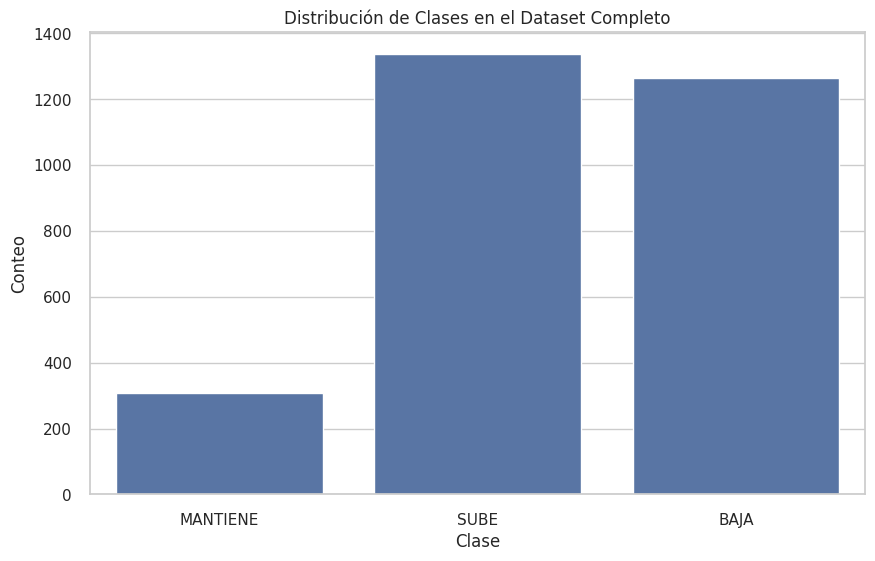

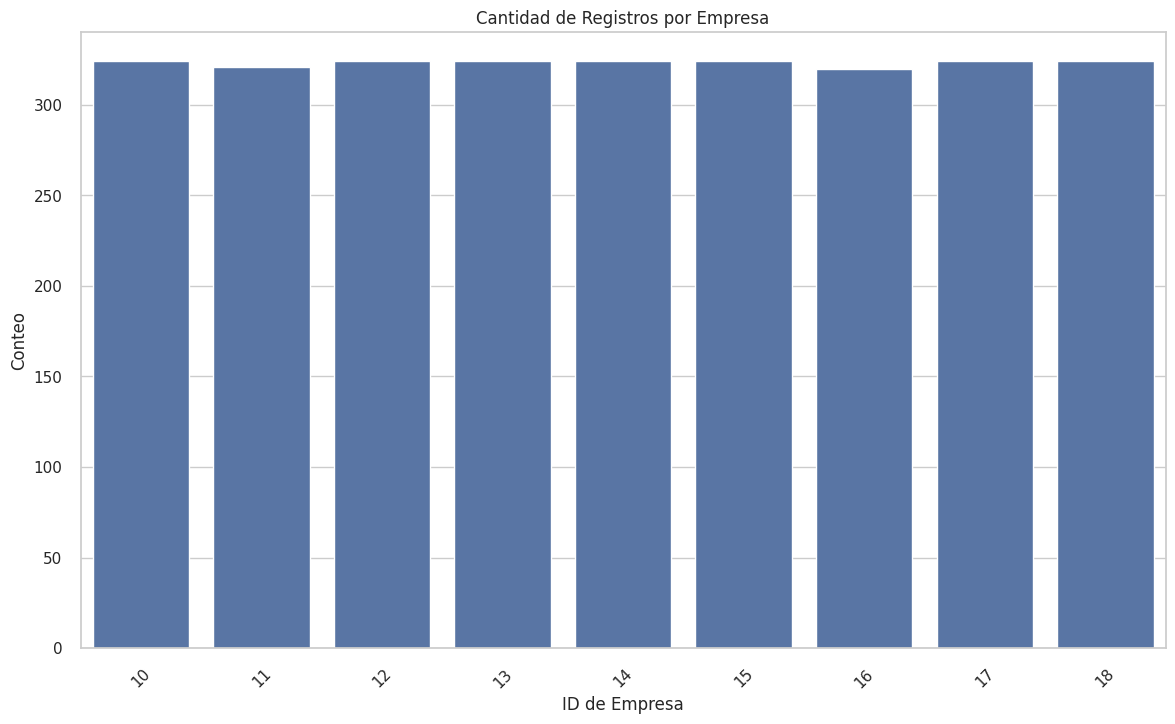

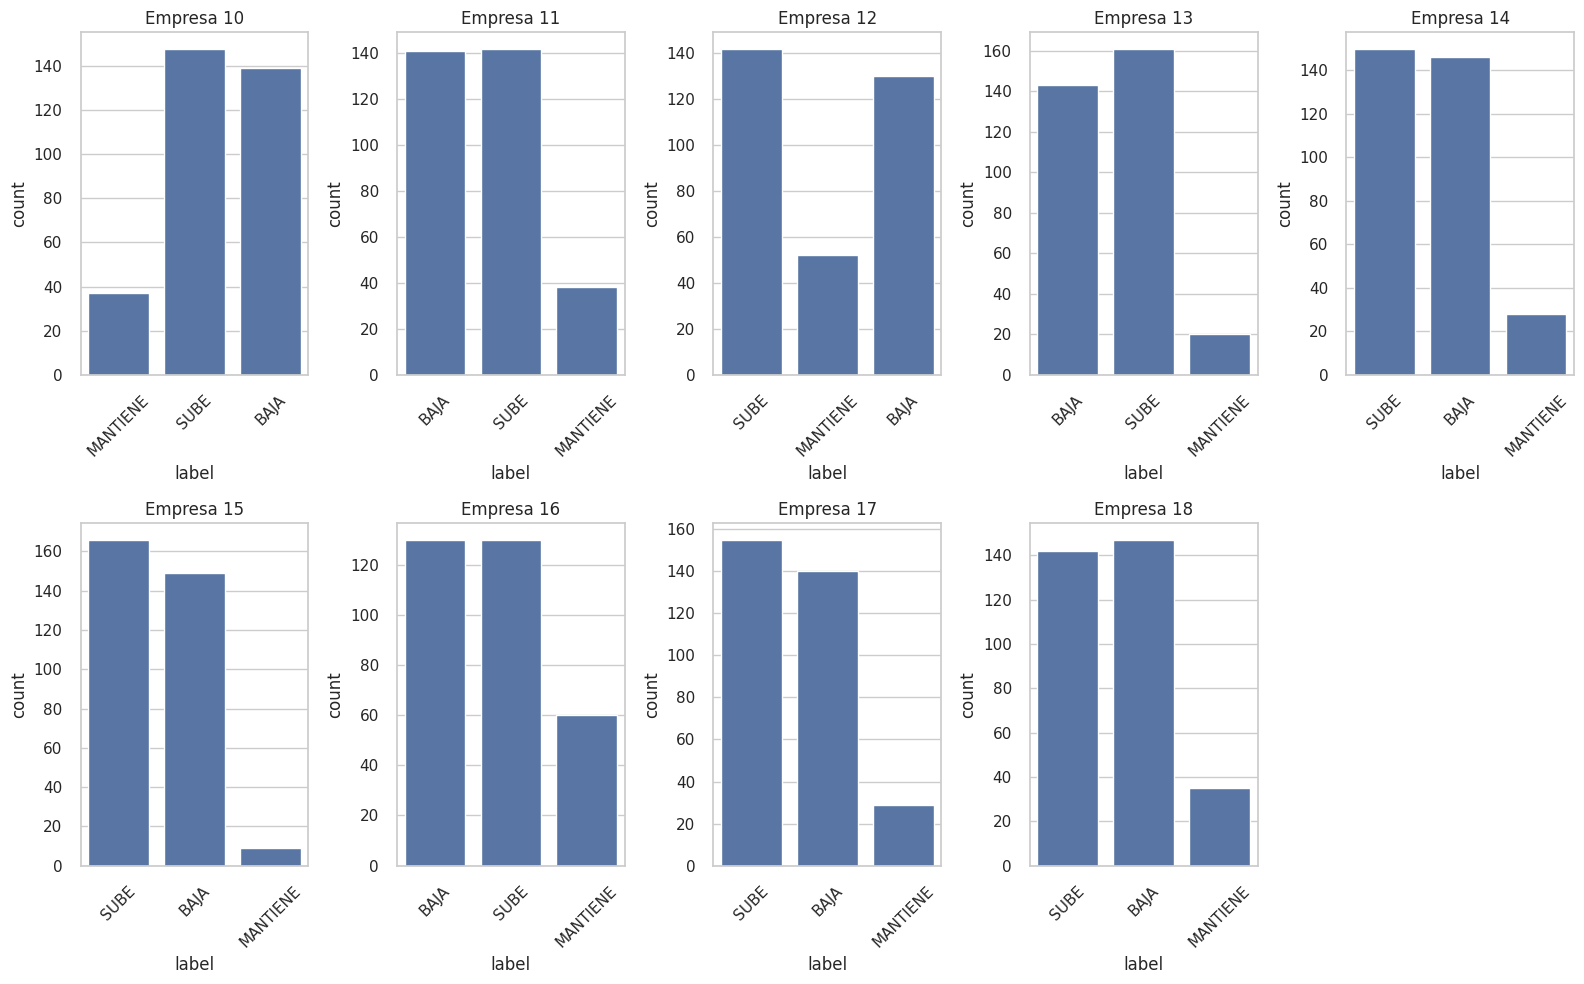

In [4]:
# Visualizaciones iniciales de los datos cargados
# Distribución de clases
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribución de Clases en el Dataset Completo')
plt.ylabel('Conteo')
plt.xlabel('Clase')
plt.show()

# Visualización de registros por empresa
plt.figure(figsize=(14, 8))
sns.countplot(x='id_empresa', data=df)
plt.title('Cantidad de Registros por Empresa')
plt.ylabel('Conteo')
plt.xlabel('ID de Empresa')
plt.xticks(rotation=45)
plt.show()

# Distribución de clases por empresa
empresas = df['id_empresa'].unique()
plt.figure(figsize=(16, 10))
for i, emp in enumerate(empresas, 1):
    plt.subplot(2, (len(empresas)+1)//2, i)
    emp_df = df[df['id_empresa'] == emp]
    sns.countplot(x='label', data=emp_df)
    plt.title(f'Empresa {emp}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

5. Preparación de Datos


In [5]:
@timeit
def preparar_datos(df):
    """Limpia y prepara los datos para el modelado."""
    try:
        # Hacemos una copia para no modificar el original
        df_clean = df.copy()
        
        # 1. Eliminar filas sin etiqueta
        rows_before = df_clean.shape[0]
        df_clean = df_clean.dropna(subset=['label'])
        rows_after = df_clean.shape[0]
        print(f"Filas eliminadas por falta de etiqueta: {rows_before - rows_after}")
        
        # 2. Verificar valores nulos
        null_counts = df_clean.isnull().sum()
        print("Valores nulos por columna:")
        print(null_counts)
        
        # 3. Eliminar columnas con más del 50% de valores faltantes
        threshold = 0.5
        missing_ratio = df_clean.isnull().mean()
        cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()
        if cols_to_drop:
            print(f"Columnas eliminadas por tener más del 50% de valores nulos: {cols_to_drop}")
            df_clean = df_clean.drop(columns=cols_to_drop)
        
        # 4. Eliminar cualquier fila restante con valores faltantes
        rows_before = df_clean.shape[0]
        df_clean = df_clean.dropna()
        rows_after = df_clean.shape[0]
        print(f"Filas eliminadas por valores nulos: {rows_before - rows_after}")
        
        return df_clean
    
    except Exception as e:
        print(f"Error al preparar los datos: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return None

# Preparar datos
df_clean = preparar_datos(df)
print(f"Dimensiones después de la limpieza: {df_clean.shape}")

Iniciando preparar_datos
Filas eliminadas por falta de etiqueta: 0
Valores nulos por columna:
id_cotizacion                        0
id_empresa                           0
fecha                                0
precio_apertura                      0
precio_cierre                        0
                                    ..
total_noticias_negativas_media_5d    0
total_noticias_negativas_std_5d      0
ratio_sent_positivo_negativo         9
diff_score_sentimiento               9
label                                0
Length: 75, dtype: int64
Filas eliminadas por valores nulos: 218
Completado preparar_datos en 0.01 segundos
Dimensiones después de la limpieza: (2691, 75)


6. Análisis de Correlaciones


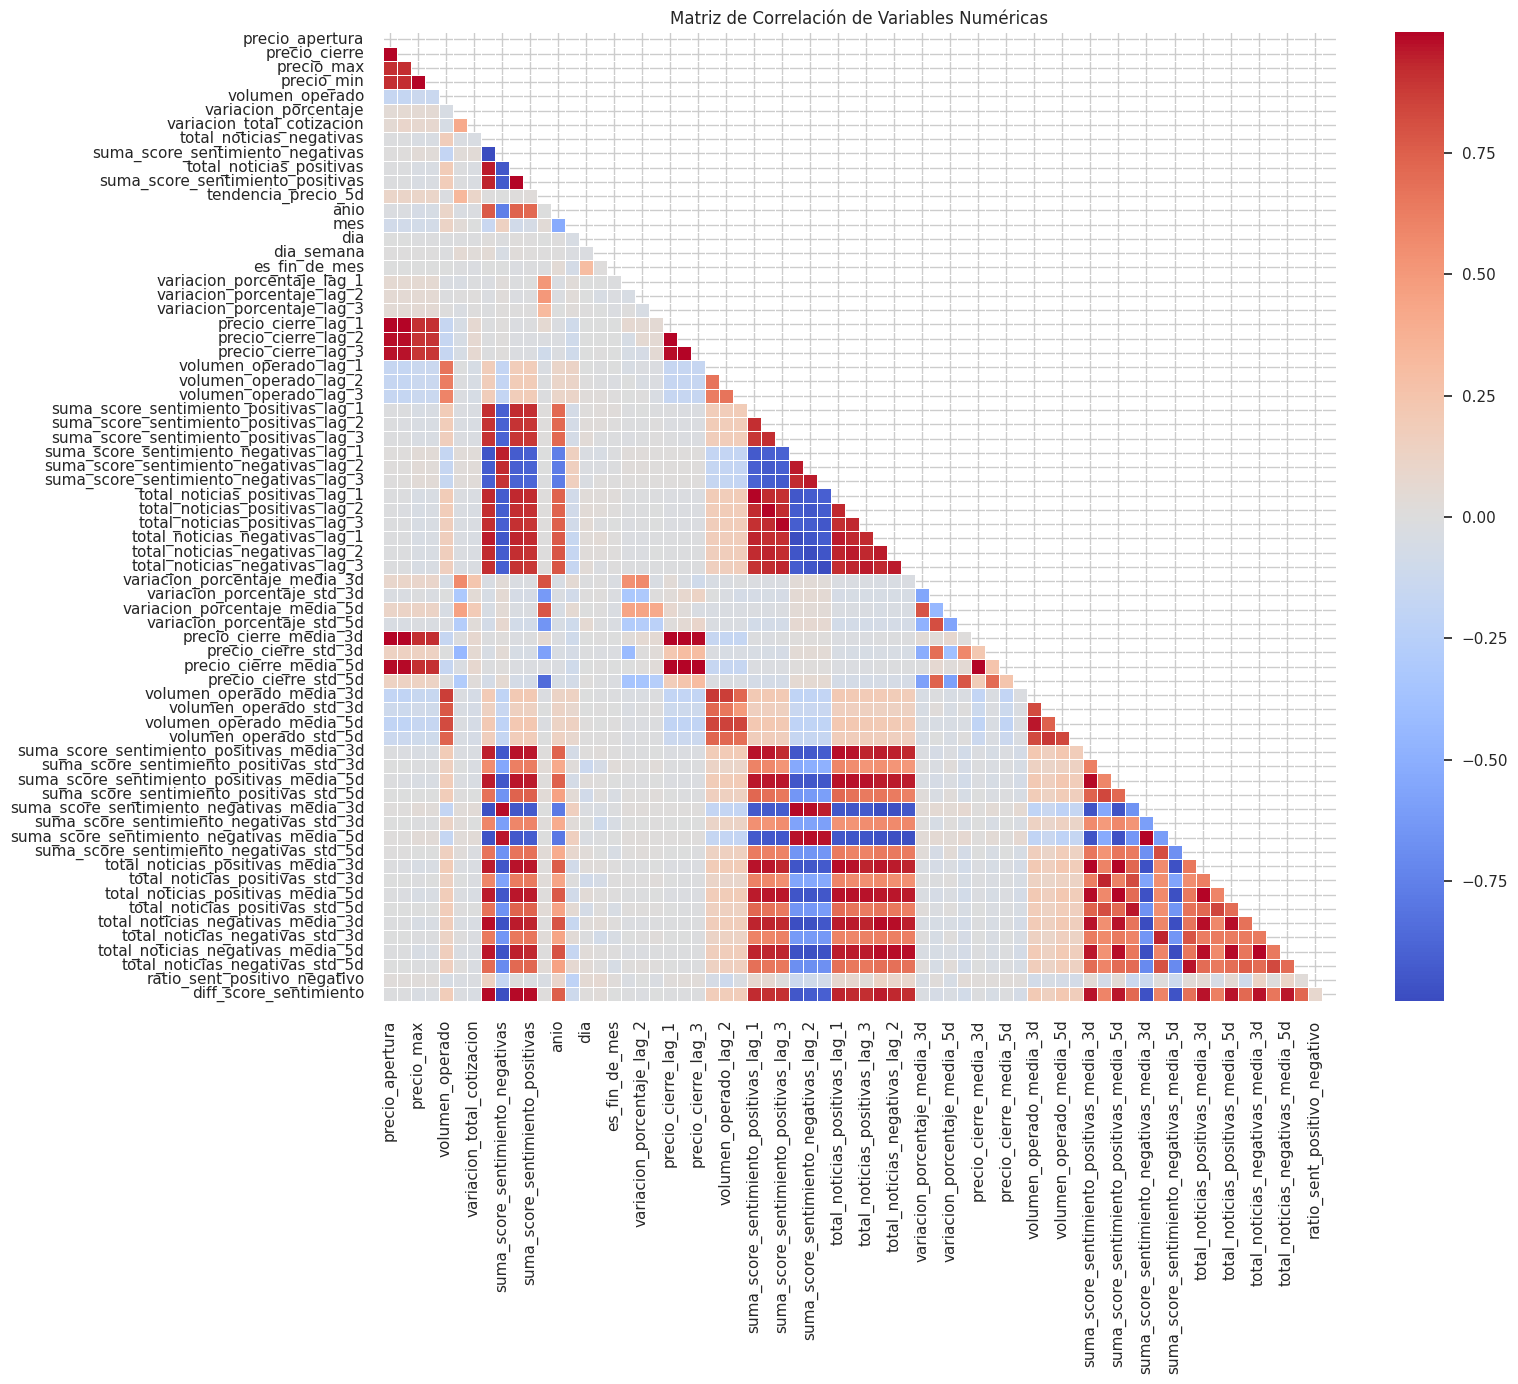

Variables altamente correlacionadas (|r| > 0.9):
precio_apertura - precio_cierre: 0.9988
precio_apertura - precio_max: 0.9181
precio_apertura - precio_min: 0.9188
precio_apertura - precio_cierre_lag_1: 0.9917
precio_apertura - precio_cierre_lag_2: 0.9830
precio_apertura - precio_cierre_lag_3: 0.9745
precio_apertura - precio_cierre_media_3d: 0.9950
precio_apertura - precio_cierre_media_5d: 0.9898
precio_cierre - precio_max: 0.9184
precio_cierre - precio_min: 0.9191
precio_cierre - precio_cierre_lag_1: 0.9913
precio_cierre - precio_cierre_lag_2: 0.9827
precio_cierre - precio_cierre_lag_3: 0.9741
precio_cierre - precio_cierre_media_3d: 0.9952
precio_cierre - precio_cierre_media_5d: 0.9897
precio_max - precio_min: 0.9987
precio_max - precio_cierre_lag_1: 0.9109
precio_max - precio_cierre_lag_2: 0.9024
precio_max - precio_cierre_media_3d: 0.9141
precio_max - precio_cierre_media_5d: 0.9085
precio_min - precio_cierre_lag_1: 0.9113
precio_min - precio_cierre_lag_2: 0.9026
precio_min - precio_c

In [6]:
# Analizamos las correlaciones entre variables numéricas
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'id_empresa' and col != 'id_cotizacion']

# Calculamos la matriz de correlación
corr_matrix = df_clean[numeric_cols].corr()

# Visualizamos el mapa de calor de correlaciones
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.tight_layout()
plt.show()

# Identificamos variables altamente correlacionadas
high_corr_threshold = 0.9
high_corr_pairs = []

for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr = abs(corr_matrix.iloc[i, j])
        if corr > high_corr_threshold:
            high_corr_pairs.append((numeric_cols[i], numeric_cols[j], corr))

# Mostramos las variables altamente correlacionadas
if high_corr_pairs:
    print("Variables altamente correlacionadas (|r| > 0.9):")
    for var1, var2, corr in high_corr_pairs:
        print(f"{var1} - {var2}: {corr:.4f}")
else:
    print("No se encontraron pares de variables con correlación mayor a 0.9")

7. Función de Modelado por Empresa


In [7]:
@timeit
def modelar_empresa(df, empresa_id):
    """Construye y evalúa modelos para una empresa específica."""
    try:
        print(f"{'='*50}")
        print(f"Modelado para la empresa {empresa_id}")
        print(f"{'='*50}")
        
        # Filtramos solo los datos de esta empresa
        empresa_df = df[df['id_empresa'] == empresa_id].copy()
        print(f"Número de registros para la empresa {empresa_id}: {empresa_df.shape[0]}")
        
        # Verificamos la distribución de clases
        label_counts = empresa_df['label'].value_counts()
        print(f"Distribución de clases:\n{label_counts}")
        
        # Verificamos si hay suficientes datos
        if empresa_df.shape[0] < 30:
            print(f"ADVERTENCIA: La empresa {empresa_id} tiene muy pocos registros para modelar adecuadamente.")
            return None, None, None
        
        # Eliminamos columnas no necesarias para el modelado
        cols_to_drop = ['id_cotizacion', 'id_empresa']
        modelo_df = empresa_df.drop(columns=cols_to_drop)
        
        # Inicializamos PyCaret
        exp_name = f"Empresa_{empresa_id}"
        print("Configurando ambiente PyCaret...")
        
        # Nos aseguramos de que no se muestre la UI de html
        s = setup(
            data=modelo_df,
            target='label',
            session_id=42,
            experiment_name=exp_name,
            normalize=True,
            transformation=True,
            ignore_features=['fecha', 'nombre'],
            html=False,
            verbose=True
        )
        
        # Guardamos la información del setup
        setup_df = pull()
        setup_df.to_csv(os.path.join(results_dir, f"setup_empresa_{empresa_id}.csv"))
        print("Setup completado y guardado")
        
        # Comparamos modelos con límites de tiempo para no quedarnos atascados
        print("Comparando modelos...")
        # Usamos n_select=3 para limitar a los 3 mejores modelos
        # Excluimos modelos que pueden tardar mucho y fold=3 para reducir tiempo
        top_models = compare_models(
            n_select=3, 
            fold=3,
            exclude=['gbc', 'lightgbm', 'catboost'], 
            sort='F1',
            verbose=True
        )
        
        # Verificar si hay modelos, ya que compare_models puede devolver lista vacía
        if not top_models:
            print(f"No se encontraron modelos viables para la empresa {empresa_id}. Posible desbalance extremo de clases.")
            return empresa_df, [], {}
            
        # Si top_models es un solo modelo y no una lista, lo convertimos a lista
        if not isinstance(top_models, list):
            top_models = [top_models]
        
        # Guardamos la comparación de modelos
        model_comp = pull()
        model_comp.to_csv(os.path.join(results_dir, f"comparacion_modelos_empresa_{empresa_id}.csv"))
        print(f"Comparación de modelos completada. Top modelos: {[str(type(m).__name__) for m in top_models]}")
        
        # Creamos un diccionario para almacenar los resultados
        resultados = {}
        
        # Evaluamos cada uno de los modelos top
        print("Evaluando modelos seleccionados...")
        for i, model in enumerate(top_models):
            model_name = str(type(model).__name__)
            print(f"Evaluando {model_name}...")
            
            # Evaluamos el modelo
            evaluation = evaluate_model(model)
            
            # Creamos un modelo ajustado (tuneado) con número limitado de iteraciones
            print(f"Tuneando {model_name}...")
            tuned_model = tune_model(
                model, 
                n_iter=10,  # Limitamos a 10 iteraciones para controlar el tiempo
                optimize='F1',
                search_library='optuna',
                choose_better=True,
                verbose=True
            )
            
            # Visualizamos las diferentes gráficas usando plot_model
            print(f"Generando visualizaciones para {model_name}...")
            
            # Matriz de confusión
            plot_model(tuned_model, plot='confusion_matrix')
            
            # Curva ROC
            try:
                plot_model(tuned_model, plot='auc')
            except:
                print("No se pudo generar curva AUC para este modelo")
                
            # Feature Importance
            try:
                plot_model(tuned_model, plot='feature')
            except:
                print("No se pudo generar gráfico de importancia de características con plot_model")
                
                # Implementación manual de importancia de características
                try:
                    # Intentar obtener importancia de características de diferentes maneras
                    importance = None
                    features = get_config('X_train').columns.tolist()
                    
                    if hasattr(tuned_model, 'feature_importances_'):
                        importance = tuned_model.feature_importances_
                    elif hasattr(tuned_model, 'coef_'):
                        if tuned_model.coef_.ndim > 1:
                            importance = np.abs(tuned_model.coef_).sum(axis=0)
                        else:
                            importance = np.abs(tuned_model.coef_)
                    # Añadir soporte para modelos con importancia implícita
                    elif isinstance(tuned_model, (KNeighborsClassifier, LogisticRegression)):
                        # Para KNN y modelos lineales sin importancia explícita, usar permutación
                        from sklearn.inspection import permutation_importance
                        
                        # Obtener los datos de entrenamiento
                        X_train = get_config('X_train')
                        y_train = get_config('y_train')
                        
                        # Asegurarse de que X_train esté como array para permutation_importance
                        result = permutation_importance(tuned_model, X_train, y_train, 
                                                       n_repeats=5, random_state=42, n_jobs=-1)
                        importance = result.importances_mean
                    
                    # Si tenemos importancia y características, crear visualización
                    if importance is not None and len(features) == len(importance):
                        feature_importance = pd.DataFrame({
                            'Feature': features,
                            'Importance': importance
                        })
                        feature_importance = feature_importance.sort_values('Importance', ascending=False)
                        
                        # Mostrar solo las 15 características más importantes
                        top_n = min(15, len(feature_importance))
                        feature_importance = feature_importance.head(top_n)
                        
                        plt.figure(figsize=(12, 8))
                        sns.barplot(x='Importance', y='Feature', data=feature_importance)
                        plt.title(f'Importancia de Características - {model_name} - Empresa {empresa_id}')
                        plt.tight_layout()
                        plt.show()
                except Exception as feat_err:
                    print(f"Error al generar importancia de características: {str(feat_err)}")
            
            # Guardamos el modelo
            model_path = os.path.join(results_dir, "models", f"modelo_{empresa_id}_{model_name}")
            print(f"Guardando modelo en {model_path}...")
            save_model(tuned_model, model_path)
            
            resultados[model_name] = tuned_model
            
            # Guardamos las métricas detalladas
            try:
                metrics = pull()
                metrics.to_csv(os.path.join(results_dir, f"metricas_empresa_{empresa_id}_{model_name}.csv"))
            except Exception as metrics_error:
                print(f"Error al guardar métricas: {str(metrics_error)}")
        
        # Finalizamos
        print(f"Modelado completo para la empresa {empresa_id}")
        
        # Retornamos el DataFrame de la empresa, los modelos y los resultados
        return empresa_df, top_models, resultados
    
    except Exception as e:
        print(f"Error en modelado de empresa {empresa_id}: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return None, None, None

8. Modelado para Todas las Empresas


Procesando empresa 10...
Iniciando modelar_empresa
Modelado para la empresa 10
Número de registros para la empresa 10: 299
Distribución de clases:
label
SUBE        138
BAJA        132
MANTIENE     29
Name: count, dtype: int64
Configurando ambiente PyCaret...
                    Description                          Value
0                    Session id                             42
1                        Target                          label
2                   Target type                     Multiclass
3                Target mapping  BAJA: 0, MANTIENE: 1, SUBE: 2
4           Original data shape                      (299, 73)
5        Transformed data shape                      (299, 73)
6   Transformed train set shape                      (209, 73)
7    Transformed test set shape                       (90, 73)
8               Ignore features                              2
9              Numeric features                             68
10         Categorical features                

                                   Model  Accuracy     AUC  Recall   Prec.  \
lr                   Logistic Regression    0.4164  0.0000  0.4164  0.4602   
knn               K Neighbors Classifier    0.4116  0.4881  0.4116  0.4014   
rf              Random Forest Classifier    0.4019  0.4987  0.4019  0.4182   
svm                  SVM - Linear Kernel    0.3925  0.0000  0.3925  0.4353   
et                Extra Trees Classifier    0.3827  0.4901  0.3827  0.4087   
ridge                   Ridge Classifier    0.4498  0.0000  0.4498  0.5258   
dummy                   Dummy Classifier    0.4642  0.5000  0.4642  0.2156   
qda      Quadratic Discriminant Analysis    0.2580  0.0000  0.2580  0.2147   
nb                           Naive Bayes    0.1342  0.4981  0.1342  0.2371   
dt              Decision Tree Classifier    0.0957  0.5000  0.0957  0.0092   
ada                 Ada Boost Classifier    0.0957  0.0000  0.0957  0.0092   
lda         Linear Discriminant Analysis    0.0957  0.0000  0.09

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando LogisticRegression...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.4286  0.0  0.4286  0.4307  0.4286  0.0195  0.0195
1       0.5238  0.0  0.5238  0.5357  0.5185  0.2279  0.2316
2       0.5714  0.0  0.5714  0.5820  0.5744  0.2841  0.2853
3       0.3810  0.0  0.3810  0.3646  0.3569  0.0250  0.0259
4       0.4286  0.0  0.4286  0.3798  0.3789 -0.0678 -0.0791
5       0.6190  0.0  0.6190  0.6918  0.6084  0.4043  0.4336
6       0.3333  0.0  0.3333  0.3309  0.3263 -0.1053 -0.1081
7       0.4762  0.0  0.4762  0.5293  0.4894  0.1750  0.1811
8       0.5714  0.0  0.5714  0.5769  0.5583  0.3077  0.3160
9       0.2500  0.0  0.2500  0.2812  0.2647 -0.2097 -0.2125
Mean    0.4583  0.0  0.4583  0.4703  0.4504  0.1061  0.1093
Std     0.1108  0.0  0.1108  0.1252  0.1106  0.1922  0.2001
Generando visualizaciones para LogisticRegression...


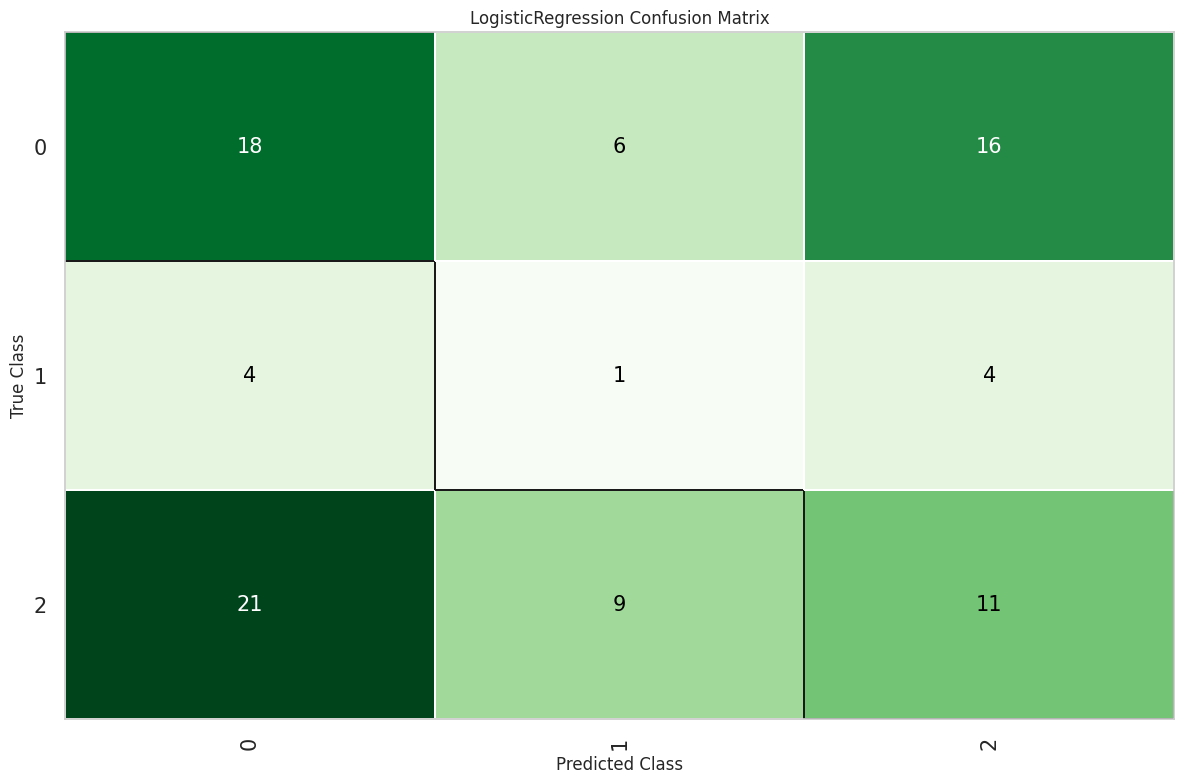

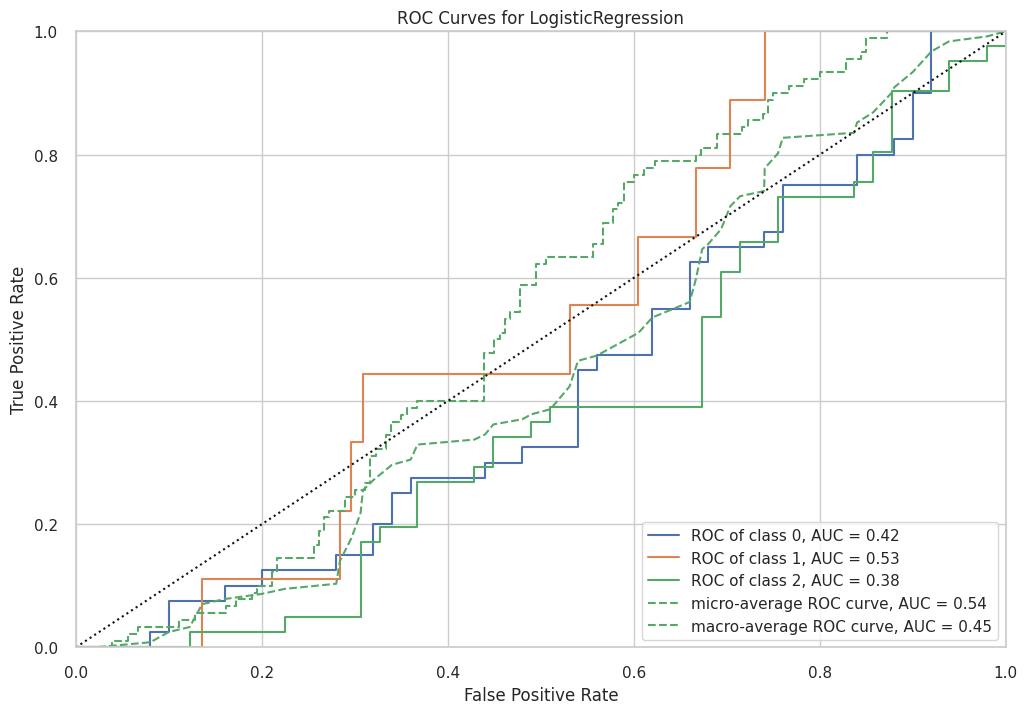

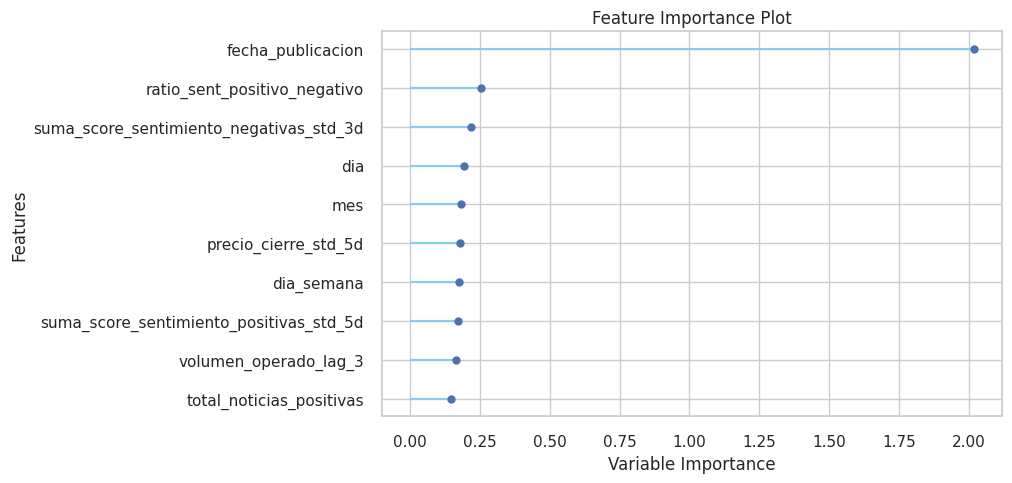

Guardando modelo en resultados_20250504_155841/models/modelo_10_LogisticRegression...
Transformation Pipeline and Model Successfully Saved
Evaluando KNeighborsClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando KNeighborsClassifier...


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.3810  0.4373  0.3810  0.3512  0.3327 -0.1053 -0.1285
1       0.6667  0.6855  0.6667  0.6531  0.6343  0.4000  0.4375
2       0.4762  0.5880  0.4762  0.4384  0.4141  0.0170  0.0214
3       0.4762  0.3318  0.4762  0.4365  0.4381  0.0253  0.0280
4       0.4762  0.5924  0.4762  0.4384  0.4141  0.0170  0.0214
5       0.5714  0.6318  0.5714  0.5243  0.5420  0.2092  0.2167
6       0.4762  0.5372  0.4762  0.4218  0.4385  0.0294  0.0312
7       0.3810  0.4896  0.3810  0.3032  0.3128 -0.1617 -0.2037
8       0.5238  0.5605  0.5238  0.4830  0.4921  0.1176  0.1250
9       0.6000  0.6112  0.6000  0.5455  0.5700  0.2727  0.2787
Mean    0.5029  0.5465  0.5029  0.4595  0.4589  0.0821  0.0828
Std     0.0860  0.0981  0.0860  0.0941  0.0966  0.1624  0.1799
Generando visualizaciones para KNeighborsClassifier...


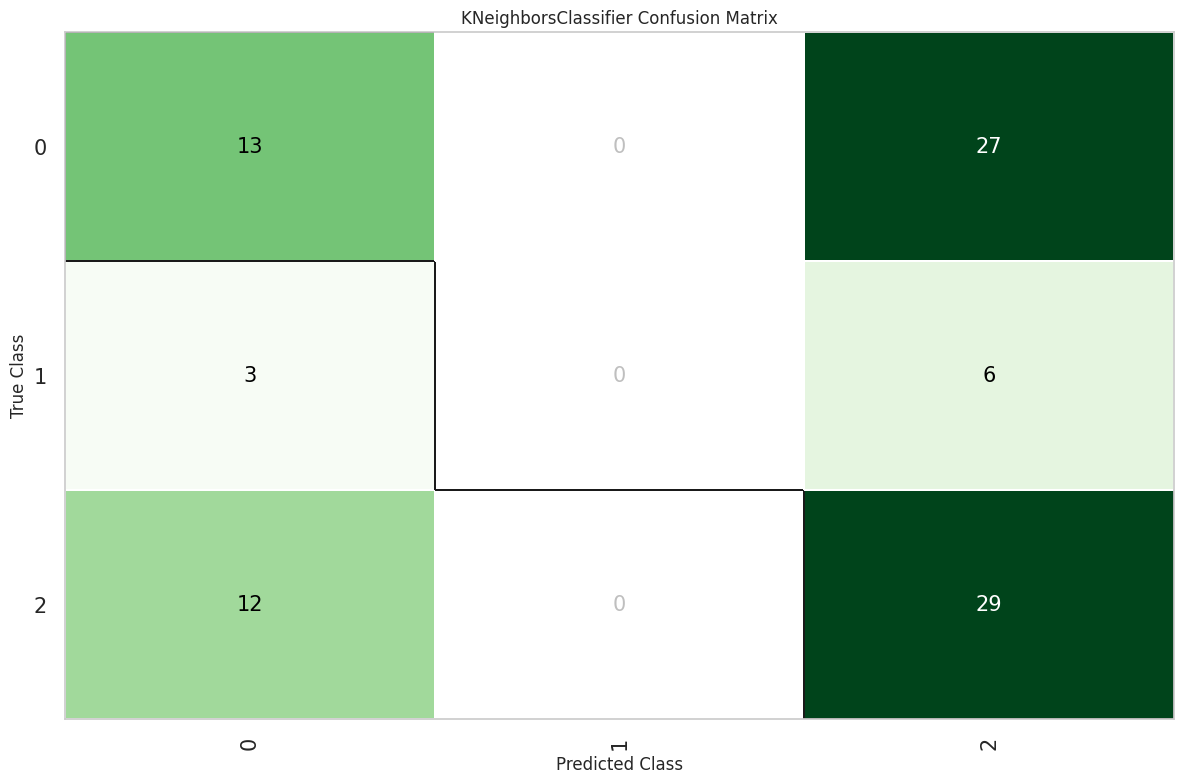

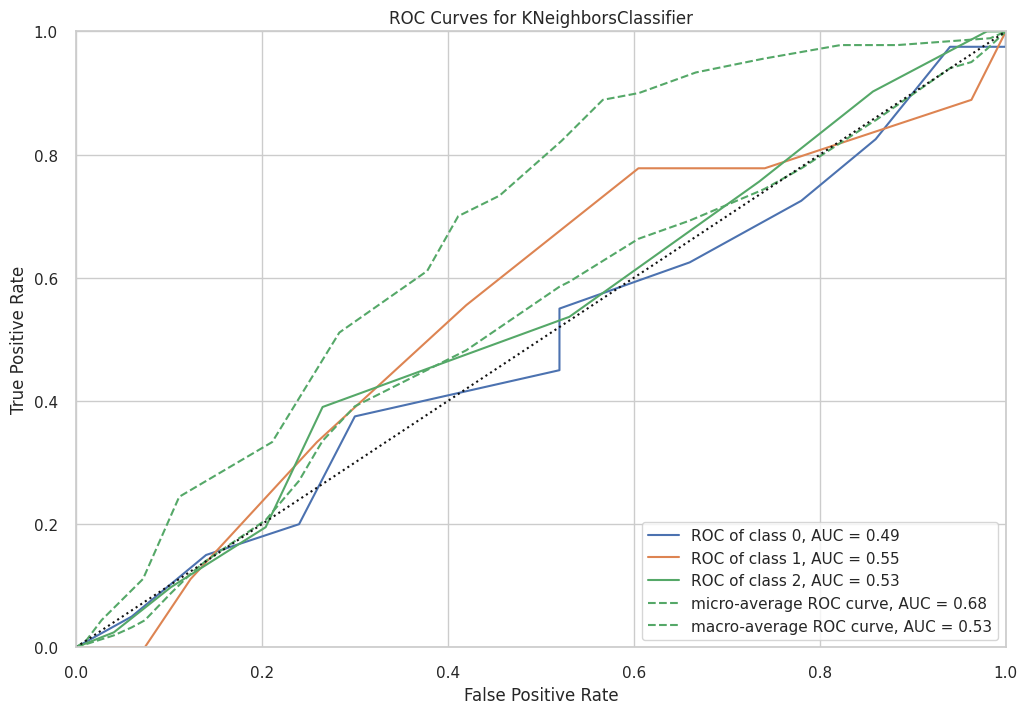

No se pudo generar gráfico de importancia de características con plot_model
Error al generar importancia de características: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- valoracion_llm
Feature names seen at fit time, yet now missing:
- valoracion_llm_negative
- valoracion_llm_neutral
- valoracion_llm_positive

Guardando modelo en resultados_20250504_155841/models/modelo_10_KNeighborsClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando RandomForestClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando RandomForestClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.1905  0.5704  0.1905  0.1833  0.1436  0.0192  0.0346
1       0.1429  0.4802  0.1429  0.1774  0.1330 -0.0385 -0.0692
2       0.1429  0.6485  0.1429  0.2481  0.0975  0.0131  0.0358
3       0.0952  0.3396  0.0952  0.0857  0.0707 -0.1368 -0.2236
4       0.1905  0.5365  0.1905  0.1859  0.1714 -0.0657 -0.0953
5       0.1905  0.5463  0.1905  0.2493  0.1561  0.0272  0.0536
6       0.2381  0.4700  0.2381  0.2177  0.1919  0.0204  0.0312
7       0.1905  0.5053  0.1905  0.2109  0.1800 -0.0408 -0.0625
8       0.3333  0.5962  0.3333  0.2804  0.2778  0.1009  0.1403
9       0.1000  0.5215  0.1000  0.0111  0.0200 -0.0405 -0.1079
Mean    0.1814  0.5214  0.1814  0.1850  0.1442 -0.0141 -0.0263
Std     0.0661  0.0792  0.0661  

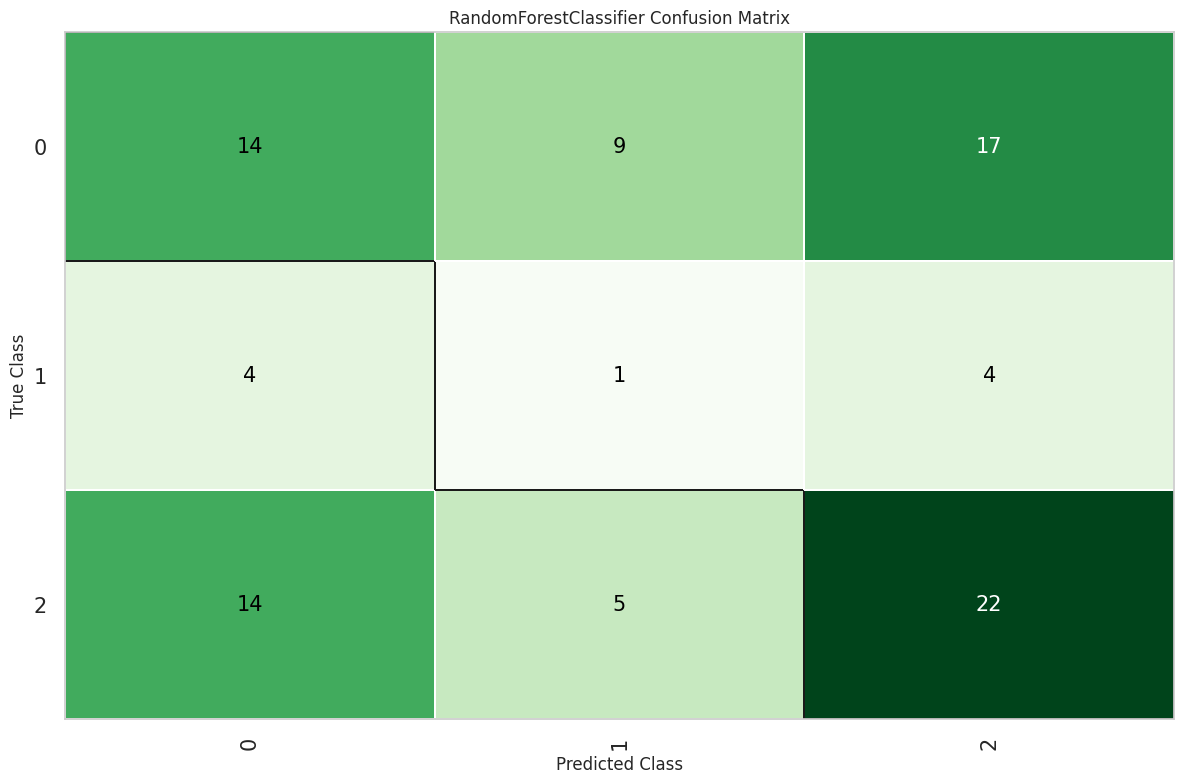

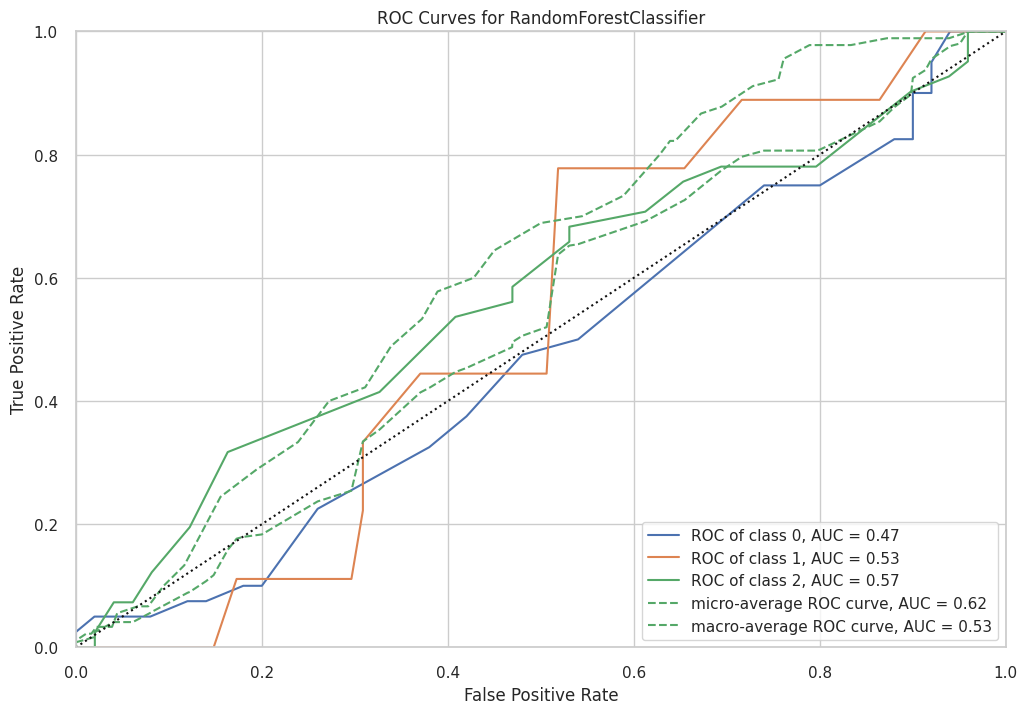

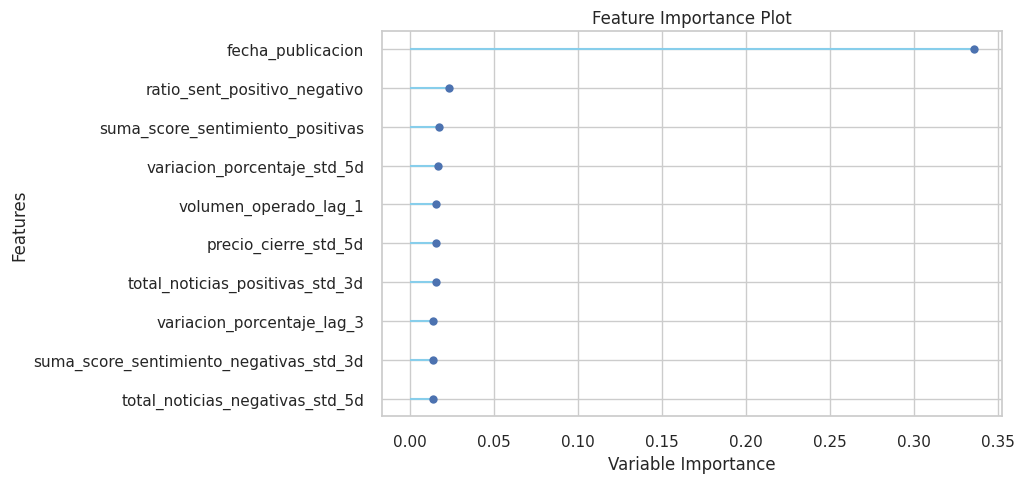

Guardando modelo en resultados_20250504_155841/models/modelo_10_RandomForestClassifier...
Transformation Pipeline and Model Successfully Saved
Modelado completo para la empresa 10
Completado modelar_empresa en 163.07 segundos
Empresa 10 procesada en 2.72 minutos
Procesando empresa 11...
Iniciando modelar_empresa
Modelado para la empresa 11
Número de registros para la empresa 11: 299
Distribución de clases:
label
SUBE        133
BAJA        131
MANTIENE     35
Name: count, dtype: int64
Configurando ambiente PyCaret...
                    Description                          Value
0                    Session id                             42
1                        Target                          label
2                   Target type                     Multiclass
3                Target mapping  BAJA: 0, MANTIENE: 1, SUBE: 2
4           Original data shape                      (299, 73)
5        Transformed data shape                      (299, 73)
6   Transformed train set shape     

                                   Model  Accuracy     AUC  Recall   Prec.  \
knn               K Neighbors Classifier    0.4829  0.5551  0.4829  0.4736   
rf              Random Forest Classifier    0.4210  0.5622  0.4210  0.4465   
svm                  SVM - Linear Kernel    0.4068  0.0000  0.4068  0.4340   
et                Extra Trees Classifier    0.3829  0.5437  0.3829  0.4163   
lr                   Logistic Regression    0.3687  0.0000  0.3687  0.4040   
ridge                   Ridge Classifier    0.4068  0.0000  0.4068  0.2247   
dummy                   Dummy Classifier    0.4402  0.5000  0.4402  0.1938   
qda      Quadratic Discriminant Analysis    0.2206  0.0000  0.2206  0.2768   
nb                           Naive Bayes    0.1149  0.4875  0.1149  0.0735   
dt              Decision Tree Classifier    0.1148  0.5000  0.1148  0.0132   
ada                 Ada Boost Classifier    0.1148  0.0000  0.1148  0.0132   
lda         Linear Discriminant Analysis    0.1148  0.0000  0.11

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando KNeighborsClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.5714  0.7045  0.5714  0.5624  0.5362  0.2530  0.2774
1       0.5714  0.5772  0.5714  0.5429  0.5119  0.2559  0.2947
2       0.5714  0.5900  0.5714  0.5936  0.5713  0.2440  0.2471
3       0.3333  0.4858  0.3333  0.3160  0.3243 -0.1855 -0.1864
4       0.3810  0.4943  0.3810  0.4001  0.3875 -0.0420 -0.0425
5       0.4762  0.6402  0.4762  0.5243  0.4659  0.1047  0.1103
6       0.4762  0.5000  0.4762  0.5143  0.4439  0.1047  0.1192
7       0.4762  0.5608  0.4762  0.4878  0.4764  0.1630  0.1648
8       0.4286  0.5589  0.4286  0.4524  0.4398  0.0870  0.0873
9       0.5000  0.5678  0.5000  0.5155  0.5018  0.1701  0.1723
Mean    0.4786  0.5680  0.4786  0.4909  0.4659  0.1155  0.1244
Std     0.0771  0.0643  0.0771  

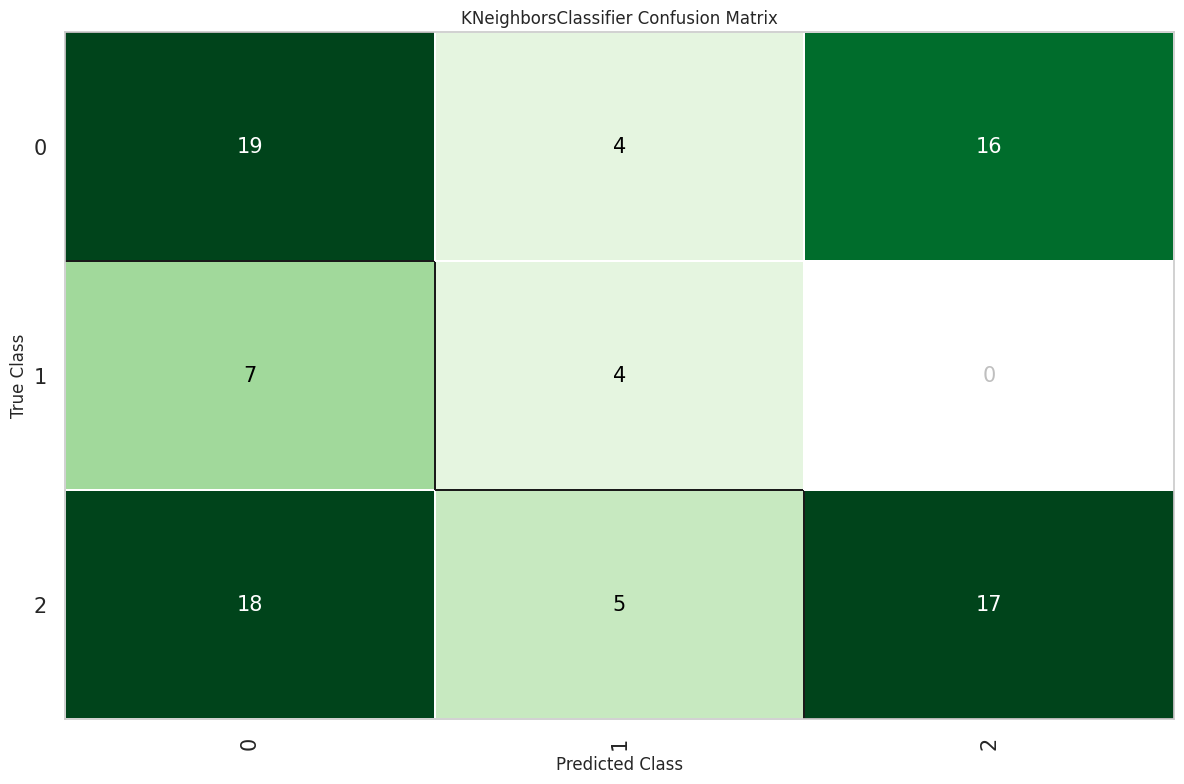

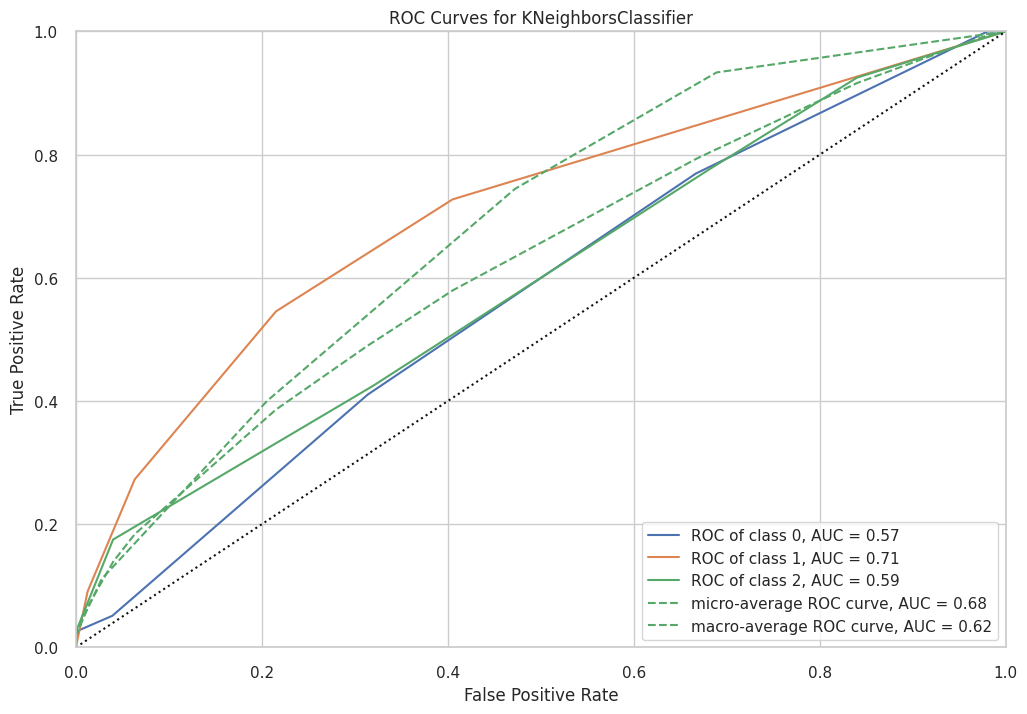

No se pudo generar gráfico de importancia de características con plot_model
Error al generar importancia de características: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- valoracion_llm
Feature names seen at fit time, yet now missing:
- valoracion_llm_negative
- valoracion_llm_neutral
- valoracion_llm_positive

Guardando modelo en resultados_20250504_155841/models/modelo_11_KNeighborsClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando RandomForestClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando RandomForestClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.0952  0.5700  0.0952  0.0095  0.0173 -0.0205 -0.0791
1       0.1905  0.4828  0.1905  0.2381  0.2116 -0.0657 -0.0953
2       0.1429  0.5182  0.1429  0.4857  0.1039  0.0332  0.1285
3       0.0952  0.5147  0.0952  0.0091  0.0166  0.0000  0.0000
4       0.2381  0.5101  0.2381  0.2517  0.2262  0.0400  0.0625
5       0.2381  0.5946  0.2381  0.2041  0.1943  0.0000  0.0000
6       0.3810  0.6098  0.3810  0.3095  0.3238  0.1574  0.2112
7       0.1429  0.6409  0.1429  0.0204  0.0357  0.0000  0.0000
8       0.1429  0.5675  0.1429  0.0204  0.0357  0.0000  0.0000
9       0.1000  0.4251  0.1000  0.0100  0.0182  0.0000  0.0000
Mean    0.1767  0.5434  0.1767  0.1559  0.1183  0.0145  0.0228
Std     0.0849  0.0617  0.0849  

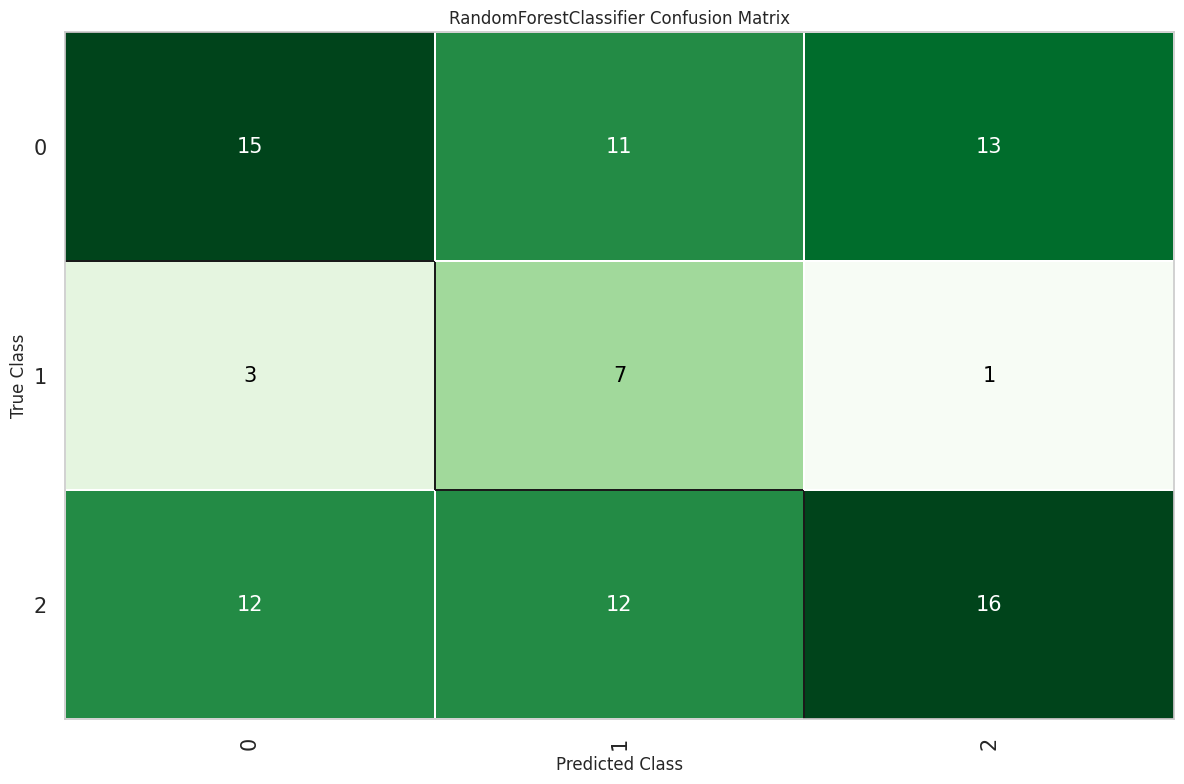

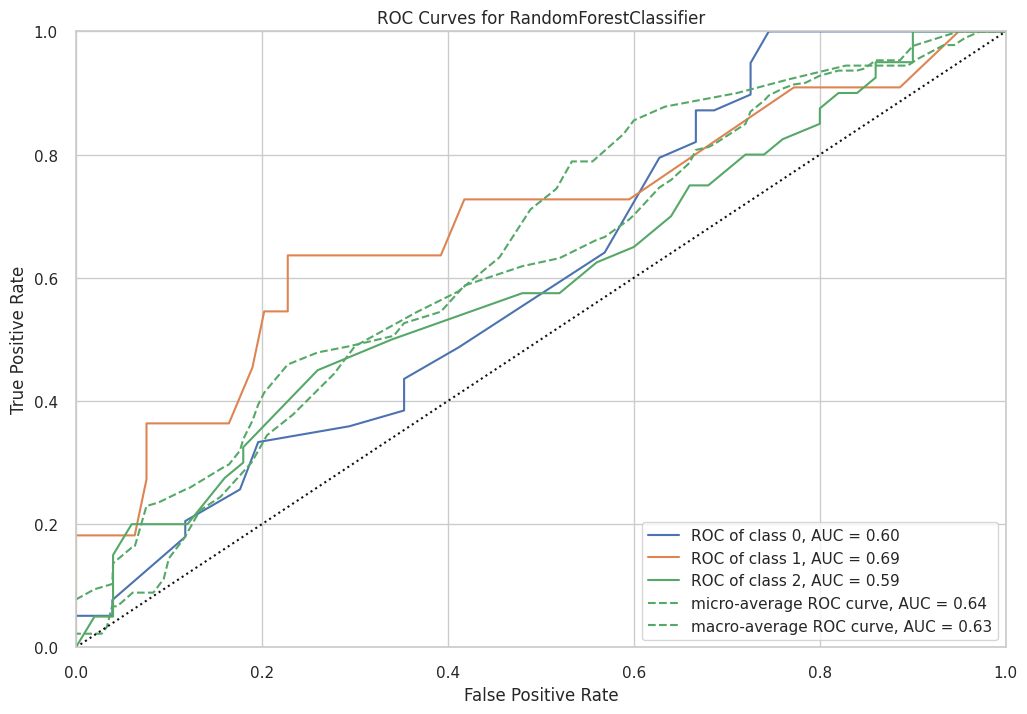

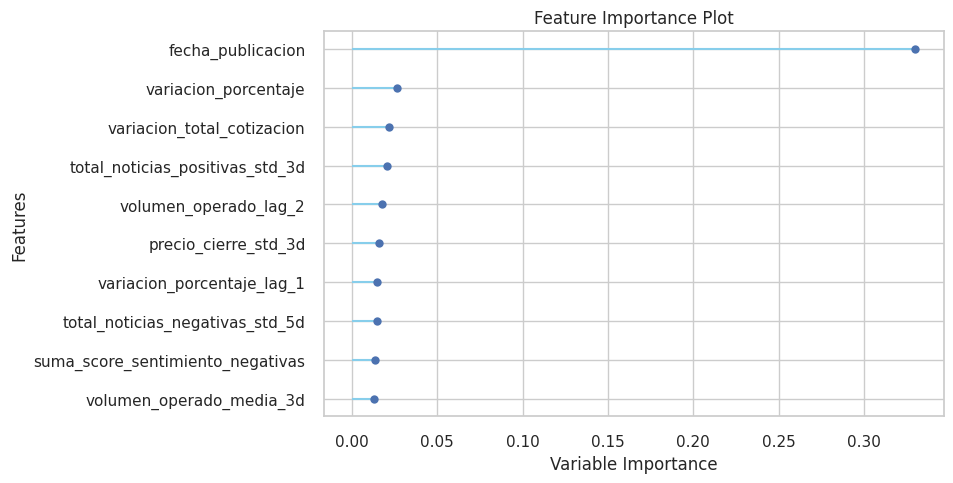

Guardando modelo en resultados_20250504_155841/models/modelo_11_RandomForestClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando SGDClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando SGDClassifier...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.4762  0.0  0.4762  0.5293  0.4894  0.1750  0.1811
1       0.2857  0.0  0.2857  0.4159  0.3340 -0.0788 -0.0850
2       0.4286  0.0  0.4286  0.4365  0.4002  0.1280  0.1382
3       0.5714  0.0  0.5714  0.6156  0.5853  0.3000  0.3047
4       0.4286  0.0  0.4286  0.5094  0.4649  0.0935  0.0961
5       0.3333  0.0  0.3333  0.3010  0.3112 -0.1136 -0.1169
6       0.4286  0.0  0.4286  0.4226  0.4244  0.0667  0.0669
7       0.3333  0.0  0.3333  0.3259  0.3262 -0.0889 -0.0902
8       0.4286  0.0  0.4286  0.5048  0.4048  0.0667  0.0778
9       0.5000  0.0  0.5000  0.5979  0.5297  0.2366  0.2494
Mean    0.4214  0.0  0.4214  0.4659  0.4270  0.0785  0.0822
Std     0.0811  0.0  0.0811  0.0996  0.0862  0.1327  0.1372
Generando visualizaciones para SGDClassifier...


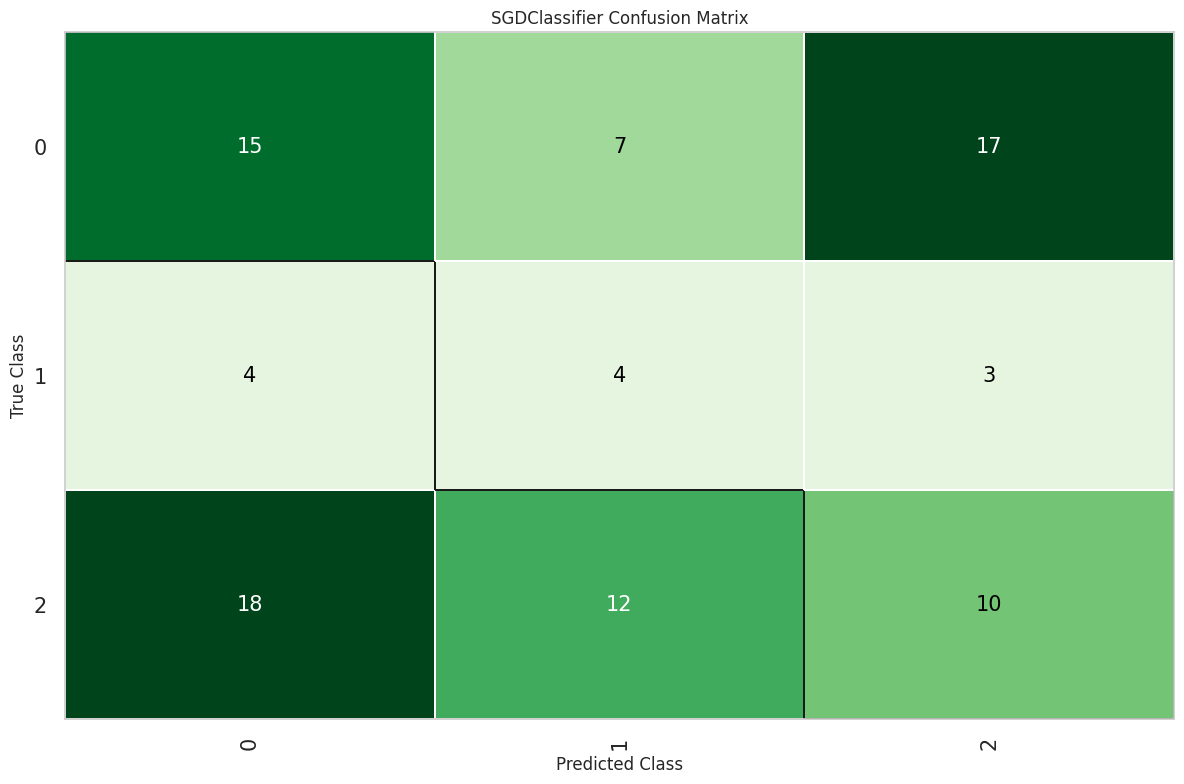

No se pudo generar curva AUC para este modelo


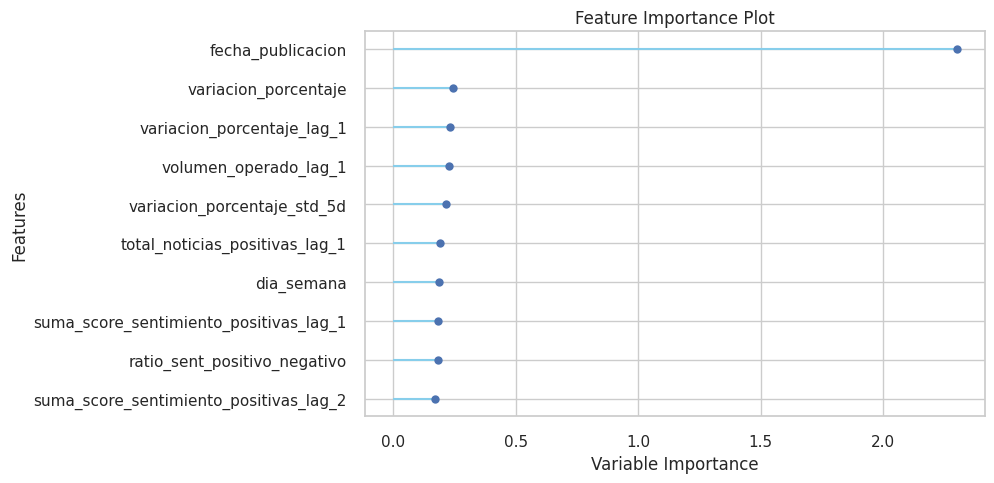

Guardando modelo en resultados_20250504_155841/models/modelo_11_SGDClassifier...
Transformation Pipeline and Model Successfully Saved
Modelado completo para la empresa 11
Completado modelar_empresa en 139.81 segundos
Empresa 11 procesada en 2.33 minutos
Procesando empresa 12...
Iniciando modelar_empresa
Modelado para la empresa 12
Número de registros para la empresa 12: 299
Distribución de clases:
label
SUBE        131
BAJA        124
MANTIENE     44
Name: count, dtype: int64
Configurando ambiente PyCaret...
                    Description                          Value
0                    Session id                             42
1                        Target                          label
2                   Target type                     Multiclass
3                Target mapping  BAJA: 0, MANTIENE: 1, SUBE: 2
4           Original data shape                      (299, 73)
5        Transformed data shape                      (299, 73)
6   Transformed train set shape              

                                   Model  Accuracy     AUC  Recall   Prec.  \
knn               K Neighbors Classifier    0.4401  0.5575  0.4401  0.4402   
lr                   Logistic Regression    0.3681  0.0000  0.3681  0.4710   
svm                  SVM - Linear Kernel    0.3593  0.0000  0.3593  0.4108   
rf              Random Forest Classifier    0.3683  0.5123  0.3683  0.4025   
et                Extra Trees Classifier    0.2872  0.5474  0.2872  0.4820   
dummy                   Dummy Classifier    0.4354  0.5000  0.4354  0.1896   
ridge                   Ridge Classifier    0.3349  0.0000  0.3349  0.1920   
qda      Quadratic Discriminant Analysis    0.2348  0.0000  0.2348  0.1631   
dt              Decision Tree Classifier    0.1483  0.5000  0.1483  0.0220   
ada                 Ada Boost Classifier    0.1483  0.0000  0.1483  0.0220   
lda         Linear Discriminant Analysis    0.1483  0.0000  0.1483  0.0220   
xgboost        Extreme Gradient Boosting    0.1483  0.5254  0.14

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando KNeighborsClassifier...


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.4762  0.5304  0.4762  0.4143  0.4214  0.0833  0.0953
1       0.5714  0.6415  0.5714  0.4881  0.5238  0.2500  0.2609
2       0.5238  0.5595  0.5238  0.4481  0.4827  0.1667  0.1723
3       0.5238  0.5807  0.5238  0.4481  0.4827  0.1667  0.1723
4       0.5714  0.6733  0.5714  0.5204  0.5287  0.2500  0.2739
5       0.4762  0.5106  0.4762  0.4143  0.4214  0.0833  0.0953
6       0.3810  0.4259  0.3810  0.3143  0.3286 -0.0833 -0.0953
7       0.4762  0.4195  0.4762  0.4139  0.4293  0.1012  0.1101
8       0.4286  0.5859  0.4286  0.3206  0.3462  0.0562  0.0668
9       0.5000  0.4827  0.5000  0.4479  0.4647  0.1379  0.1472
Mean    0.4929  0.5410  0.4929  0.4230  0.4430  0.1212  0.1299
Std     0.0564  0.0800  0.0564  0.0618  0.0641  0.0932  0.0996
Generando visualizaciones para KNeighborsClassifier...


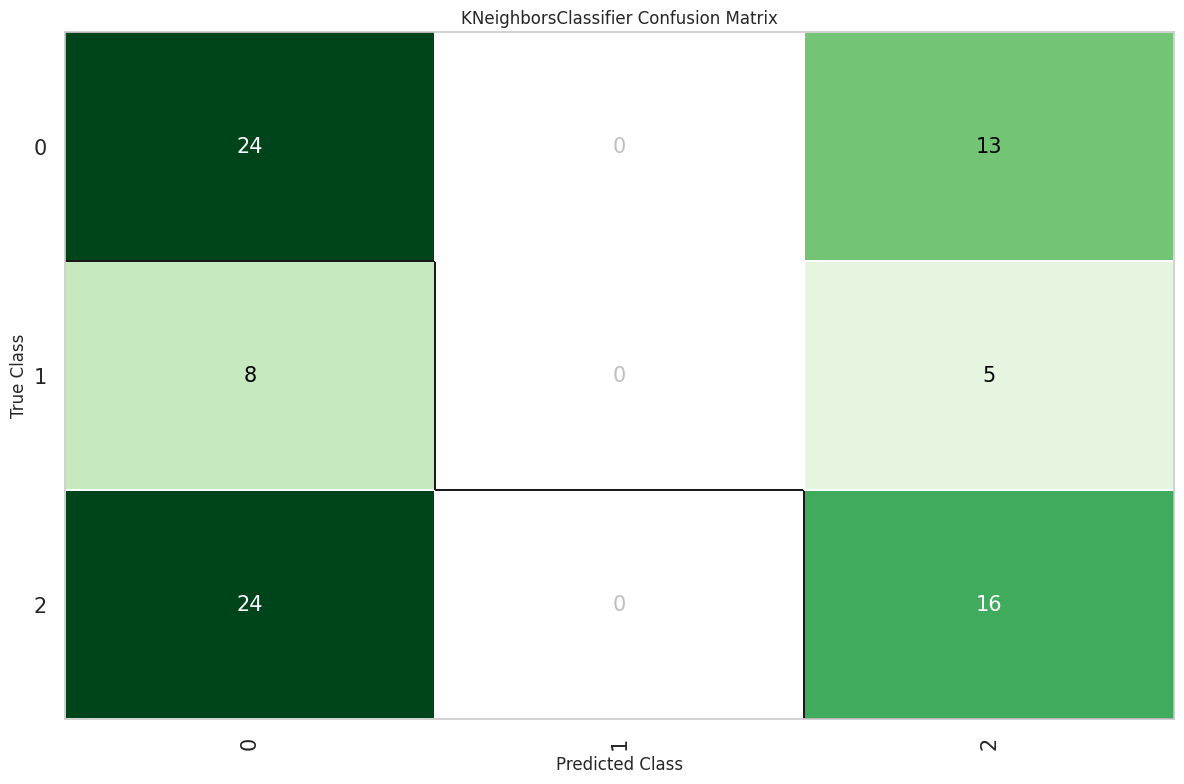

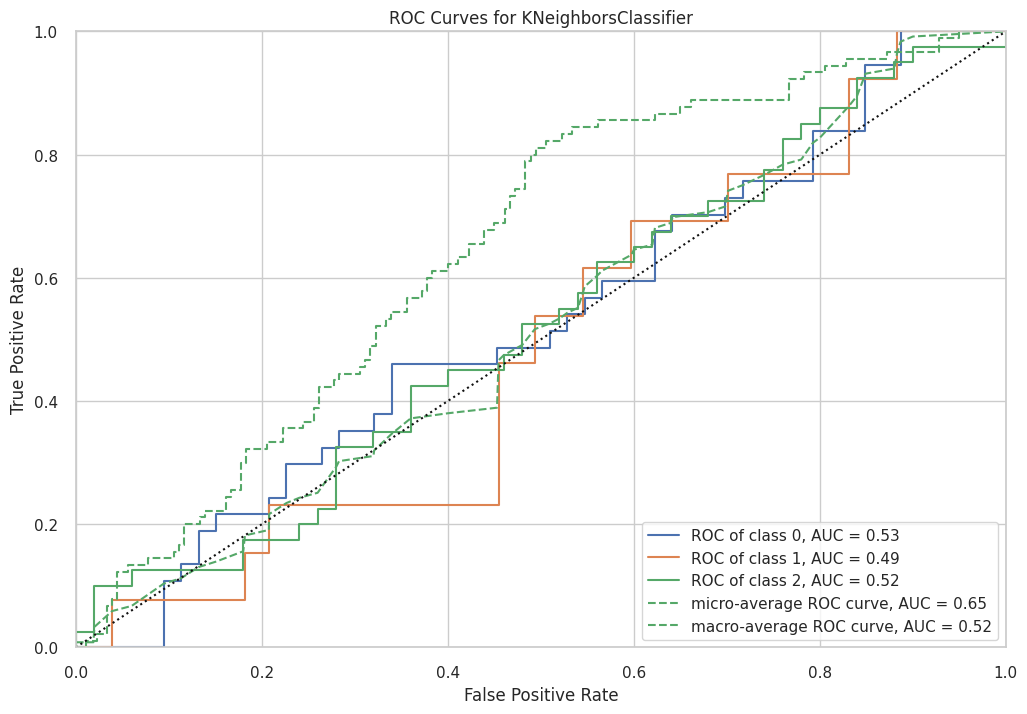

No se pudo generar gráfico de importancia de características con plot_model
Error al generar importancia de características: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- valoracion_llm
Feature names seen at fit time, yet now missing:
- valoracion_llm_negative
- valoracion_llm_neutral
- valoracion_llm_positive

Guardando modelo en resultados_20250504_155841/models/modelo_12_KNeighborsClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando LogisticRegression...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando LogisticRegression...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.6667  0.0  0.6667  0.5833  0.6190  0.4167  0.4348
1       0.4286  0.0  0.4286  0.3571  0.3752  0.0233  0.0253
2       0.4286  0.0  0.4286  0.4620  0.4393  0.0667  0.0677
3       0.5238  0.0  0.5238  0.5039  0.5016  0.1860  0.1961
4       0.5714  0.0  0.5714  0.6143  0.5677  0.2674  0.2711
5       0.3810  0.0  0.3810  0.3980  0.3811 -0.0341 -0.0351
6       0.4286  0.0  0.4286  0.3929  0.4058  0.0233  0.0240
7       0.1905  0.0  0.1905  0.2037  0.1955 -0.2888 -0.2920
8       0.4286  0.0  0.4286  0.3469  0.3760  0.0270  0.0299
9       0.4500  0.0  0.4500  0.3818  0.4105  0.0476  0.0498
Mean    0.4498  0.0  0.4498  0.4244  0.4272  0.0735  0.0771
Std     0.1188  0.0  0.1188  0.1148  0.1114  0.1786  0.1836
Generando visualizaciones para LogisticRegression...


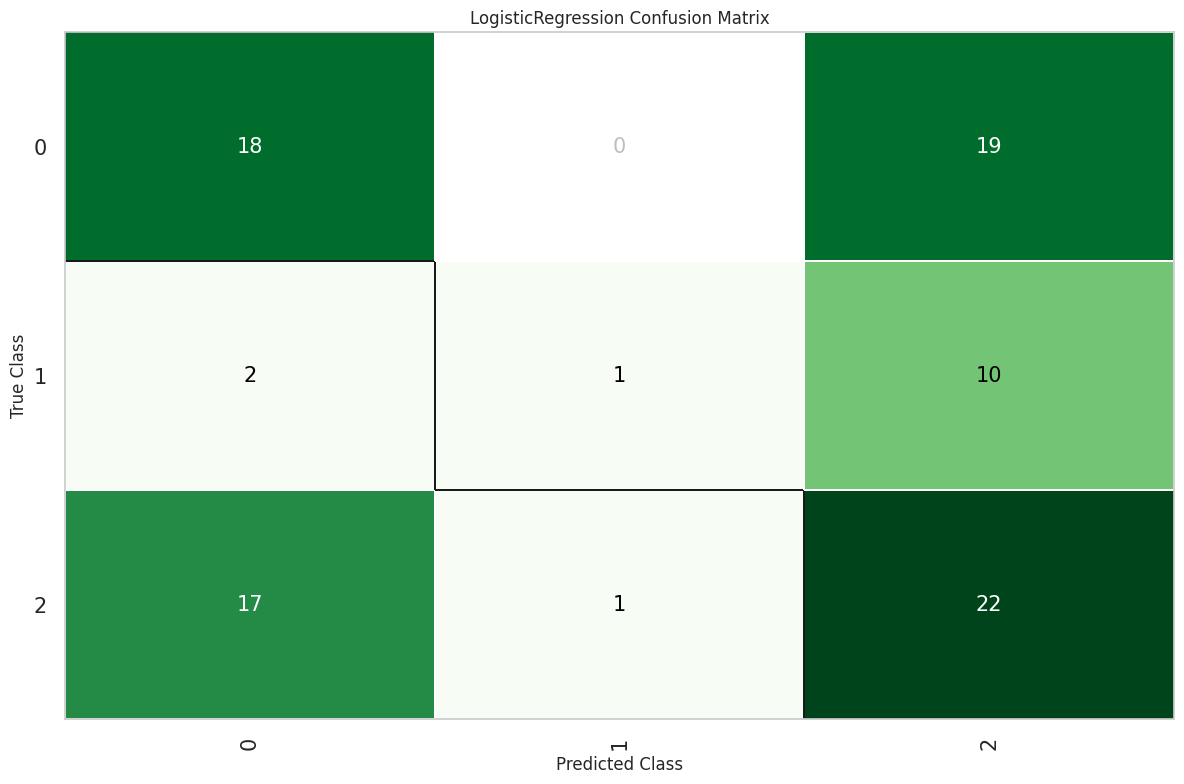

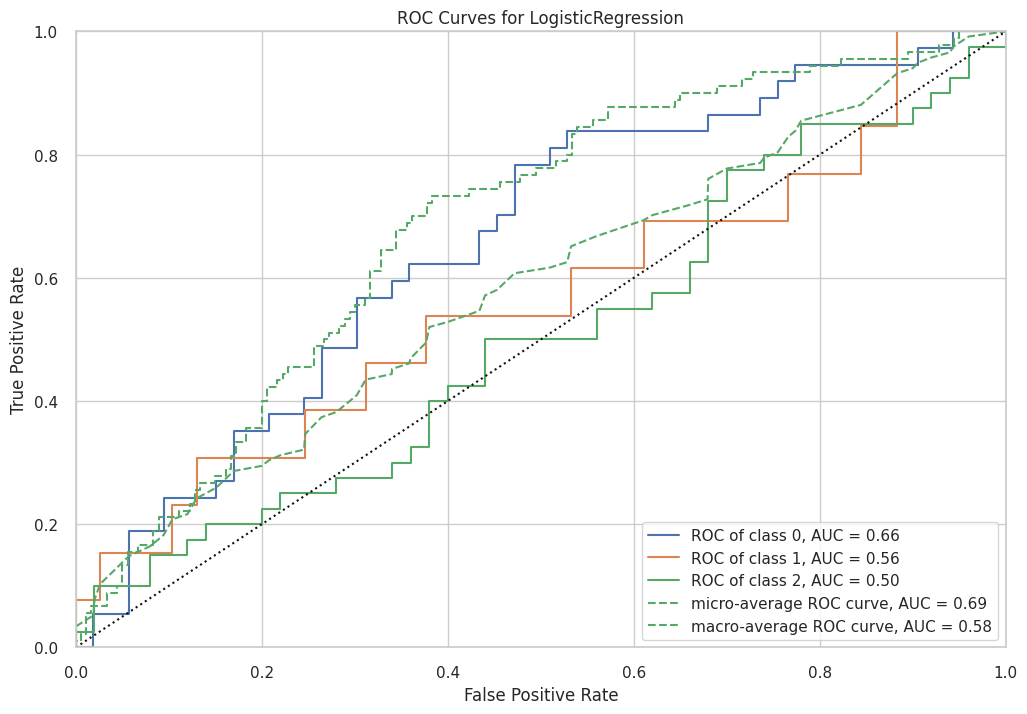

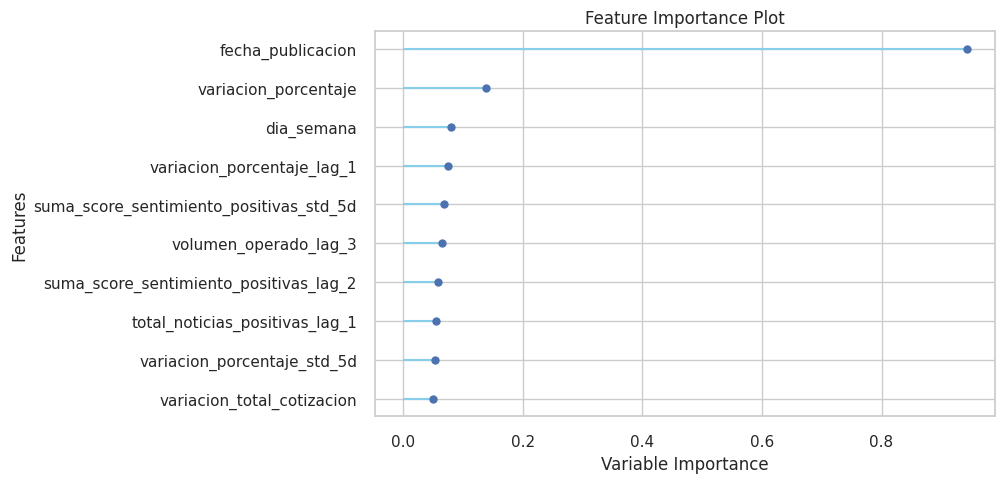

Guardando modelo en resultados_20250504_155841/models/modelo_12_LogisticRegression...
Transformation Pipeline and Model Successfully Saved
Evaluando SGDClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando SGDClassifier...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.6190  0.0  0.6190  0.5510  0.5660  0.3333  0.3651
1       0.4762  0.0  0.4762  0.4144  0.4334  0.1047  0.1103
2       0.4286  0.0  0.4286  0.3766  0.4000  0.0233  0.0237
3       0.5714  0.0  0.5714  0.5195  0.5429  0.2674  0.2722
4       0.5238  0.0  0.5238  0.4657  0.4859  0.1667  0.1772
5       0.4286  0.0  0.4286  0.3853  0.4048  0.0233  0.0237
6       0.5238  0.0  0.5238  0.4719  0.4952  0.1860  0.1894
7       0.4286  0.0  0.4286  0.3766  0.3985  0.0040  0.0041
8       0.5238  0.0  0.5238  0.4429  0.4501  0.1829  0.2221
9       0.3000  0.0  0.3000  0.2683  0.2833 -0.1915 -0.1943
Mean    0.4824  0.0  0.4824  0.4272  0.4460  0.1100  0.1193
Std     0.0859  0.0  0.0859  0.0774  0.0778  0.1436  0.1525
Generando visualizaciones para SGDClassifier...


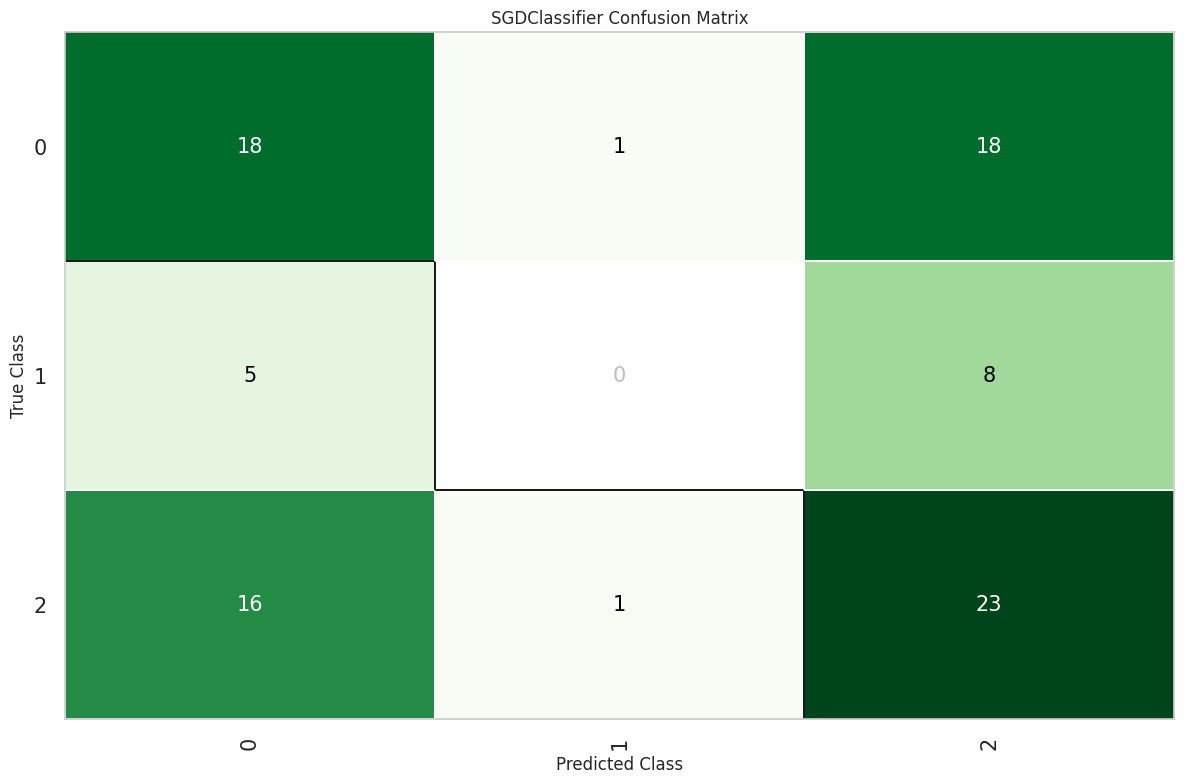

No se pudo generar curva AUC para este modelo


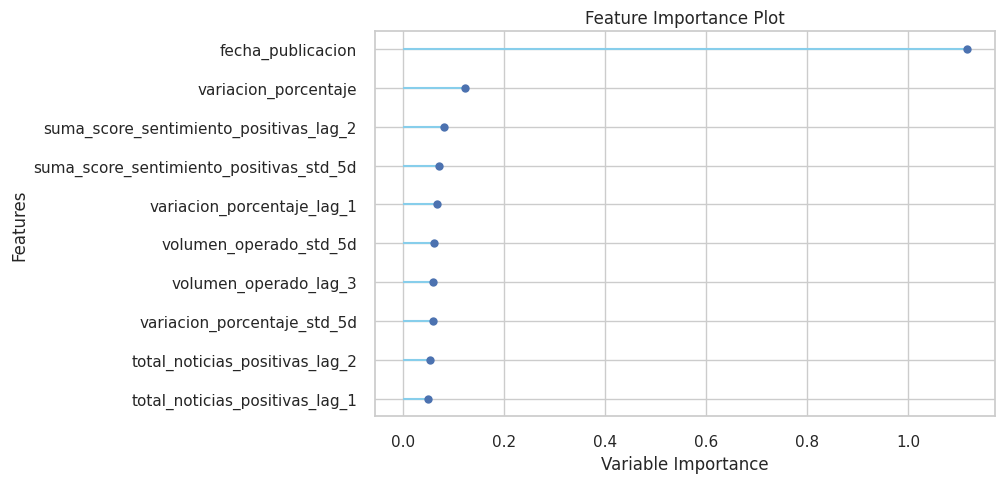

Guardando modelo en resultados_20250504_155841/models/modelo_12_SGDClassifier...
Transformation Pipeline and Model Successfully Saved
Modelado completo para la empresa 12
Completado modelar_empresa en 107.75 segundos
Empresa 12 procesada en 1.80 minutos
Procesando empresa 13...
Iniciando modelar_empresa
Modelado para la empresa 13
Número de registros para la empresa 13: 299
Distribución de clases:
label
SUBE        149
BAJA        136
MANTIENE     14
Name: count, dtype: int64
Configurando ambiente PyCaret...
                    Description                          Value
0                    Session id                             42
1                        Target                          label
2                   Target type                     Multiclass
3                Target mapping  BAJA: 0, MANTIENE: 1, SUBE: 2
4           Original data shape                      (299, 73)
5        Transformed data shape                      (299, 73)
6   Transformed train set shape              

                                   Model  Accuracy     AUC  Recall   Prec.  \
et                Extra Trees Classifier    0.4689  0.4985  0.4689  0.4859   
lr                   Logistic Regression    0.4589  0.0000  0.4589  0.4781   
svm                  SVM - Linear Kernel    0.4402  0.0000  0.4402  0.4809   
rf              Random Forest Classifier    0.4639  0.5087  0.4639  0.4364   
knn               K Neighbors Classifier    0.4401  0.4683  0.4401  0.4321   
ridge                   Ridge Classifier    0.4879  0.0000  0.4879  0.3853   
dummy                   Dummy Classifier    0.4976  0.5000  0.4976  0.2476   
qda      Quadratic Discriminant Analysis    0.2099  0.0000  0.2099  0.2467   
nb                           Naive Bayes    0.1579  0.5017  0.1579  0.2586   
xgboost        Extreme Gradient Boosting    0.1335  0.4694  0.1335  0.1311   
dt              Decision Tree Classifier    0.0478  0.5000  0.0478  0.0023   
ada                 Ada Boost Classifier    0.0478  0.0000  0.04

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando ExtraTreesClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.4762  0.6097  0.4762  0.2268  0.3072  0.0000  0.0000
1       0.4286  0.5190  0.4286  0.2143  0.2857 -0.0909 -0.2143
2       0.4762  0.5580  0.4762  0.4637  0.3749  0.0000  0.0000
3       0.4762  0.6955  0.4762  0.2268  0.3072  0.0000  0.0000
4       0.4762  0.3405  0.4762  0.4637  0.3749  0.0000  0.0000
5       0.5238  0.4659  0.5238  0.2744  0.3601  0.0000  0.0000
6       0.5238  0.4444  0.5238  0.2744  0.3601  0.0000  0.0000
7       0.4762  0.5587  0.4762  0.2619  0.3379 -0.0896 -0.1947
8       0.5714  0.4714  0.5714  0.5767  0.5041  0.1250  0.1684
9       0.5000  0.4999  0.5000  0.2500  0.3333  0.0000  0.0000
Mean    0.4929  0.5163  0.4929  0.3232  0.3546 -0.0056 -0.0241
Std     0.0370  0.0923  0.0370  

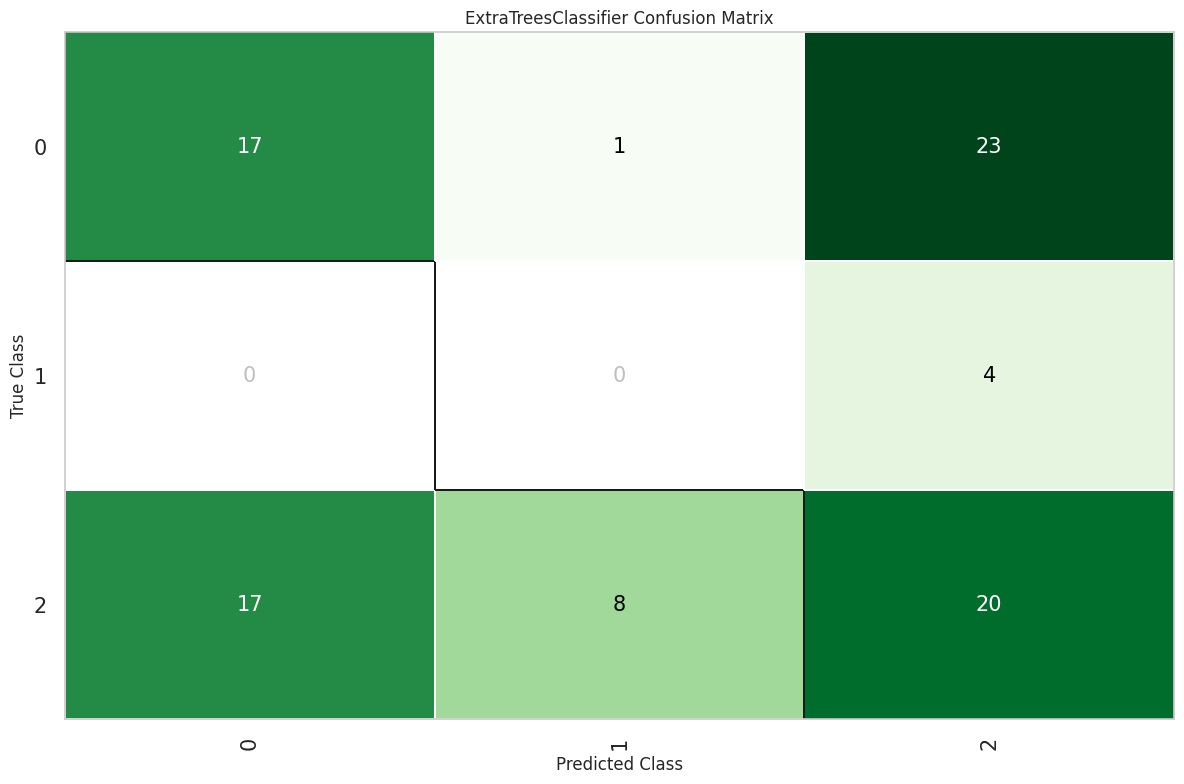

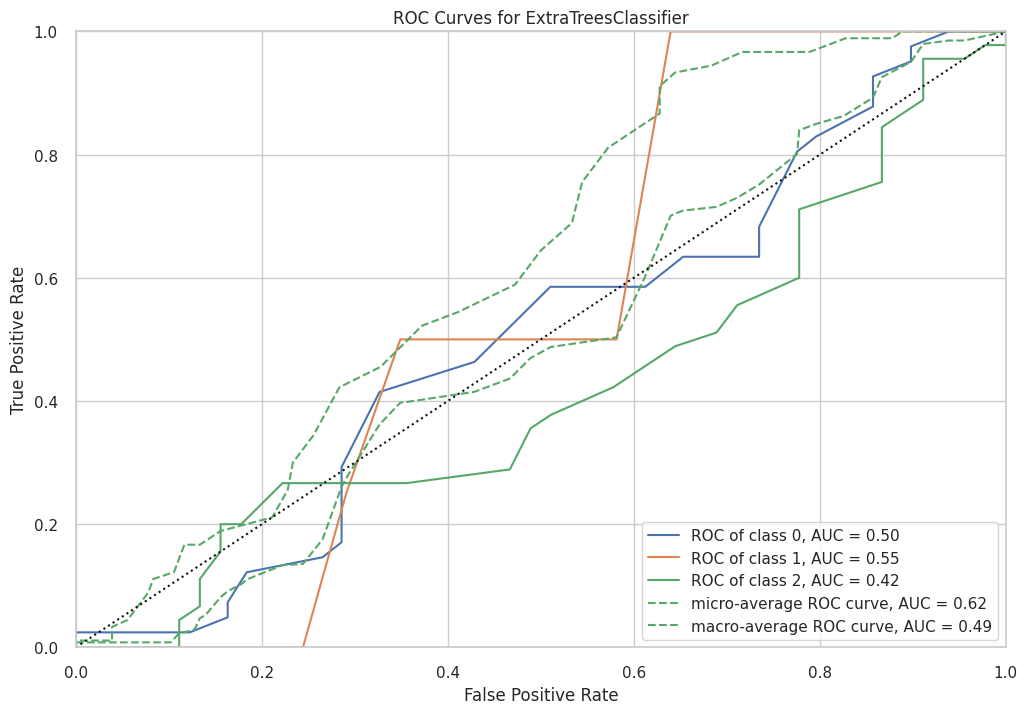

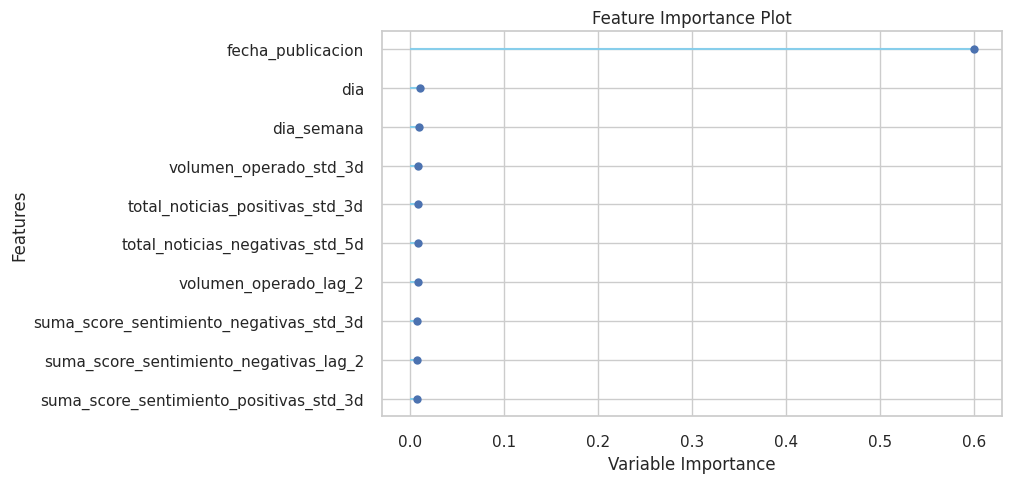

Guardando modelo en resultados_20250504_155841/models/modelo_13_ExtraTreesClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando LogisticRegression...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando LogisticRegression...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.3333  0.0  0.3333  0.3752  0.3458 -0.1011 -0.1065
1       0.3810  0.0  0.3810  0.5403  0.4111 -0.0225 -0.0250
2       0.4762  0.0  0.4762  0.6522  0.5253  0.2376  0.2720
3       0.5714  0.0  0.5714  0.5979  0.5840  0.2410  0.2421
4       0.4762  0.0  0.4762  0.5556  0.4824  0.1630  0.1815
5       0.2857  0.0  0.2857  0.2262  0.2413 -0.1413 -0.1592
6       0.1905  0.0  0.1905  0.1905  0.1905 -0.2483 -0.2843
7       0.3333  0.0  0.3333  0.2821  0.3056 -0.0426 -0.0522
8       0.3333  0.0  0.3333  0.5238  0.3810 -0.0280 -0.0320
9       0.4000  0.0  0.4000  0.5028  0.4432  0.0438  0.0464
Mean    0.3781  0.0  0.3781  0.4446  0.3910  0.0102  0.0083
Std     0.1034  0.0  0.1034  0.1553  0.1178  0.1539  0.1700
Generando v

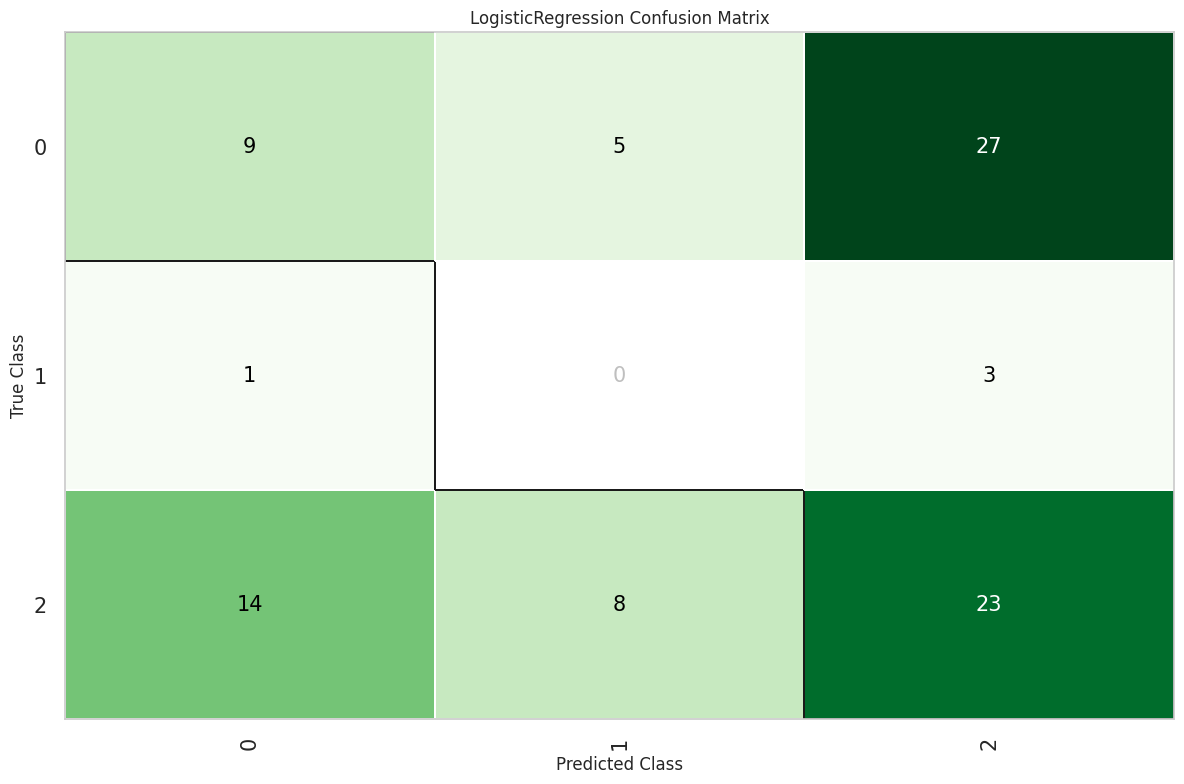

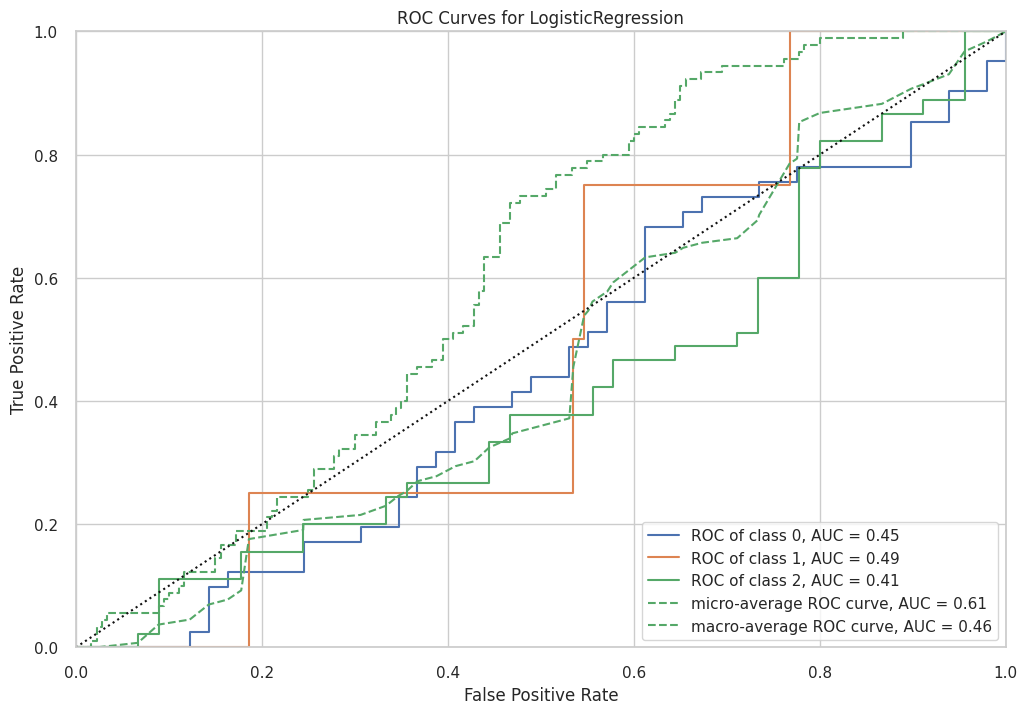

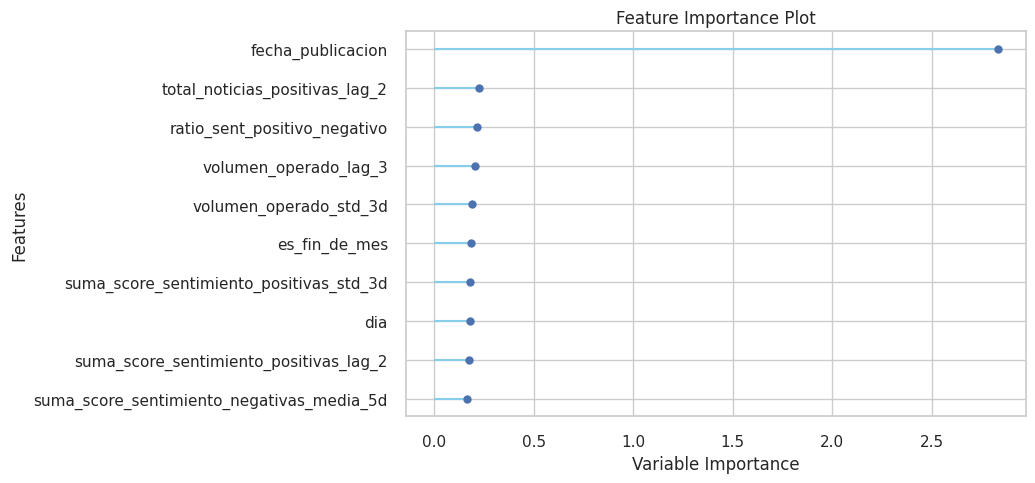

Guardando modelo en resultados_20250504_155841/models/modelo_13_LogisticRegression...
Transformation Pipeline and Model Successfully Saved
Evaluando SGDClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando SGDClassifier...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.5238  0.0  0.5238  0.5026  0.5104  0.0909  0.0922
1       0.6667  0.0  0.6667  0.6825  0.6405  0.3636  0.4041
2       0.5238  0.0  0.5238  0.4945  0.5015  0.0909  0.0940
3       0.6190  0.0  0.6190  0.5952  0.6038  0.2727  0.2767
4       0.5238  0.0  0.5238  0.4945  0.5015  0.0909  0.0940
5       0.3810  0.0  0.3810  0.3469  0.3586 -0.2187 -0.2269
6       0.2381  0.0  0.2381  0.2222  0.2298 -0.4737 -0.4763
7       0.5238  0.0  0.5238  0.4963  0.5072  0.0708  0.0719
8       0.4762  0.0  0.4762  0.4567  0.4637  0.0043  0.0044
9       0.4000  0.0  0.4000  0.3643  0.3700 -0.1650 -0.1777
Mean    0.4876  0.0  0.4876  0.4656  0.4687  0.0127  0.0156
Std     0.1166  0.0  0.1166  0.1231  0.1149  0.2311  0.2406
Generando visualizaciones para SGDClassifier...


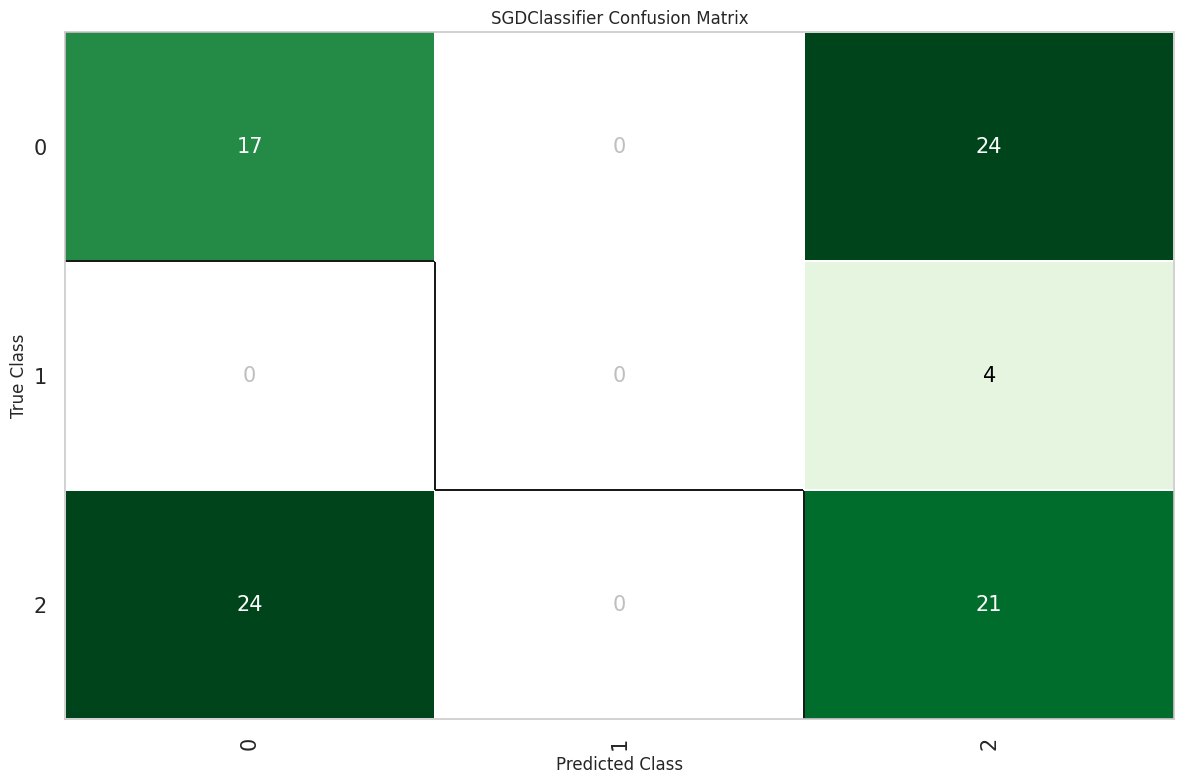

No se pudo generar curva AUC para este modelo


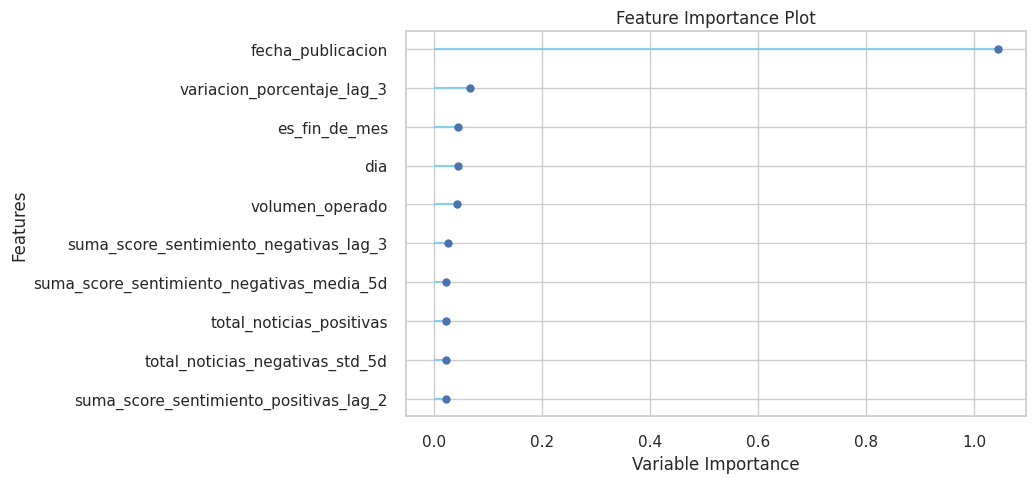

Guardando modelo en resultados_20250504_155841/models/modelo_13_SGDClassifier...
Transformation Pipeline and Model Successfully Saved
Modelado completo para la empresa 13
Completado modelar_empresa en 146.92 segundos
Empresa 13 procesada en 2.45 minutos
Procesando empresa 14...
Iniciando modelar_empresa
Modelado para la empresa 14
Número de registros para la empresa 14: 299
Distribución de clases:
label
SUBE        139
BAJA        137
MANTIENE     23
Name: count, dtype: int64
Configurando ambiente PyCaret...
                    Description                          Value
0                    Session id                             42
1                        Target                          label
2                   Target type                     Multiclass
3                Target mapping  BAJA: 0, MANTIENE: 1, SUBE: 2
4           Original data shape                      (299, 73)
5        Transformed data shape                      (299, 73)
6   Transformed train set shape              

                                   Model  Accuracy     AUC  Recall   Prec.  \
lr                   Logistic Regression    0.4542  0.0000  0.4542  0.4721   
svm                  SVM - Linear Kernel    0.4210  0.0000  0.4210  0.4416   
et                Extra Trees Classifier    0.3972  0.4770  0.3972  0.4001   
rf              Random Forest Classifier    0.4259  0.4924  0.4259  0.3937   
knn               K Neighbors Classifier    0.3493  0.3979  0.3493  0.3456   
ridge                   Ridge Classifier    0.4496  0.0000  0.4496  0.2312   
dummy                   Dummy Classifier    0.4594  0.5000  0.4594  0.2110   
qda      Quadratic Discriminant Analysis    0.1765  0.0000  0.1765  0.1659   
xgboost        Extreme Gradient Boosting    0.1538  0.5335  0.1538  0.1629   
nb                           Naive Bayes    0.1053  0.5004  0.1053  0.2770   
dt              Decision Tree Classifier    0.0765  0.5000  0.0765  0.0059   
ada                 Ada Boost Classifier    0.0765  0.0000  0.07

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando LogisticRegression...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.2381  0.0  0.2381  0.2476  0.2275 -0.2174 -0.2282
1       0.3810  0.0  0.3810  0.5086  0.3973  0.0990  0.1157
2       0.4762  0.0  0.4762  0.6190  0.5161  0.2143  0.2372
3       0.5714  0.0  0.5714  0.7449  0.5497  0.3177  0.3708
4       0.3810  0.0  0.3810  0.4824  0.3864  0.1136  0.1293
5       0.4286  0.0  0.4286  0.5159  0.4398  0.1280  0.1382
6       0.3810  0.0  0.3810  0.4259  0.4022 -0.0074 -0.0075
7       0.5238  0.0  0.5238  0.6310  0.5721  0.2473  0.2541
8       0.2857  0.0  0.2857  0.3469  0.3109 -0.1250 -0.1293
9       0.2000  0.0  0.2000  0.2554  0.2235 -0.2648 -0.2803
Mean    0.3867  0.0  0.3867  0.4778  0.4025  0.0505  0.0600
Std     0.1140  0.0  0.1140  0.1547  0.1166  0.1883  0.2047
Generando visualizaciones para LogisticRegression...


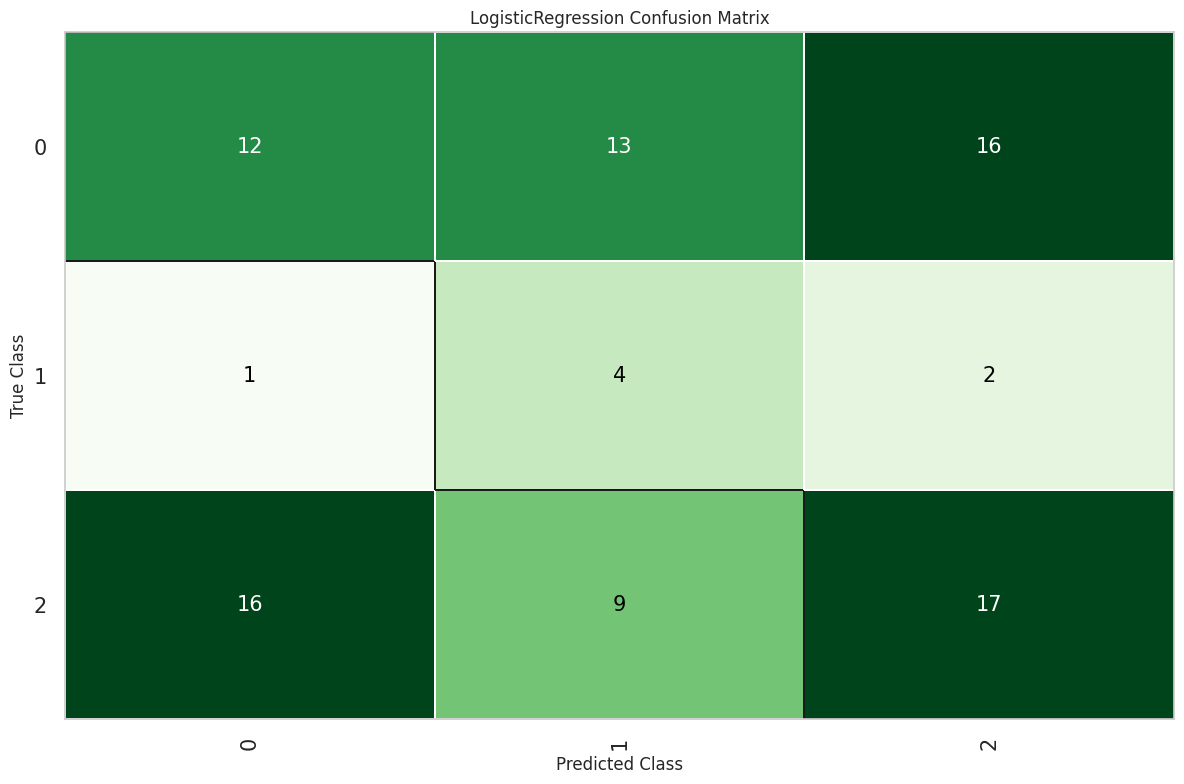

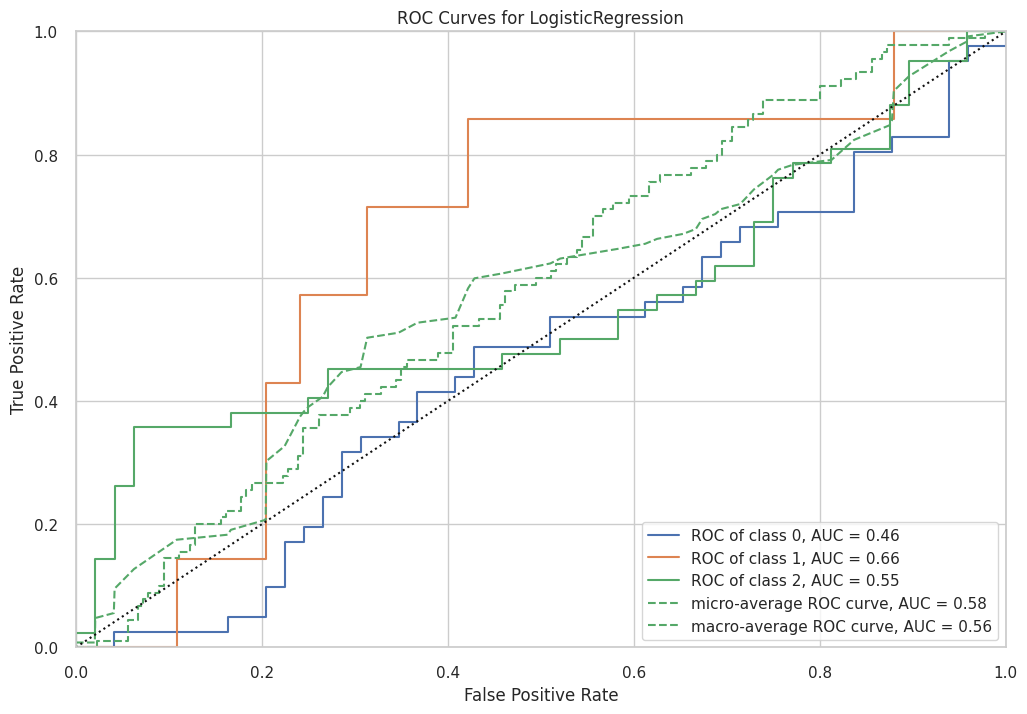

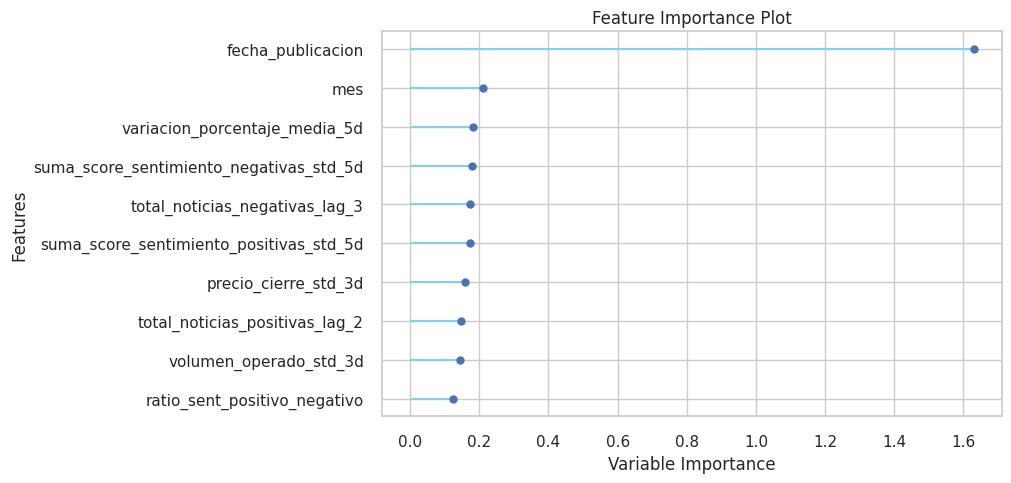

Guardando modelo en resultados_20250504_155841/models/modelo_14_LogisticRegression...
Transformation Pipeline and Model Successfully Saved
Evaluando SGDClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando SGDClassifier...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.4762  0.0  0.4762  0.4784  0.4701  0.0723  0.0732
1       0.3810  0.0  0.3810  0.4252  0.3844  0.0109  0.0115
2       0.6190  0.0  0.6190  0.6245  0.6138  0.3253  0.3294
3       0.5714  0.0  0.5714  0.6727  0.5812  0.3298  0.3537
4       0.4762  0.0  0.4762  0.5285  0.4921  0.1691  0.1737
5       0.2857  0.0  0.2857  0.2762  0.2807 -0.2651 -0.2663
6       0.3810  0.0  0.3810  0.3605  0.3669 -0.0748 -0.0760
7       0.5238  0.0  0.5238  0.5935  0.5153  0.1892  0.2065
8       0.1905  0.0  0.1905  0.1071  0.1371 -0.3574 -0.4480
9       0.5000  0.0  0.5000  0.4977  0.4975  0.0783  0.0787
Mean    0.4405  0.0  0.4405  0.4564  0.4339  0.0478  0.0436
Std     0.1247  0.0  0.1247  0.1630  0.1371  0.2171  0.2401
Generando visualizaciones para SGDClassifier...


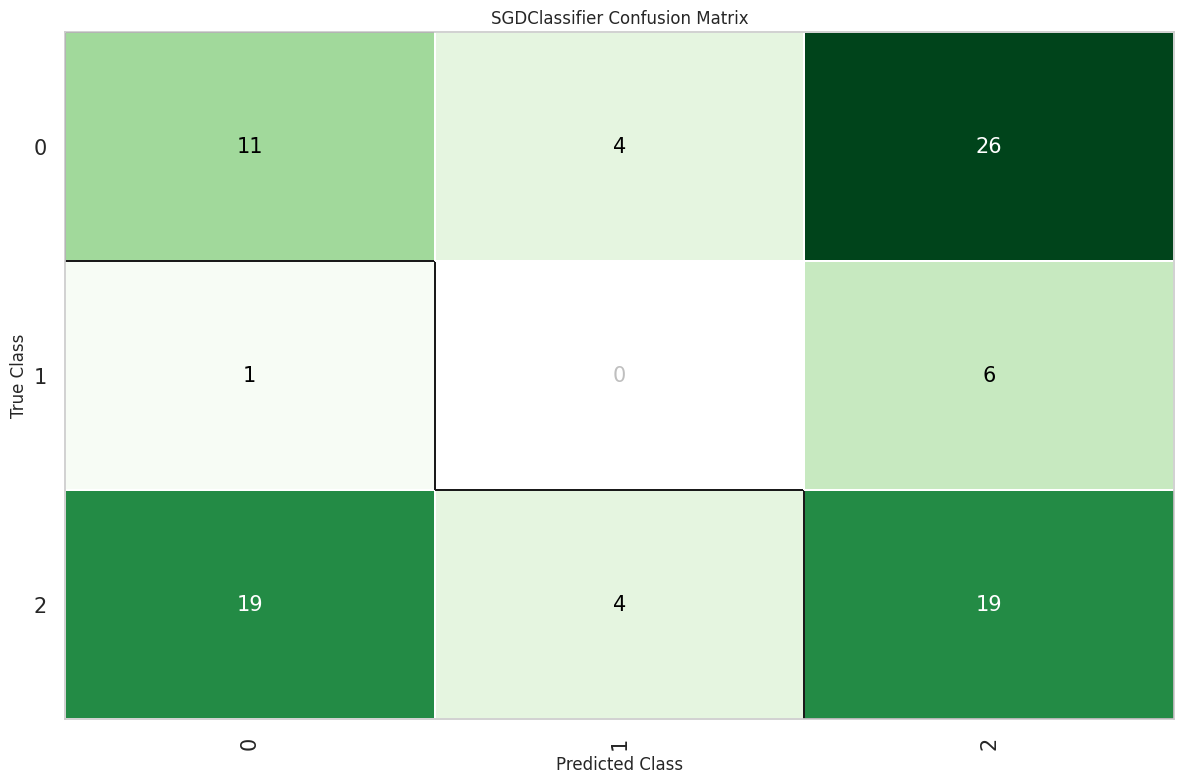

No se pudo generar curva AUC para este modelo


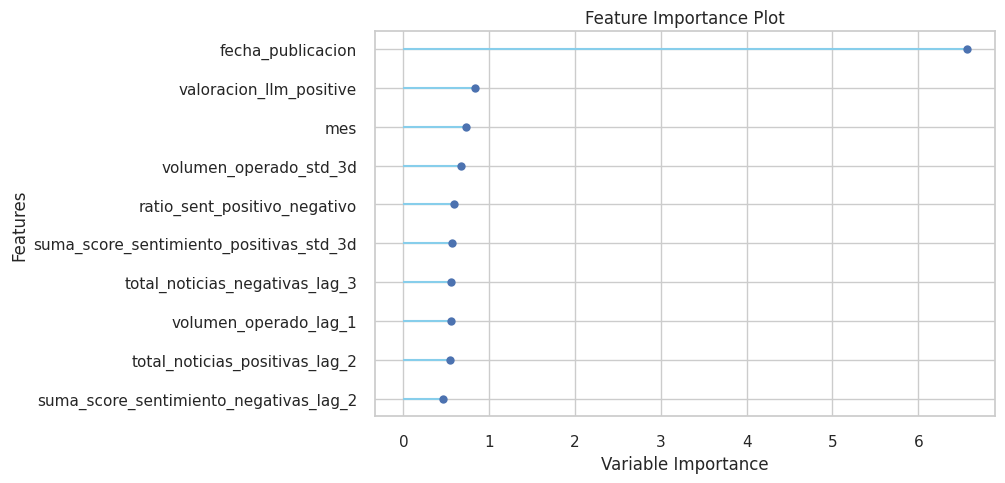

Guardando modelo en resultados_20250504_155841/models/modelo_14_SGDClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando ExtraTreesClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando ExtraTreesClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy  AUC  Recall   Prec.      F1  Kappa  MCC
Fold                                                   
0       0.4762  0.5  0.4762  0.2268  0.3072    0.0  0.0
1       0.4762  0.5  0.4762  0.2268  0.3072    0.0  0.0
2       0.4762  0.5  0.4762  0.2268  0.3072    0.0  0.0
3       0.4286  0.5  0.4286  0.1837  0.2571    0.0  0.0
4       0.4286  0.5  0.4286  0.1837  0.2571    0.0  0.0
5       0.4286  0.5  0.4286  0.1837  0.2571    0.0  0.0
6       0.4762  0.5  0.4762  0.2268  0.3072    0.0  0.0
7       0.4762  0.5  0.4762  0.2268  0.3072    0.0  0.0
8       0.4762  0.5  0.4762  0.2268  0.3072    0.0  0.0
9       0.5000  0.5  0.5000  0.2500  0.3333    0.0  0.0
Mean    0.4643  0.5  0.4643  0.2162  0.2948    0.0  0.0
Std     0.0244  0.0  0.0244  0.0223  0.0258    0.0  0.0
Generando visualizaciones para ExtraTreesClassifier...


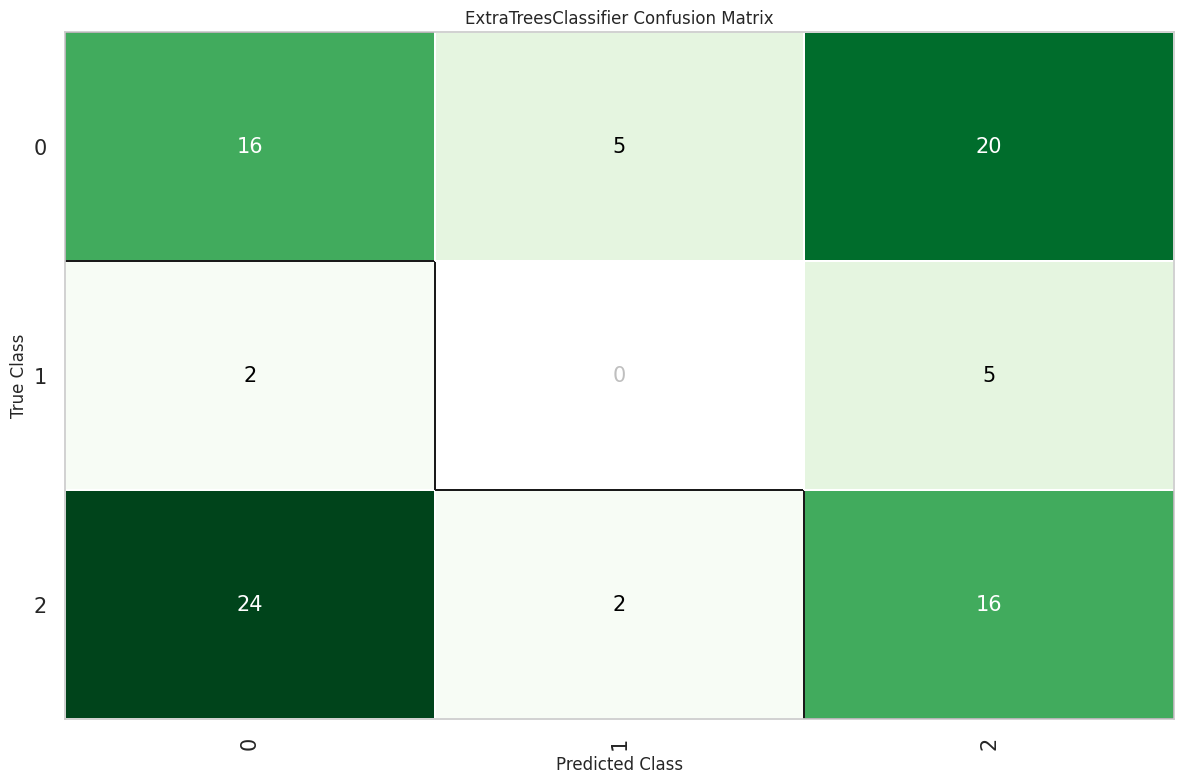

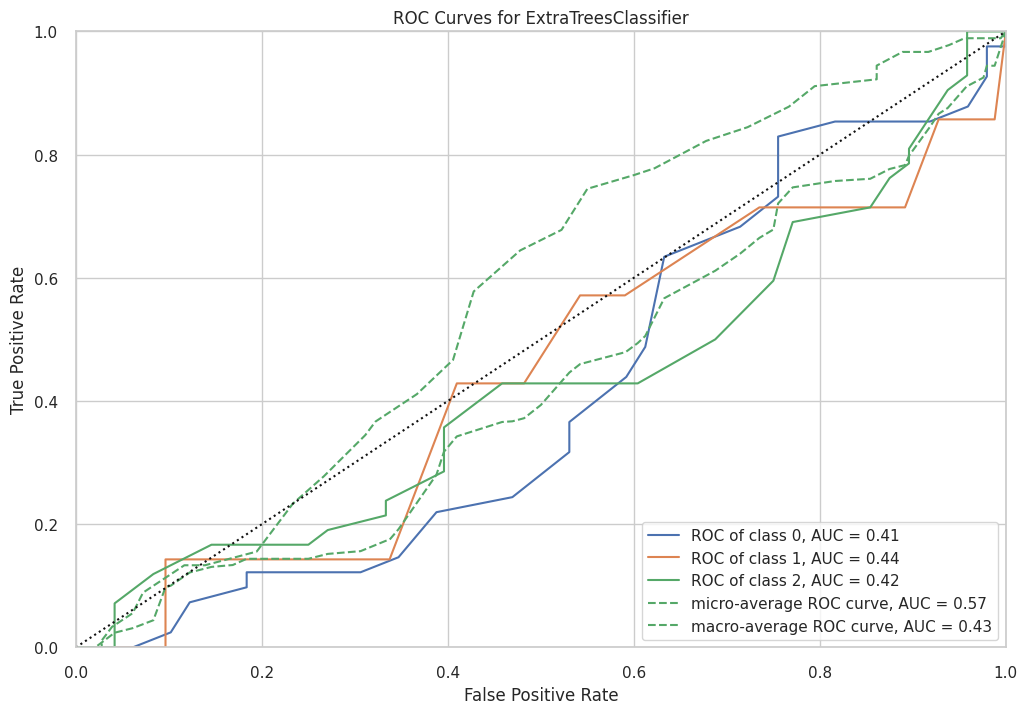

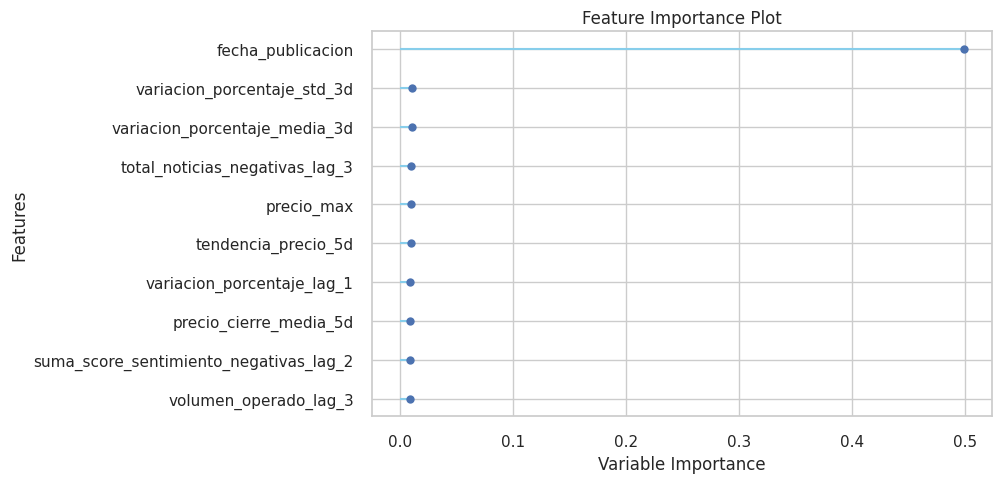

Guardando modelo en resultados_20250504_155841/models/modelo_14_ExtraTreesClassifier...
Transformation Pipeline and Model Successfully Saved
Modelado completo para la empresa 14
Completado modelar_empresa en 145.39 segundos
Empresa 14 procesada en 2.42 minutos
Procesando empresa 15...
Iniciando modelar_empresa
Modelado para la empresa 15
Número de registros para la empresa 15: 299
Distribución de clases:
label
SUBE        152
BAJA        143
MANTIENE      4
Name: count, dtype: int64
Configurando ambiente PyCaret...
                    Description                          Value
0                    Session id                             42
1                        Target                          label
2                   Target type                     Multiclass
3                Target mapping  BAJA: 0, MANTIENE: 1, SUBE: 2
4           Original data shape                      (299, 73)
5        Transformed data shape                      (299, 73)
6   Transformed train set shape       

                                   Model  Accuracy     AUC  Recall   Prec.  \
knn               K Neighbors Classifier    0.5215  0.5217  0.5215  0.5140   
et                Extra Trees Classifier    0.5026  0.5278  0.5026  0.5007   
svm                  SVM - Linear Kernel    0.4975  0.0000  0.4975  0.4942   
lr                   Logistic Regression    0.4977  0.0000  0.4977  0.4959   
xgboost        Extreme Gradient Boosting    0.4301  0.4697  0.4301  0.4681   
rf              Random Forest Classifier    0.4930  0.5600  0.4930  0.4990   
ridge                   Ridge Classifier    0.5119  0.0000  0.5119  0.4159   
dummy                   Dummy Classifier    0.5072  0.5000  0.5072  0.2573   
qda      Quadratic Discriminant Analysis    0.2683  0.0000  0.2683  0.2579   
nb                           Naive Bayes    0.1681  0.4926  0.1681  0.2283   
dt              Decision Tree Classifier    0.0144  0.5000  0.0144  0.0002   
ada                 Ada Boost Classifier    0.0144  0.0000  0.01

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando KNeighborsClassifier...


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.4762  0.0000  0.4762  0.4660  0.4614 -0.0645 -0.0674
1       0.7143  0.0000  0.7143  0.7198  0.7103  0.4220  0.4301
2       0.6667  0.0000  0.6667  0.6697  0.6667  0.3348  0.3364
3       0.4762  0.0000  0.4762  0.4660  0.4614 -0.0645 -0.0674
4       0.3810  0.0000  0.3810  0.3796  0.3725 -0.2242 -0.2337
5       0.5238  0.0000  0.5238  0.5238  0.5238  0.0455  0.0455
6       0.6190  0.6721  0.6190  0.6032  0.5810  0.2727  0.3031
7       0.3333  0.2768  0.3333  0.3160  0.3243 -0.2727 -0.2742
8       0.4286  0.4397  0.4286  0.4069  0.4172 -0.0909 -0.0914
9       0.6500  0.0000  0.6500  0.6515  0.6491  0.3000  0.3015
Mean    0.5269  0.1389  0.5269  0.5202  0.5168  0.0658  0.0682
Std     0.1232  0.2300  0.1232  0.1290  0.1247  0.2355  0.2416
Generando visualizaciones para KNeighborsClassifier...


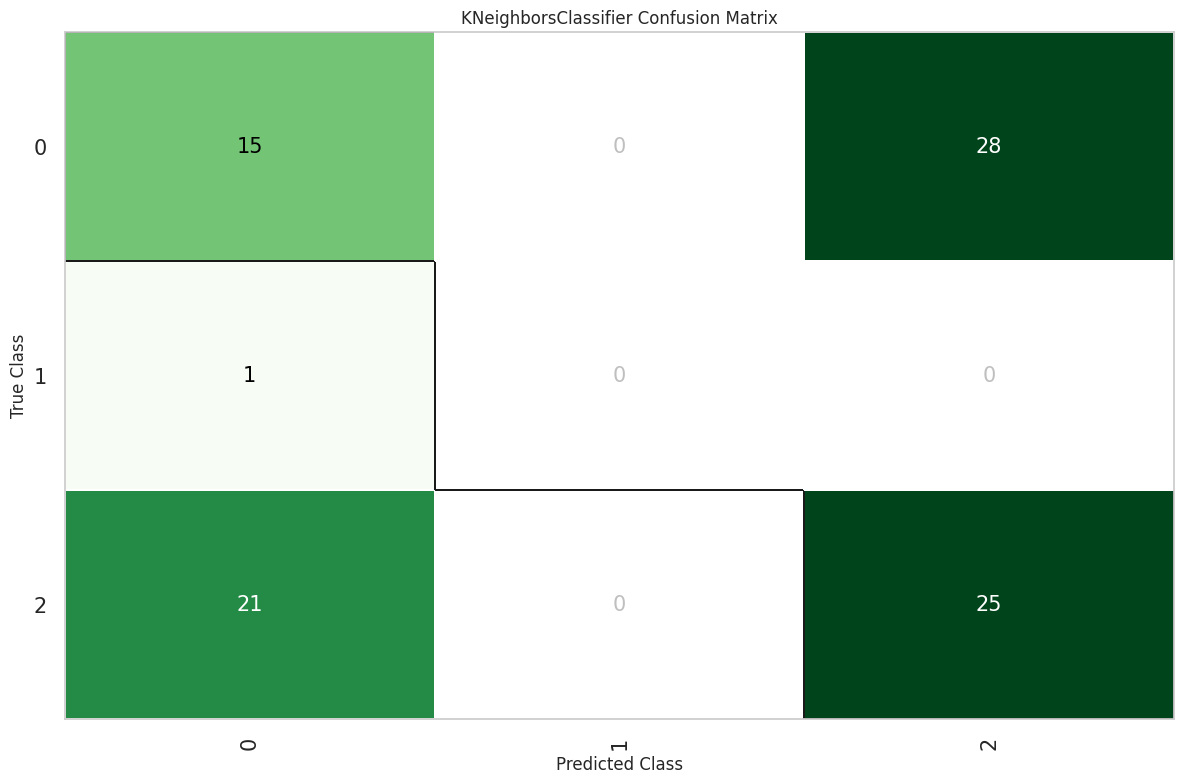

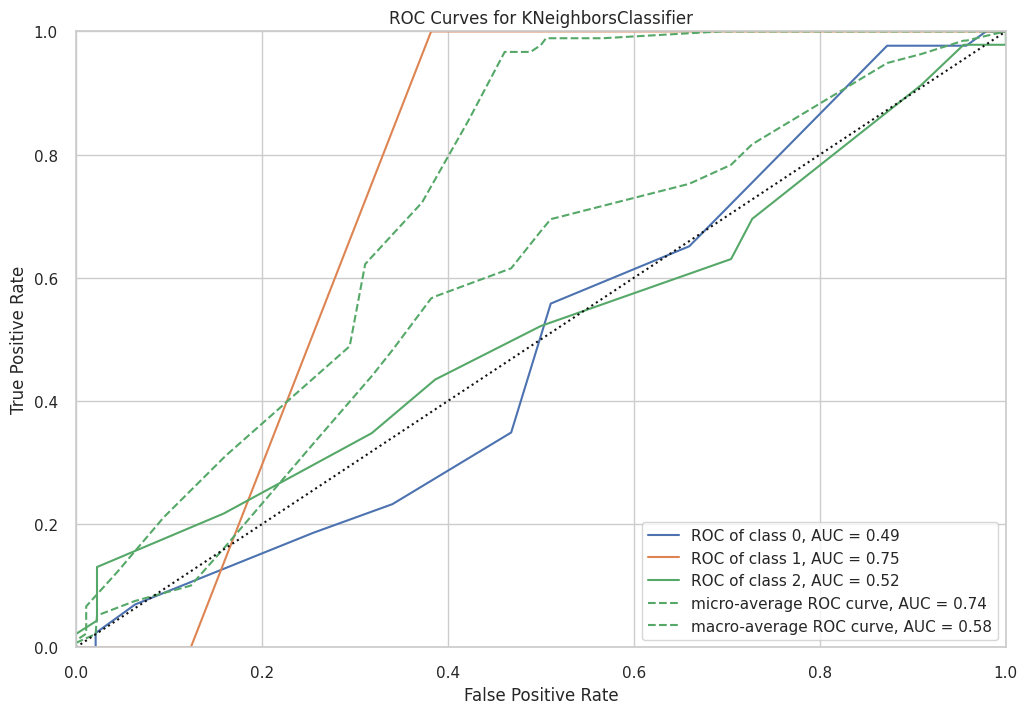

No se pudo generar gráfico de importancia de características con plot_model
Error al generar importancia de características: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- valoracion_llm
Feature names seen at fit time, yet now missing:
- valoracion_llm_negative
- valoracion_llm_neutral
- valoracion_llm_positive

Guardando modelo en resultados_20250504_155841/models/modelo_15_KNeighborsClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando ExtraTreesClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando ExtraTreesClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.5238  0.0000  0.5238  0.5948  0.4833  0.0625  0.0792
1       0.5714  0.0000  0.5714  0.7794  0.4707  0.1486  0.2519
2       0.5238  0.0000  0.5238  0.2881  0.3717  0.0498  0.1173
3       0.4762  0.0000  0.4762  0.2910  0.3612  0.0494  0.0778
4       0.4762  0.0000  0.4762  0.5000  0.4465 -0.0267 -0.0312
5       0.4762  0.0000  0.4762  0.2619  0.3379 -0.0948 -0.2132
6       0.4762  0.4082  0.4762  0.2268  0.3072  0.0000  0.0000
7       0.4286  0.4455  0.4286  0.2143  0.2857 -0.0500 -0.1225
8       0.4762  0.5097  0.4762  0.2268  0.3072  0.0000  0.0000
9       0.5500  0.0000  0.5500  0.5980  0.4872  0.1000  0.1400
Mean    0.4979  0.1363  0.4979  0.3981  0.3859  0.0239  0.0299
Std     0.0408  0.2095  0.0408  

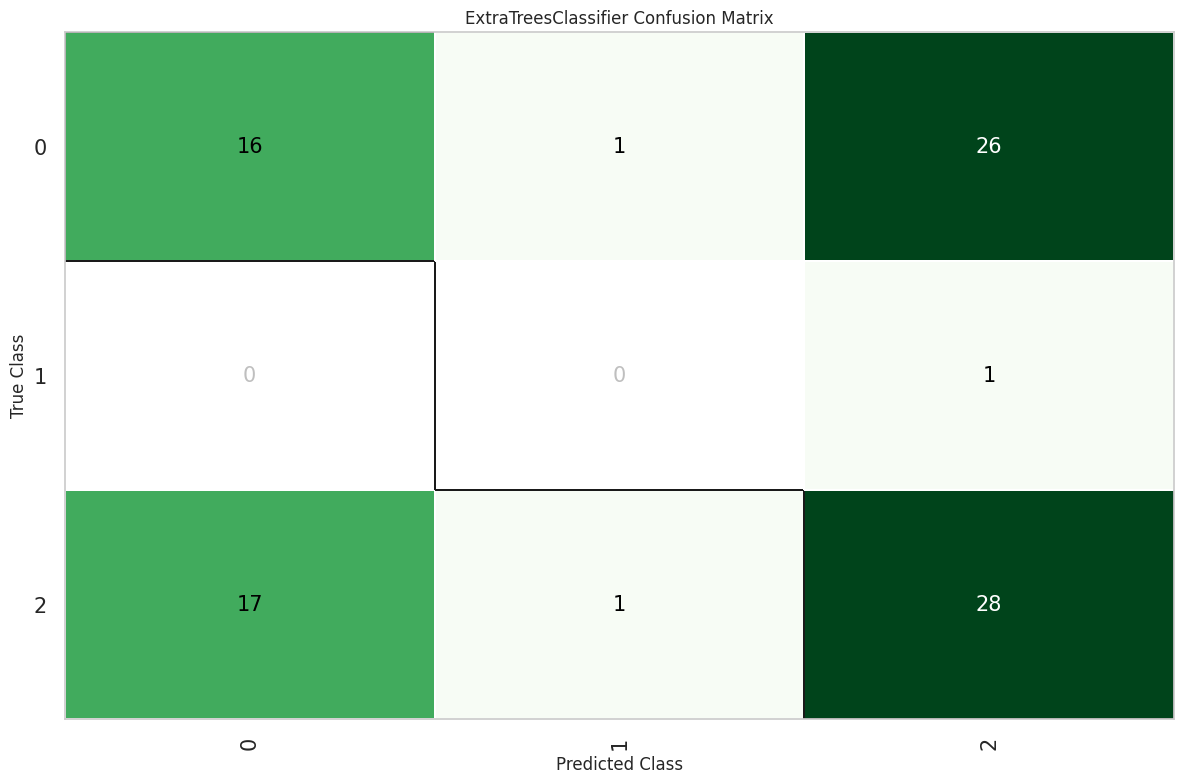

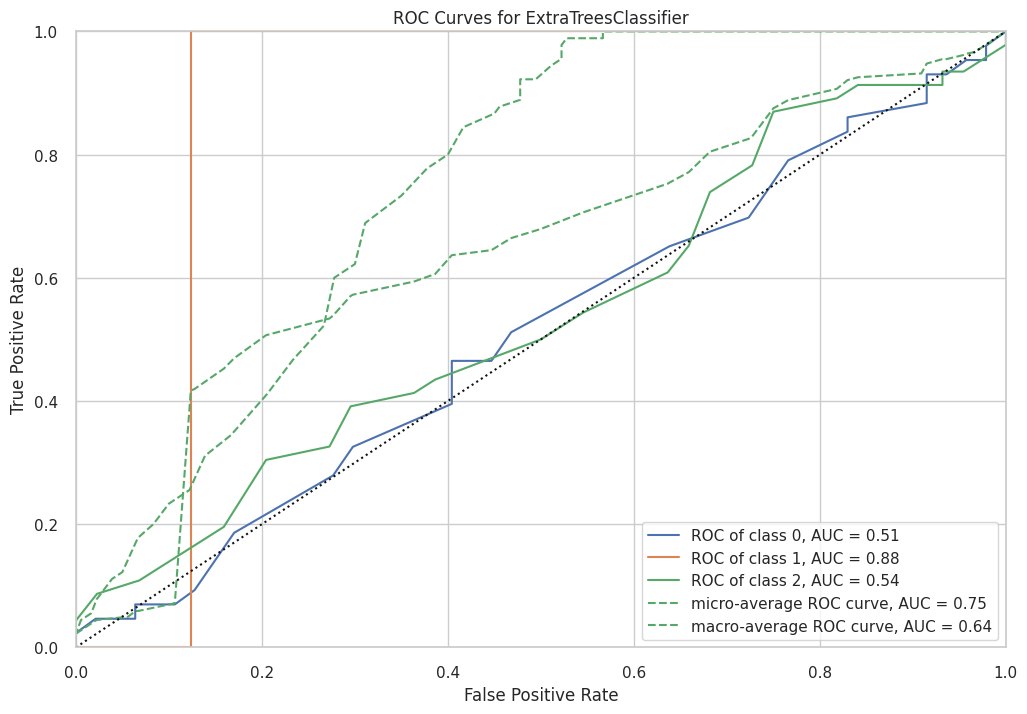

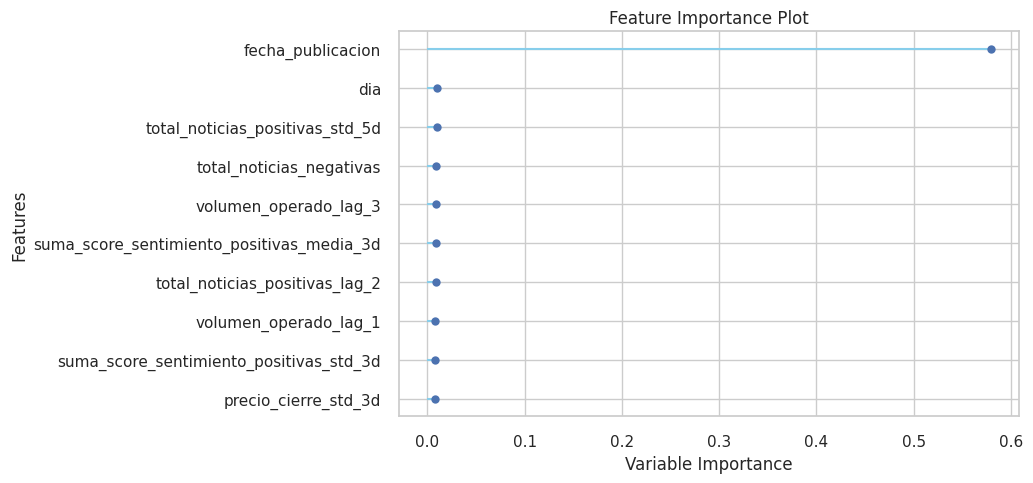

Guardando modelo en resultados_20250504_155841/models/modelo_15_ExtraTreesClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando SGDClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando SGDClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.3333  0.0  0.3333  0.3683  0.3499 -0.2199 -0.2233
1       0.5238  0.0  0.5238  0.5201  0.5172  0.0367  0.0374
2       0.5714  0.0  0.5714  0.6398  0.5873  0.2059  0.2169
3       0.3810  0.0  0.3810  0.3482  0.3396 -0.2133 -0.2497
4       0.4762  0.0  0.4762  0.5159  0.4444  0.0648  0.0771
5       0.3333  0.0  0.3333  0.3552  0.3386 -0.2618 -0.2700
6       0.6667  0.0  0.6667  0.6746  0.6638  0.3875  0.3941
7       0.3810  0.0  0.3810  0.3636  0.3719 -0.1818 -0.1828
8       0.3810  0.0  0.3810  0.3848  0.3819 -0.1375 -0.1381
9       0.3500  0.0  0.3500  0.3693  0.3571 -0.2381 -0.2417
Mean    0.4398  0.0  0.4398  0.4540  0.4352 -0.0558 -0.0580
Std     0.1088  0.0  0.1088  0.1182  0.1099  0.2093  0.2173
Generando v

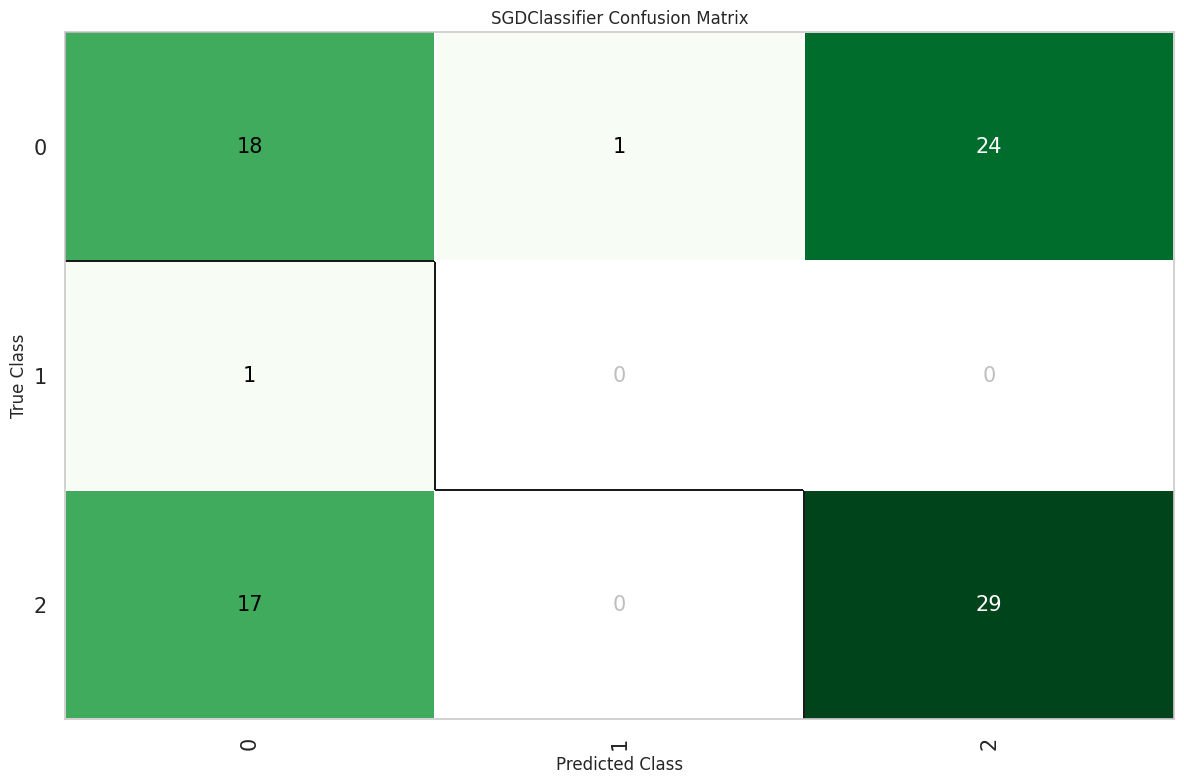

No se pudo generar curva AUC para este modelo


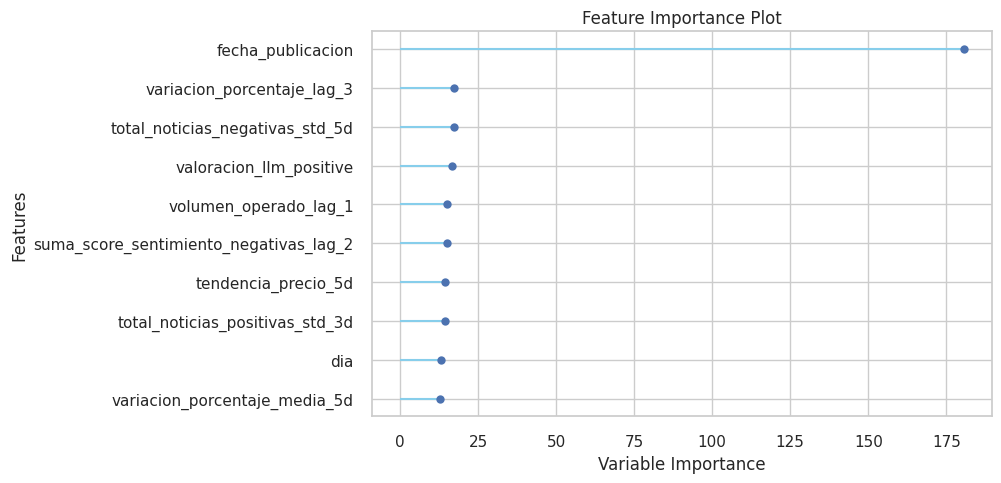

Guardando modelo en resultados_20250504_155841/models/modelo_15_SGDClassifier...
Transformation Pipeline and Model Successfully Saved
Modelado completo para la empresa 15
Completado modelar_empresa en 143.11 segundos
Empresa 15 procesada en 2.39 minutos
Procesando empresa 16...
Iniciando modelar_empresa
Modelado para la empresa 16
Número de registros para la empresa 16: 299
Distribución de clases:
label
SUBE        122
BAJA        120
MANTIENE     57
Name: count, dtype: int64
Configurando ambiente PyCaret...
                    Description                          Value
0                    Session id                             42
1                        Target                          label
2                   Target type                     Multiclass
3                Target mapping  BAJA: 0, MANTIENE: 1, SUBE: 2
4           Original data shape                      (299, 73)
5        Transformed data shape                      (299, 73)
6   Transformed train set shape              

                                   Model  Accuracy     AUC  Recall   Prec.  \
rf              Random Forest Classifier    0.3781  0.5268  0.3781  0.4894   
knn               K Neighbors Classifier    0.3829  0.4986  0.3829  0.3897   
lr                   Logistic Regression    0.2919  0.0000  0.2919  0.4292   
svm                  SVM - Linear Kernel    0.2963  0.0000  0.2963  0.3571   
et                Extra Trees Classifier    0.3061  0.5334  0.3061  0.4441   
ridge                   Ridge Classifier    0.3494  0.0000  0.3494  0.2721   
dummy                   Dummy Classifier    0.4019  0.5000  0.4019  0.1616   
qda      Quadratic Discriminant Analysis    0.2536  0.0000  0.2536  0.3032   
nb                           Naive Bayes    0.2009  0.5005  0.2009  0.1712   
dt              Decision Tree Classifier    0.1914  0.5000  0.1914  0.0367   
ada                 Ada Boost Classifier    0.1914  0.0000  0.1914  0.0367   
lda         Linear Discriminant Analysis    0.1914  0.0000  0.19

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando RandomForestClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1  Kappa  MCC
Fold                                                      
0       0.4286  0.4876  0.4286  0.1837  0.2571    0.0  0.0
1       0.4286  0.5282  0.4286  0.1837  0.2571    0.0  0.0
2       0.4286  0.6259  0.4286  0.1837  0.2571    0.0  0.0
3       0.4286  0.5448  0.4286  0.1837  0.2571    0.0  0.0
4       0.4286  0.7089  0.4286  0.1837  0.2571    0.0  0.0
5       0.4286  0.5329  0.4286  0.1837  0.2571    0.0  0.0
6       0.4286  0.4040  0.4286  0.1837  0.2571    0.0  0.0
7       0.4286  0.4657  0.4286  0.1837  0.2571    0.0  0.0
8       0.4286  0.4951  0.4286  0.1837  0.2571    0.0  0.0
9       0.4000  0.5307  0.4000  0.1600  0.2286    0.0  0.0
Mean    0.4257  0.5324  0.4257  0.1813  0.2543    0.0  0.0
Std     0.0086  0.0802  0.0086  0.0071  0.0086    0.0  0.0
Generando visualizaciones

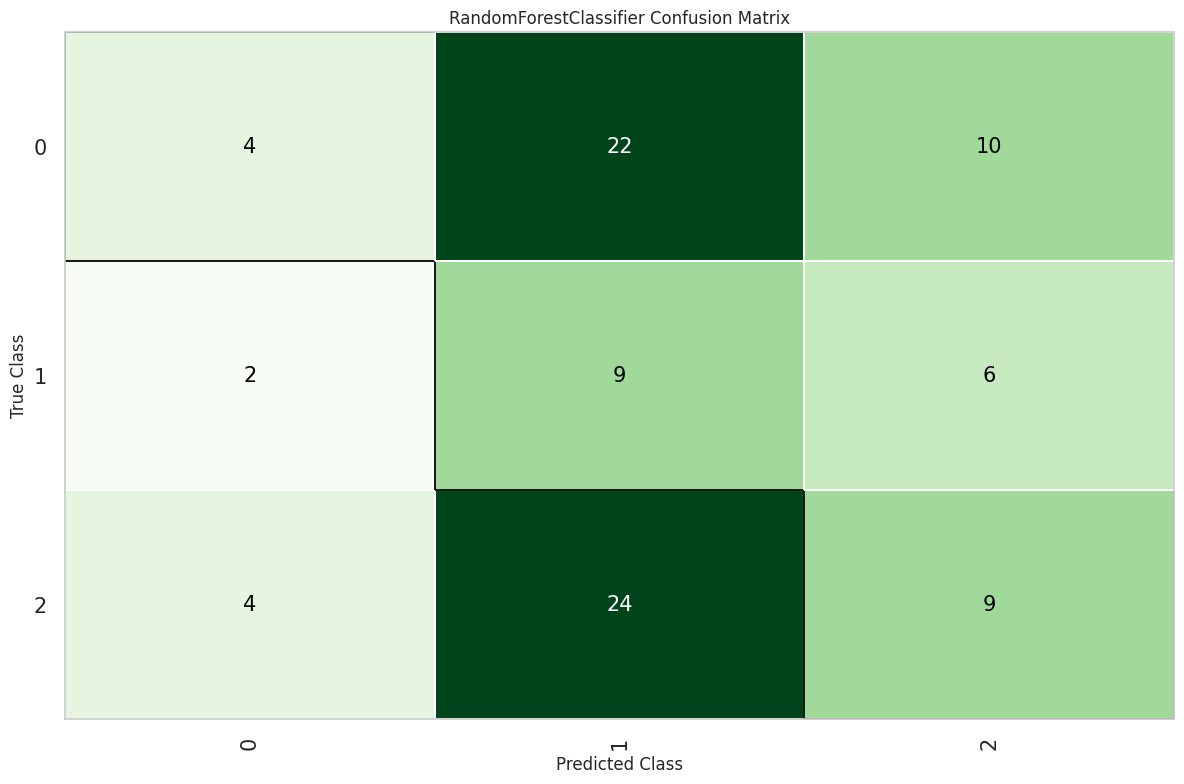

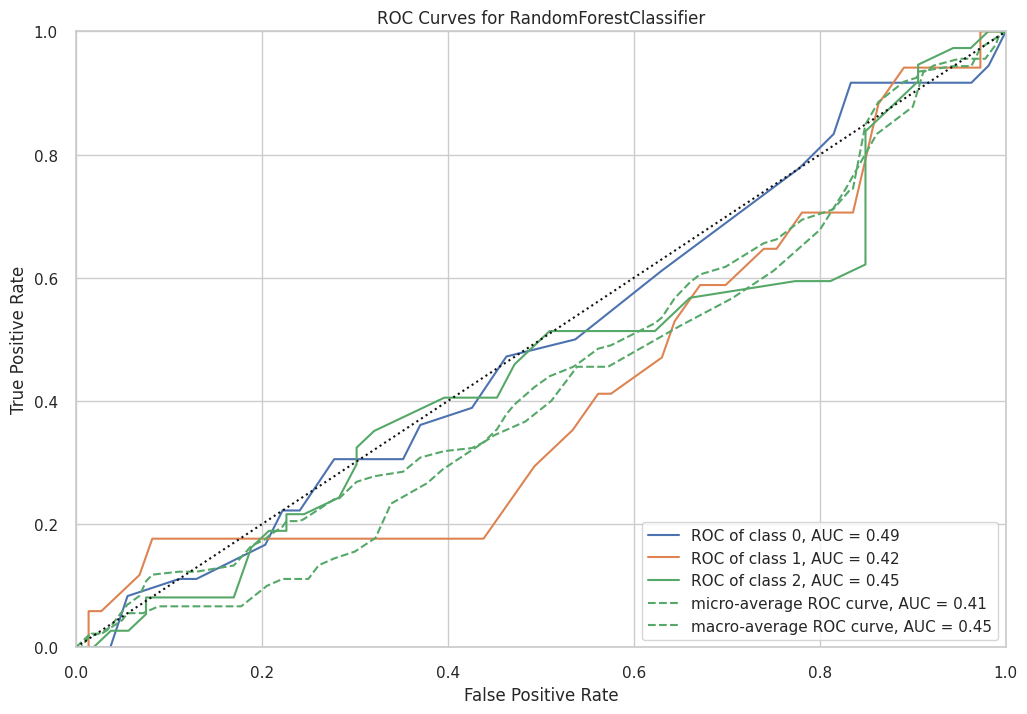

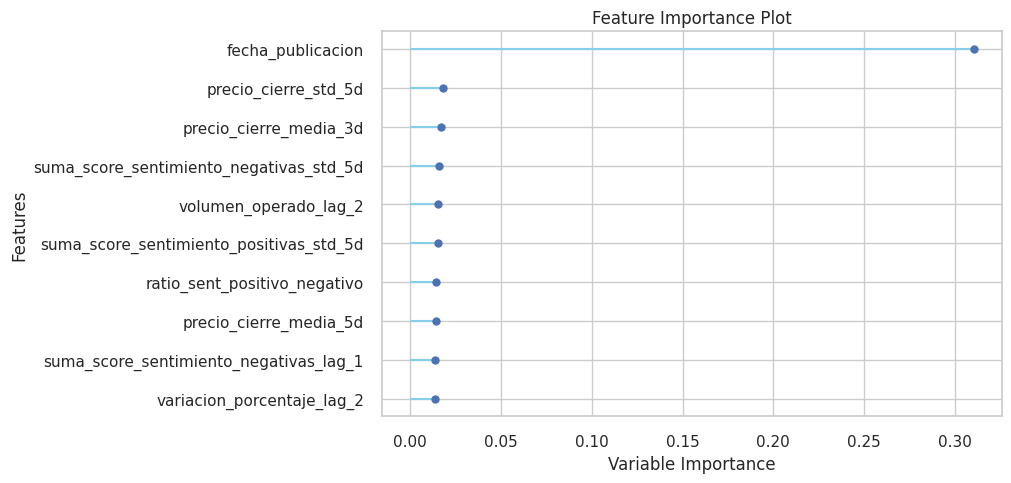

Guardando modelo en resultados_20250504_155841/models/modelo_16_RandomForestClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando KNeighborsClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando KNeighborsClassifier...


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.4286  0.5723  0.4286  0.5011  0.4086  0.0418  0.0456
1       0.4286  0.5545  0.4286  0.4200  0.4061  0.0597  0.0628
2       0.5238  0.7182  0.5238  0.4320  0.4640  0.1892  0.2092
3       0.4762  0.5820  0.4762  0.4837  0.4758  0.1661  0.1679
4       0.4762  0.5386  0.4762  0.4874  0.4034  0.1250  0.1643
5       0.3810  0.5369  0.3810  0.3841  0.3493 -0.0037 -0.0043
6       0.2857  0.4385  0.2857  0.3063  0.2846 -0.1538 -0.1581
7       0.2857  0.5096  0.2857  0.2432  0.2391 -0.1210 -0.1370
8       0.3333  0.5553  0.3333  0.2698  0.2799 -0.1011 -0.1203
9       0.4500  0.6365  0.4500  0.5179  0.4229  0.0984  0.1077
Mean    0.4069  0.5642  0.4069  0.4046  0.3734  0.0300  0.0338
Std     0.0784  0.0705  0.0784  0.0952  0.0772  0.1155  0.1278
Generando visualizaciones para KNeighborsClassifier...


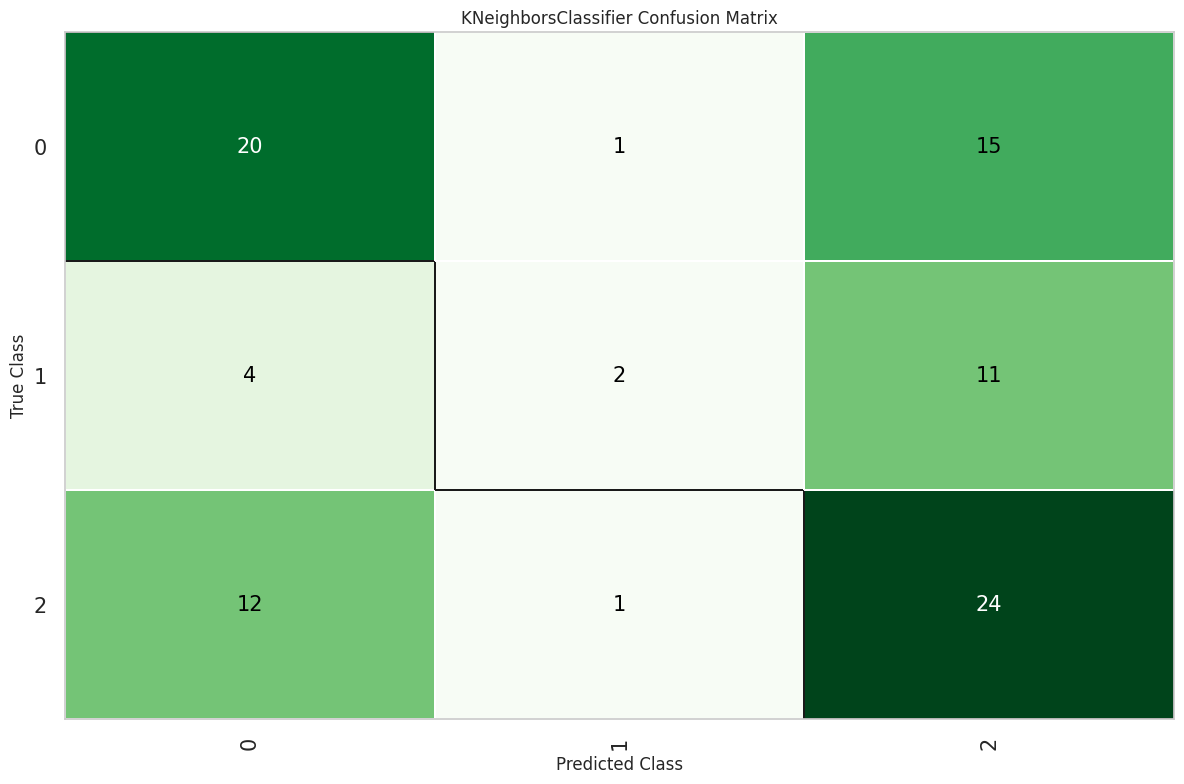

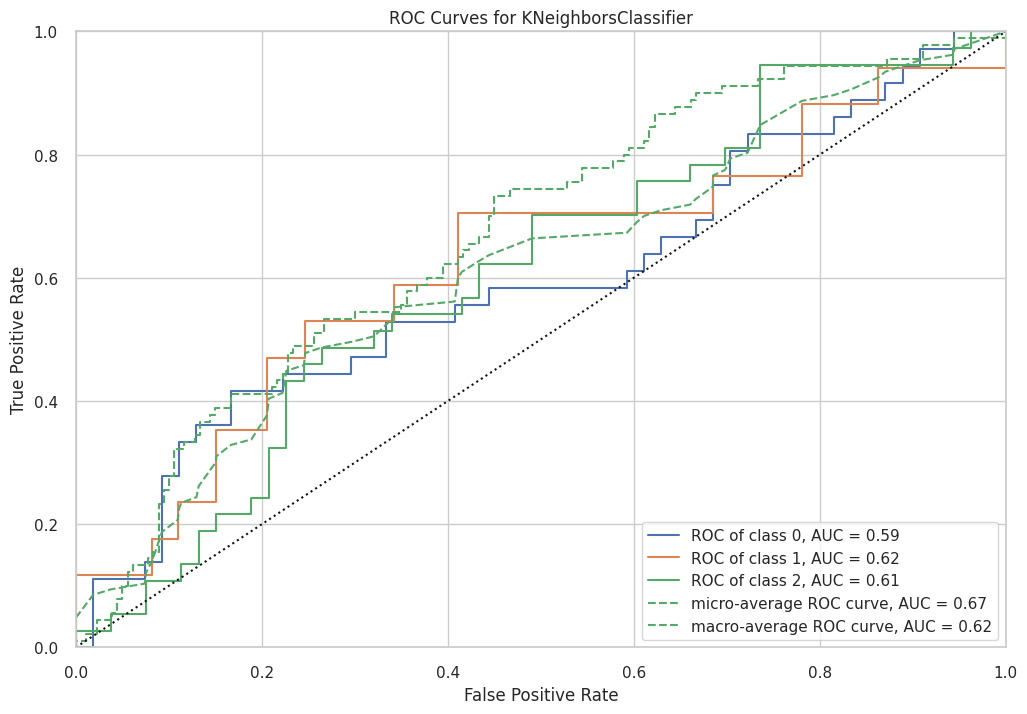

No se pudo generar gráfico de importancia de características con plot_model
Error al generar importancia de características: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- valoracion_llm
Feature names seen at fit time, yet now missing:
- valoracion_llm_negative
- valoracion_llm_neutral
- valoracion_llm_positive

Guardando modelo en resultados_20250504_155841/models/modelo_16_KNeighborsClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando LogisticRegression...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando LogisticRegression...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.3333  0.0  0.3333  0.7024  0.3524  0.1198  0.1823
1       0.1429  0.0  0.1429  0.2143  0.1143 -0.1317 -0.2005
2       0.3333  0.0  0.3333  0.5170  0.3333  0.0982  0.1289
3       0.3810  0.0  0.3810  0.5440  0.3896  0.1495  0.1852
4       0.2857  0.0  0.2857  0.4687  0.2221  0.0922  0.2194
5       0.2381  0.0  0.2381  0.4687  0.1520  0.0345  0.0812
6       0.2381  0.0  0.2381  0.4381  0.2522 -0.0182 -0.0255
7       0.2857  0.0  0.2857  0.2988  0.2111  0.0735  0.1254
8       0.2857  0.0  0.2857  0.6527  0.2865  0.0708  0.1195
9       0.2500  0.0  0.2500  0.2375  0.1933  0.0132  0.0221
Mean    0.2774  0.0  0.2774  0.4542  0.2507  0.0502  0.0838
Std     0.0626  0.0  0.0626  0.1557  0.0847  0.0769  0.1183
Generando visualizaciones para LogisticRegression...


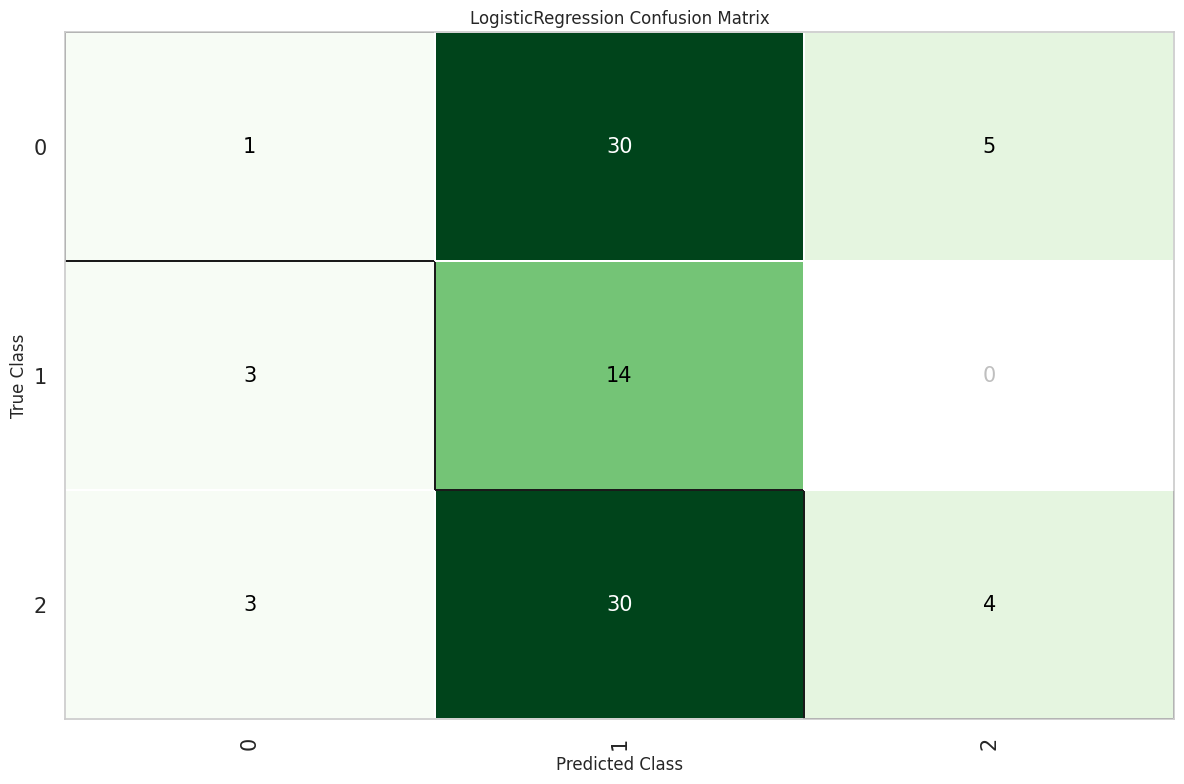

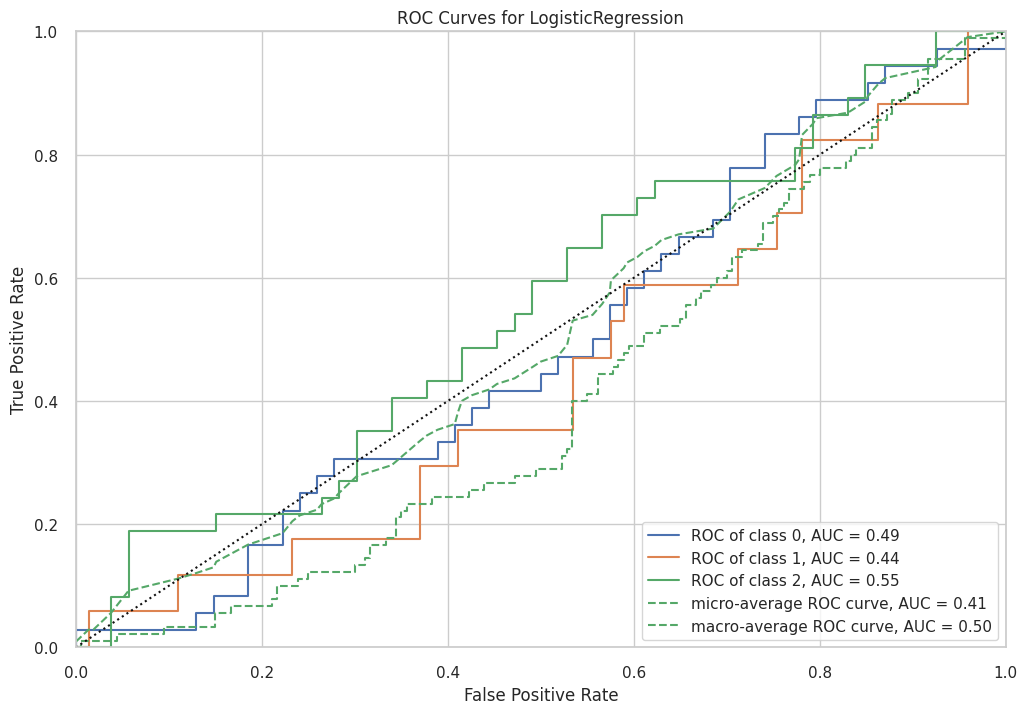

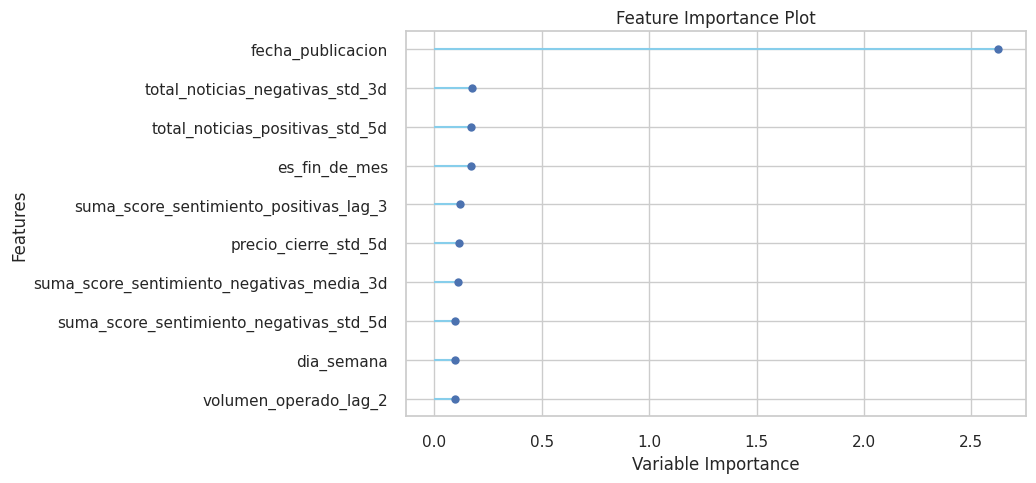

Guardando modelo en resultados_20250504_155841/models/modelo_16_LogisticRegression...
Transformation Pipeline and Model Successfully Saved
Modelado completo para la empresa 16
Completado modelar_empresa en 148.01 segundos
Empresa 16 procesada en 2.47 minutos
Procesando empresa 17...
Iniciando modelar_empresa
Modelado para la empresa 17
Número de registros para la empresa 17: 299
Distribución de clases:
label
SUBE        145
BAJA        133
MANTIENE     21
Name: count, dtype: int64
Configurando ambiente PyCaret...
                    Description                          Value
0                    Session id                             42
1                        Target                          label
2                   Target type                     Multiclass
3                Target mapping  BAJA: 0, MANTIENE: 1, SUBE: 2
4           Original data shape                      (299, 73)
5        Transformed data shape                      (299, 73)
6   Transformed train set shape         

                                   Model  Accuracy     AUC  Recall   Prec.  \
svm                  SVM - Linear Kernel    0.4785  0.0000  0.4785  0.4934   
et                Extra Trees Classifier    0.4547  0.5726  0.4547  0.4737   
lr                   Logistic Regression    0.4355  0.0000  0.4355  0.4788   
knn               K Neighbors Classifier    0.4593  0.5279  0.4593  0.4543   
rf              Random Forest Classifier    0.4929  0.5202  0.4929  0.4808   
ridge                   Ridge Classifier    0.4831  0.0000  0.4831  0.5745   
dummy                   Dummy Classifier    0.4832  0.5000  0.4832  0.2335   
nb                           Naive Bayes    0.1675  0.5030  0.1675  0.3221   
qda      Quadratic Discriminant Analysis    0.0909  0.0000  0.0909  0.2289   
xgboost        Extreme Gradient Boosting    0.0718  0.5184  0.0718  0.0052   
dt              Decision Tree Classifier    0.0718  0.5000  0.0718  0.0052   
ada                 Ada Boost Classifier    0.0718  0.0000  0.07

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando SGDClassifier...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.3333  0.0  0.3333  0.3741  0.3501 -0.1011 -0.1049
1       0.7619  0.0  0.7619  0.8135  0.7751  0.5930  0.6033
2       0.3810  0.0  0.3810  0.3849  0.3730 -0.0581 -0.0591
3       0.5714  0.0  0.5714  0.6161  0.5470  0.1711  0.1950
4       0.3333  0.0  0.3333  0.3690  0.3492 -0.0809 -0.0822
5       0.5714  0.0  0.5714  0.5912  0.5771  0.2786  0.2819
6       0.3810  0.0  0.3810  0.4740  0.4040  0.0353  0.0382
7       0.3810  0.0  0.3810  0.4082  0.3598  0.0777  0.0850
8       0.3333  0.0  0.3333  0.3568  0.3421 -0.1221 -0.1236
9       0.5500  0.0  0.5500  0.7192  0.5813  0.2208  0.2407
Mean    0.4598  0.0  0.4598  0.5107  0.4659  0.1014  0.1074
Std     0.1382  0.0  0.1382  0.1558  0.1393  0.2114  0.2166
Generando visualizaciones para SGDClassifier...


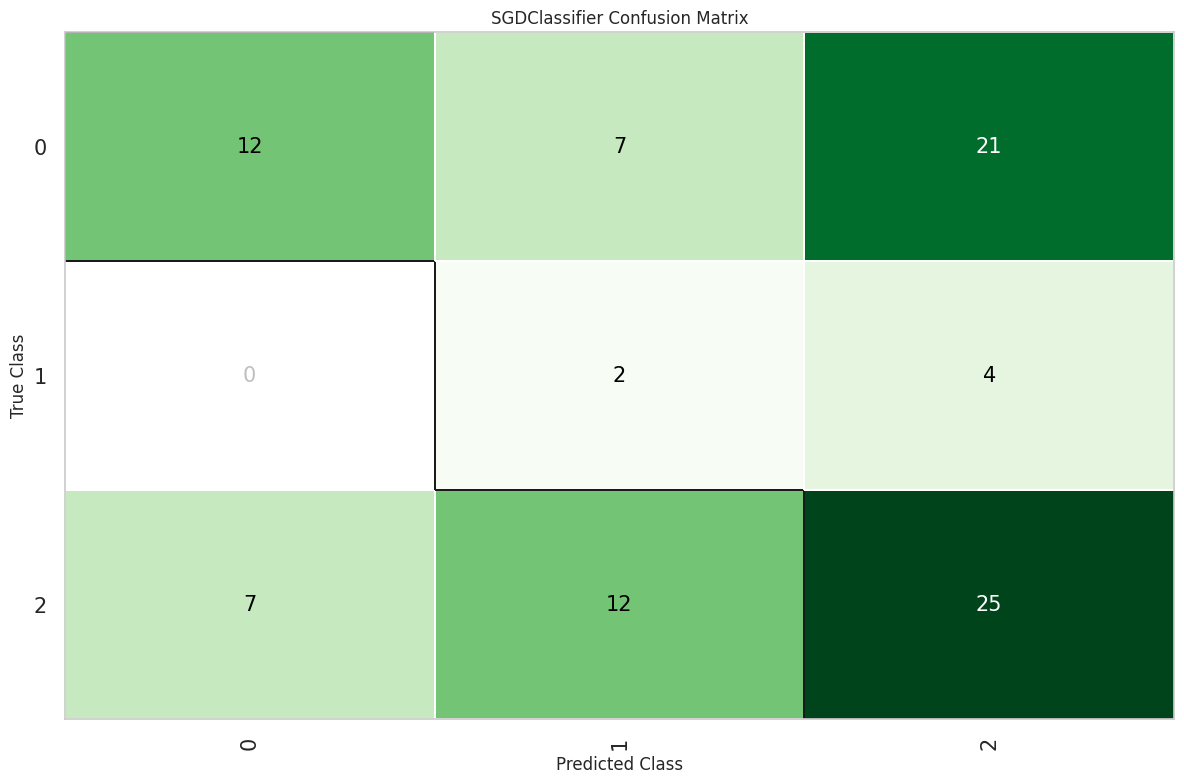

No se pudo generar curva AUC para este modelo


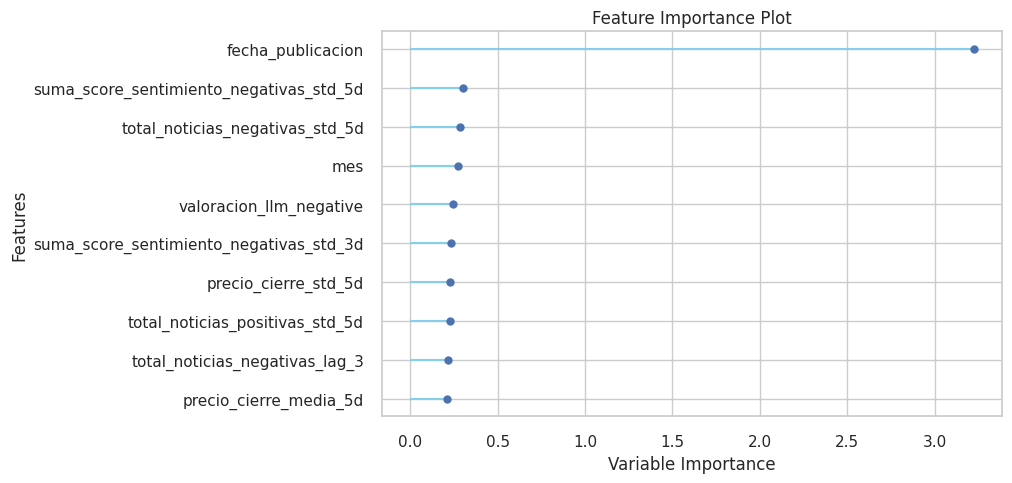

Guardando modelo en resultados_20250504_155841/models/modelo_17_SGDClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando ExtraTreesClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando ExtraTreesClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.0952  0.6288  0.0952  0.4786  0.0911  0.0292  0.1225
1       0.0476  0.5208  0.0476  0.0023  0.0043  0.0000  0.0000
2       0.0476  0.4749  0.0476  0.0024  0.0045 -0.0219 -0.0919
3       0.0476  0.3500  0.0476  0.0023  0.0043  0.0000  0.0000
4       0.0952  0.5041  0.0952  0.0091  0.0166  0.0000  0.0000
5       0.0952  0.5595  0.0952  0.0091  0.0166  0.0000  0.0000
6       0.0952  0.4593  0.0952  0.0091  0.0166  0.0000  0.0000
7       0.0952  0.4073  0.0952  0.0091  0.0166  0.0000  0.0000
8       0.0952  0.6391  0.0952  0.0091  0.0166  0.0000  0.0000
9       0.0500  0.4760  0.0500  0.0025  0.0048  0.0000  0.0000
Mean    0.0764  0.5020  0.0764  0.0533  0.0192  0.0007  0.0031
Std     0.0230  0.0859  0.0230  

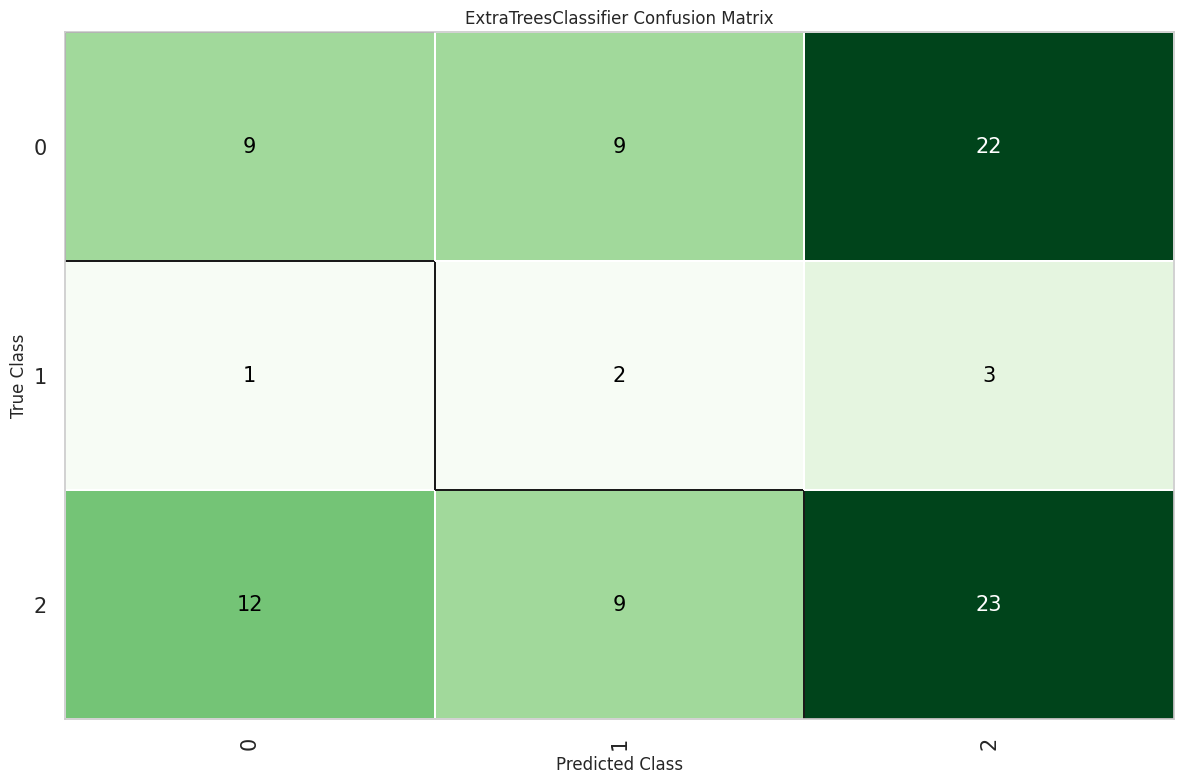

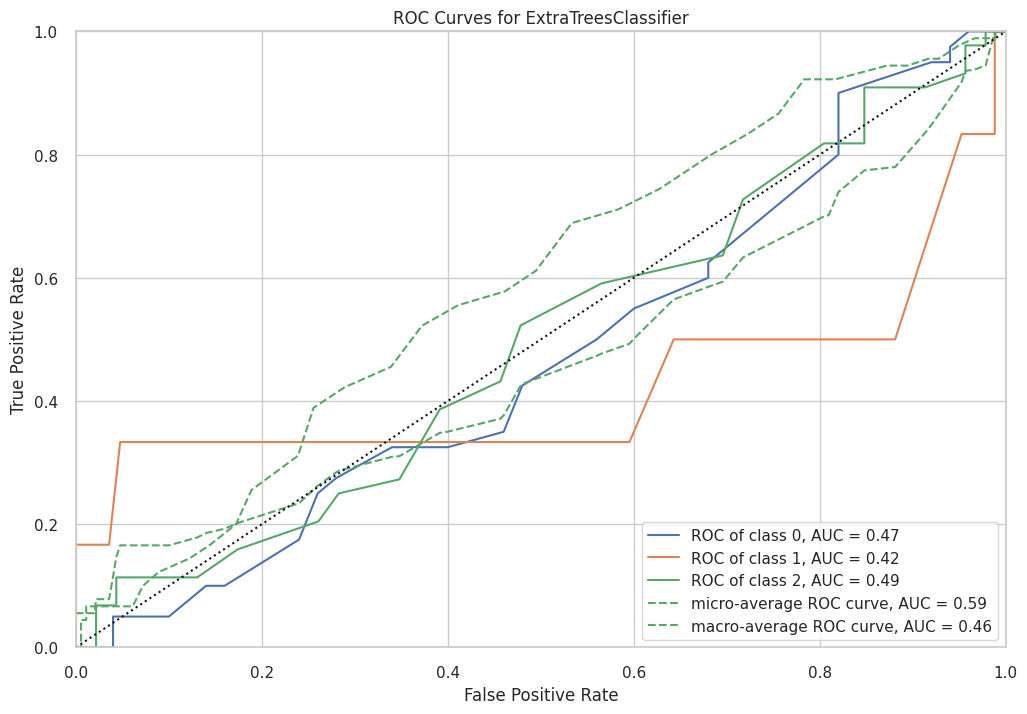

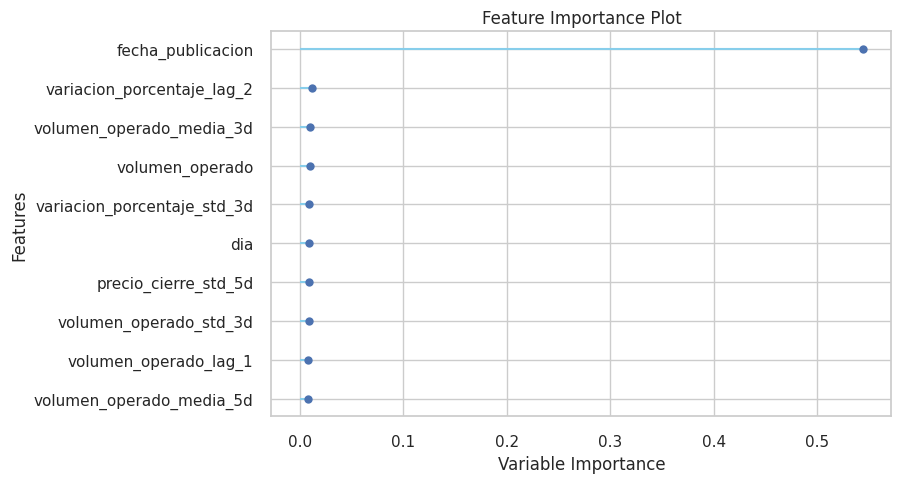

Guardando modelo en resultados_20250504_155841/models/modelo_17_ExtraTreesClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando LogisticRegression...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando LogisticRegression...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.4762  0.0  0.4762  0.4545  0.4649  0.0000  0.0000
1       0.6190  0.0  0.6190  0.5887  0.6032  0.2727  0.2742
2       0.3810  0.0  0.3810  0.3636  0.3719 -0.1818 -0.1828
3       0.5238  0.0  0.5238  0.4963  0.5072  0.0708  0.0719
4       0.3333  0.0  0.3333  0.3146  0.3218 -0.1760 -0.1783
5       0.4762  0.0  0.4762  0.4359  0.4454  0.0533  0.0563
6       0.5238  0.0  0.5238  0.4683  0.4935  0.1250  0.1276
7       0.3333  0.0  0.3333  0.2839  0.3006 -0.2049 -0.2167
8       0.4762  0.0  0.4762  0.4254  0.4272  0.0533  0.0589
9       0.6000  0.0  0.6000  0.5729  0.5829  0.2308  0.2346
Mean    0.4743  0.0  0.4743  0.4404  0.4519  0.0243  0.0246
Std     0.0949  0.0  0.0949  0.0949  0.0958  0.1594  0.1626
Generando visualizaciones para LogisticRegression...


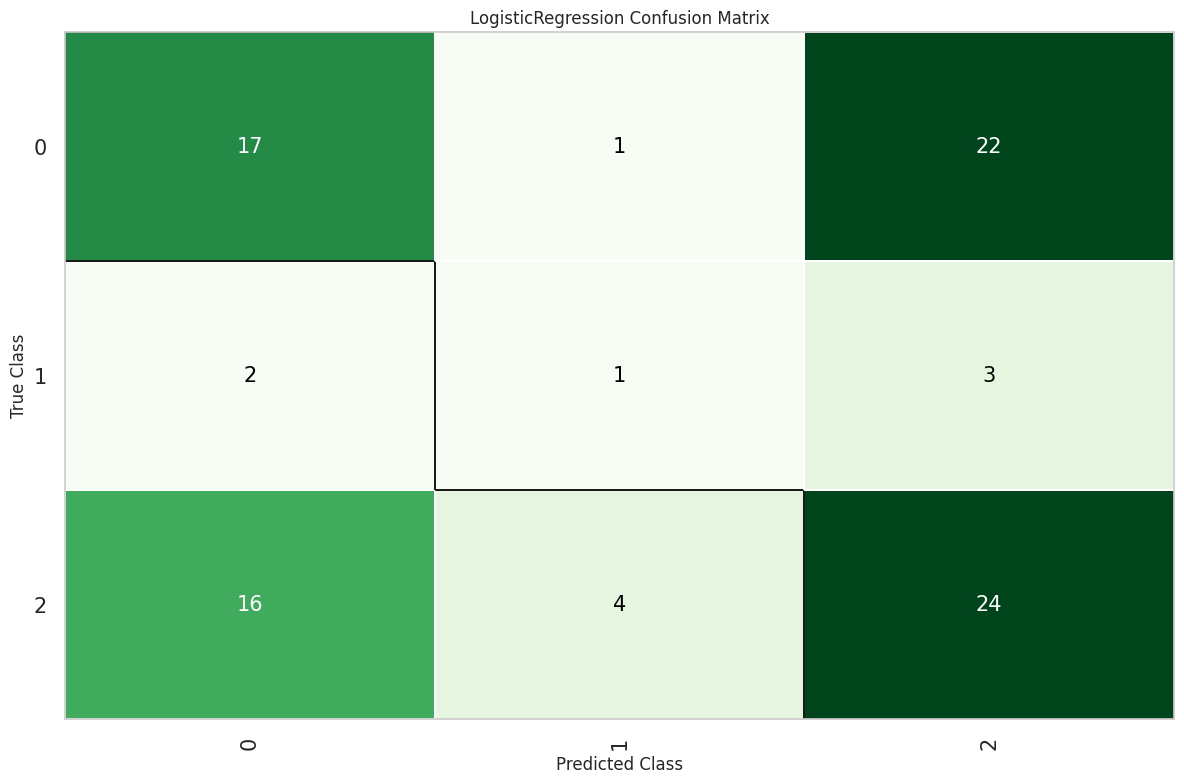

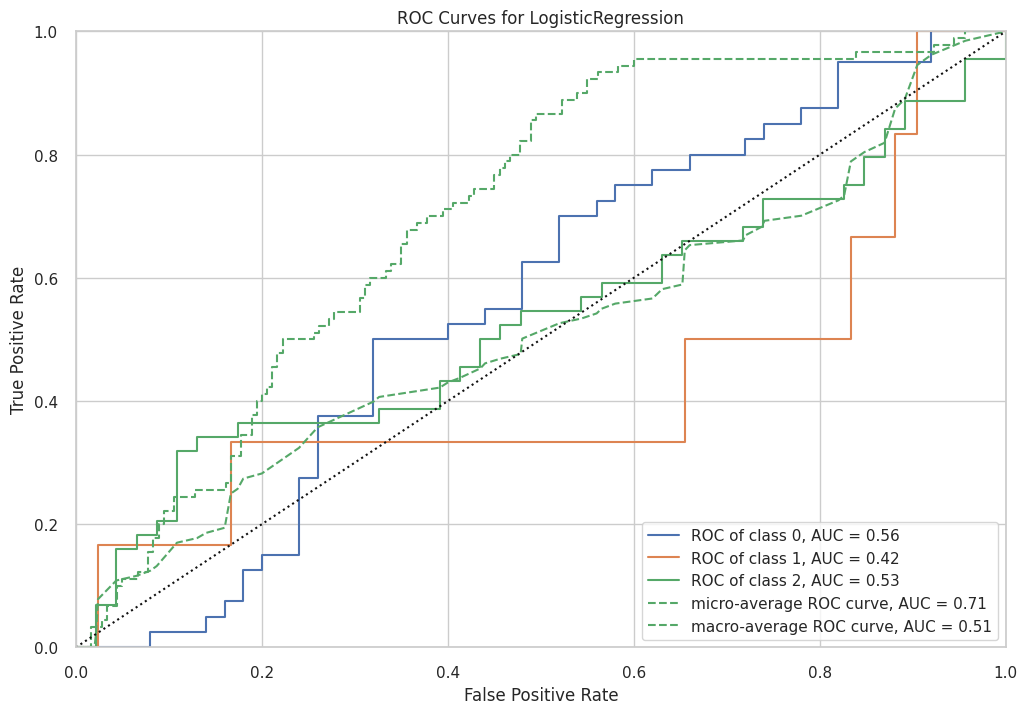

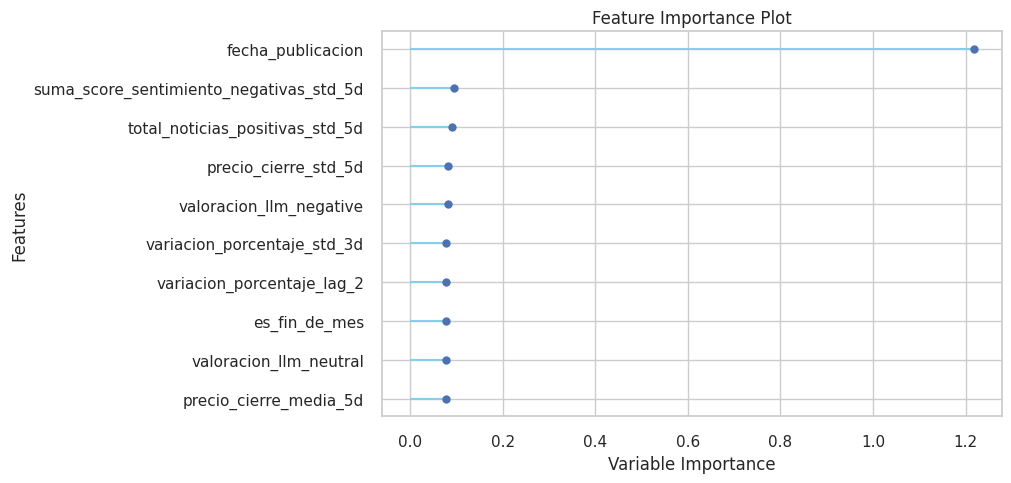

Guardando modelo en resultados_20250504_155841/models/modelo_17_LogisticRegression...
Transformation Pipeline and Model Successfully Saved
Modelado completo para la empresa 17
Completado modelar_empresa en 142.01 segundos
Empresa 17 procesada en 2.37 minutos
Procesando empresa 18...
Iniciando modelar_empresa
Modelado para la empresa 18
Número de registros para la empresa 18: 299
Distribución de clases:
label
BAJA        138
SUBE        134
MANTIENE     27
Name: count, dtype: int64
Configurando ambiente PyCaret...
                    Description                          Value
0                    Session id                             42
1                        Target                          label
2                   Target type                     Multiclass
3                Target mapping  BAJA: 0, MANTIENE: 1, SUBE: 2
4           Original data shape                      (299, 73)
5        Transformed data shape                      (299, 73)
6   Transformed train set shape         

                                   Model  Accuracy     AUC  Recall   Prec.  \
knn               K Neighbors Classifier    0.4688  0.4928  0.4688  0.4492   
rf              Random Forest Classifier    0.4161  0.4894  0.4161  0.4137   
lr                   Logistic Regression    0.3685  0.0000  0.3685  0.4366   
svm                  SVM - Linear Kernel    0.3589  0.0000  0.3589  0.3958   
et                Extra Trees Classifier    0.3396  0.4606  0.3396  0.4200   
ridge                   Ridge Classifier    0.4259  0.0000  0.4259  0.3000   
xgboost        Extreme Gradient Boosting    0.4594  0.5277  0.4594  0.2110   
dummy                   Dummy Classifier    0.4594  0.5000  0.4594  0.2110   
qda      Quadratic Discriminant Analysis    0.1436  0.0000  0.1436  0.2269   
nb                           Naive Bayes    0.1341  0.4941  0.1341  0.2702   
dt              Decision Tree Classifier    0.0909  0.5000  0.0909  0.0083   
ada                 Ada Boost Classifier    0.0909  0.0000  0.09

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando KNeighborsClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.4762  0.4132  0.4762  0.5079  0.4005  0.0723  0.1083
1       0.4286  0.4759  0.4286  0.4095  0.3929 -0.0244 -0.0280
2       0.5238  0.5427  0.5238  0.5175  0.4881  0.1463  0.1677
3       0.3810  0.4893  0.3810  0.3545  0.3638 -0.1235 -0.1276
4       0.4762  0.5599  0.4762  0.4365  0.4381  0.0253  0.0280
5       0.4762  0.4795  0.4762  0.4341  0.4501  0.0335  0.0347
6       0.6667  0.6481  0.6667  0.6032  0.6320  0.3875  0.3955
7       0.3810  0.4141  0.3810  0.3439  0.3583 -0.1423 -0.1473
8       0.4762  0.4890  0.4762  0.4365  0.4381  0.0253  0.0280
9       0.4500  0.4454  0.4500  0.4133  0.4086 -0.0732 -0.0830
Mean    0.4736  0.4957  0.4736  0.4457  0.4370  0.0327  0.0376
Std     0.0772  0.0680  0.0772  

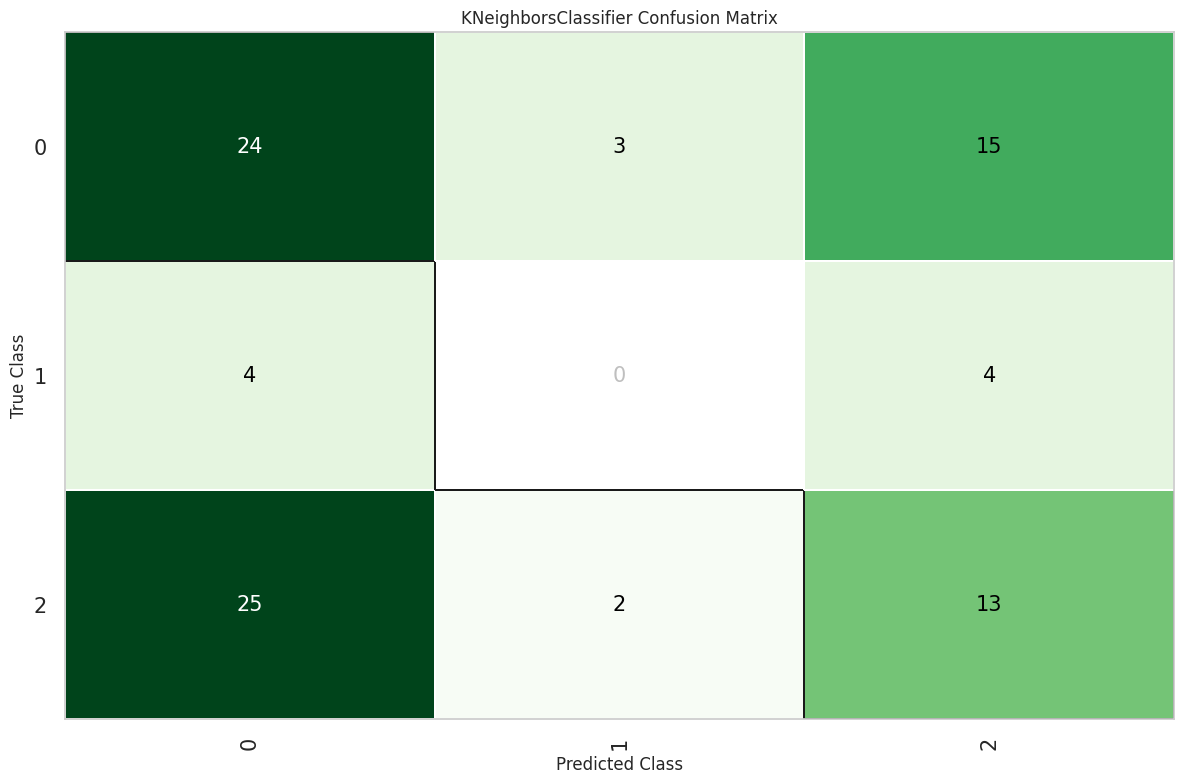

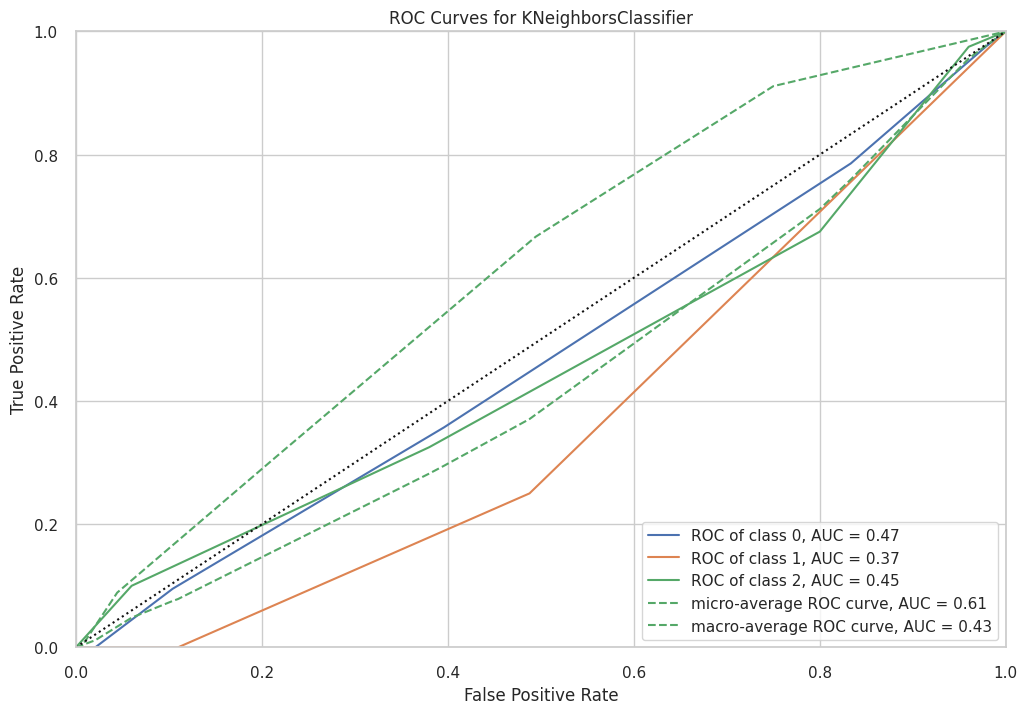

No se pudo generar gráfico de importancia de características con plot_model
Error al generar importancia de características: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- valoracion_llm
Feature names seen at fit time, yet now missing:
- valoracion_llm_negative
- valoracion_llm_neutral
- valoracion_llm_positive

Guardando modelo en resultados_20250504_155841/models/modelo_18_KNeighborsClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando RandomForestClassifier...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando RandomForestClassifier...


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.1429  0.3944  0.1429  0.4857  0.1039  0.0332  0.1285
1       0.0952  0.5002  0.0952  0.0091  0.0166  0.0000  0.0000
2       0.2381  0.4763  0.2381  0.2789  0.2360  0.0204  0.0312
3       0.0952  0.5315  0.0952  0.0091  0.0166  0.0000  0.0000
4       0.0952  0.4993  0.0952  0.0091  0.0166  0.0000  0.0000
5       0.0952  0.4460  0.0952  0.0091  0.0166  0.0000  0.0000
6       0.0952  0.3826  0.0952  0.0091  0.0166  0.0000  0.0000
7       0.0952  0.3662  0.0952  0.0091  0.0166  0.0000  0.0000
8       0.0952  0.3332  0.0952  0.0091  0.0166  0.0000  0.0000
9       0.0500  0.5667  0.0500  0.0025  0.0048  0.0000  0.0000
Mean    0.1098  0.4496  0.1098  0.0831  0.0461  0.0054  0.0160
Std     0.0476  0.0736  0.0476  

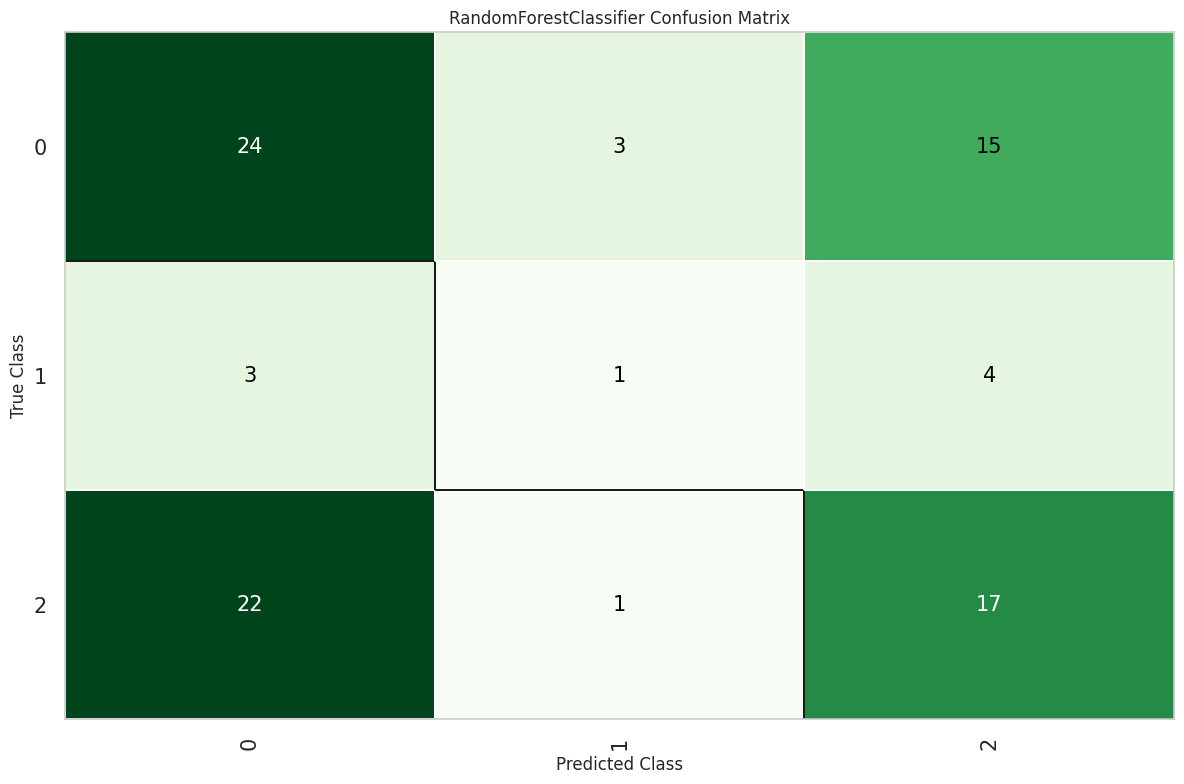

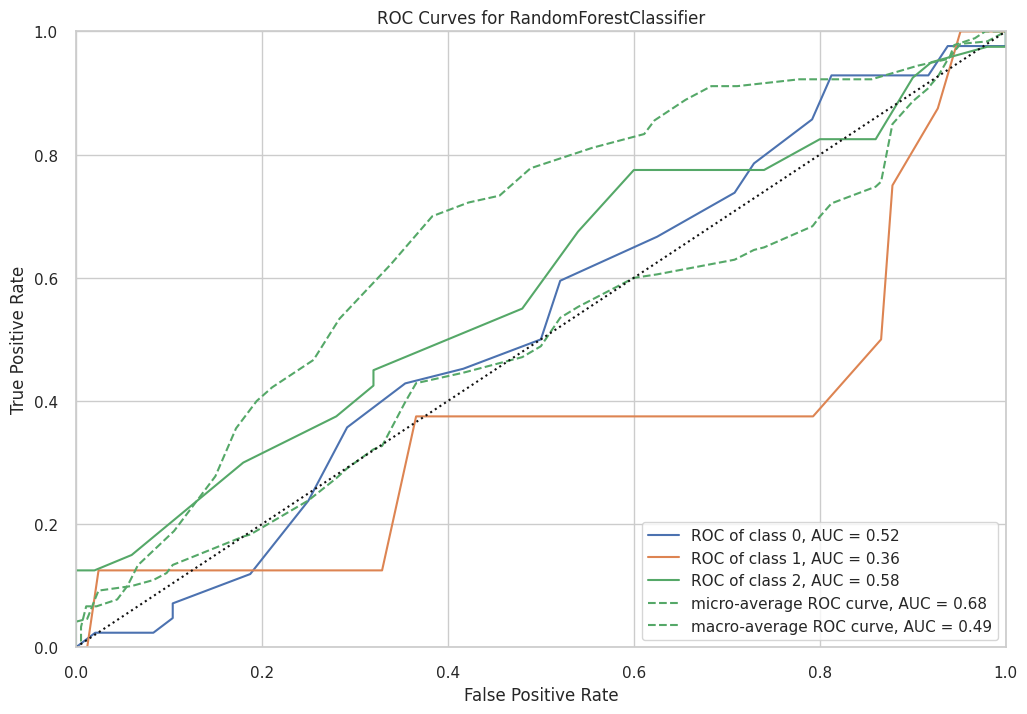

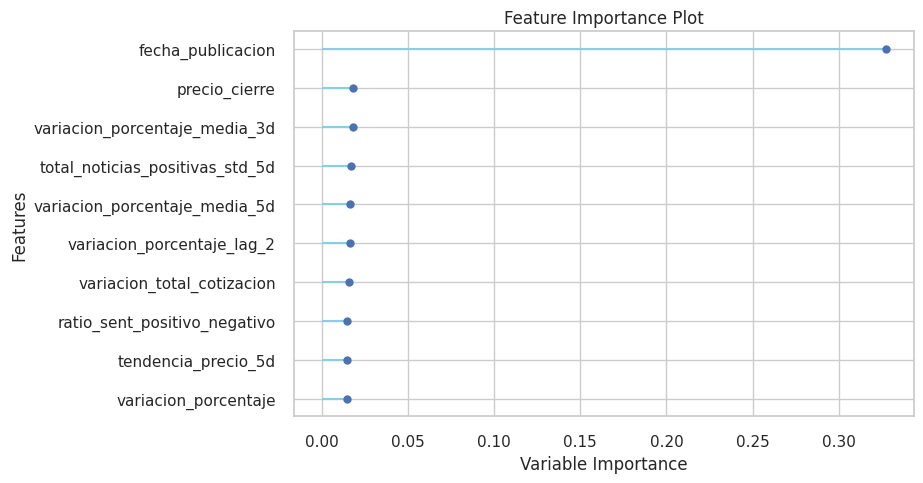

Guardando modelo en resultados_20250504_155841/models/modelo_18_RandomForestClassifier...
Transformation Pipeline and Model Successfully Saved
Evaluando LogisticRegression...


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Tuneando LogisticRegression...


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.3810  0.0  0.3810  0.3912  0.3709 -0.0500 -0.0527
1       0.3810  0.0  0.3810  0.4262  0.3999 -0.0302 -0.0305
2       0.4762  0.0  0.4762  0.4931  0.4791  0.1183  0.1197
3       0.3810  0.0  0.3810  0.3645  0.3605  0.0109  0.0114
4       0.2857  0.0  0.2857  0.3424  0.3111 -0.1331 -0.1367
5       0.2857  0.0  0.2857  0.2749  0.2772 -0.2209 -0.2244
6       0.4762  0.0  0.4762  0.5026  0.4887  0.1250  0.1255
7       0.5714  0.0  0.5714  0.6020  0.5726  0.2703  0.2801
8       0.4286  0.0  0.4286  0.5094  0.4649  0.0935  0.0961
9       0.3000  0.0  0.3000  0.3167  0.3079 -0.2335 -0.2347
Mean    0.3967  0.0  0.3967  0.4223  0.4033 -0.0050 -0.0046
Std     0.0888  0.0  0.0888  0.0974  0.0905  0.1535  0.1567
Generando visualizaciones para LogisticRegression...


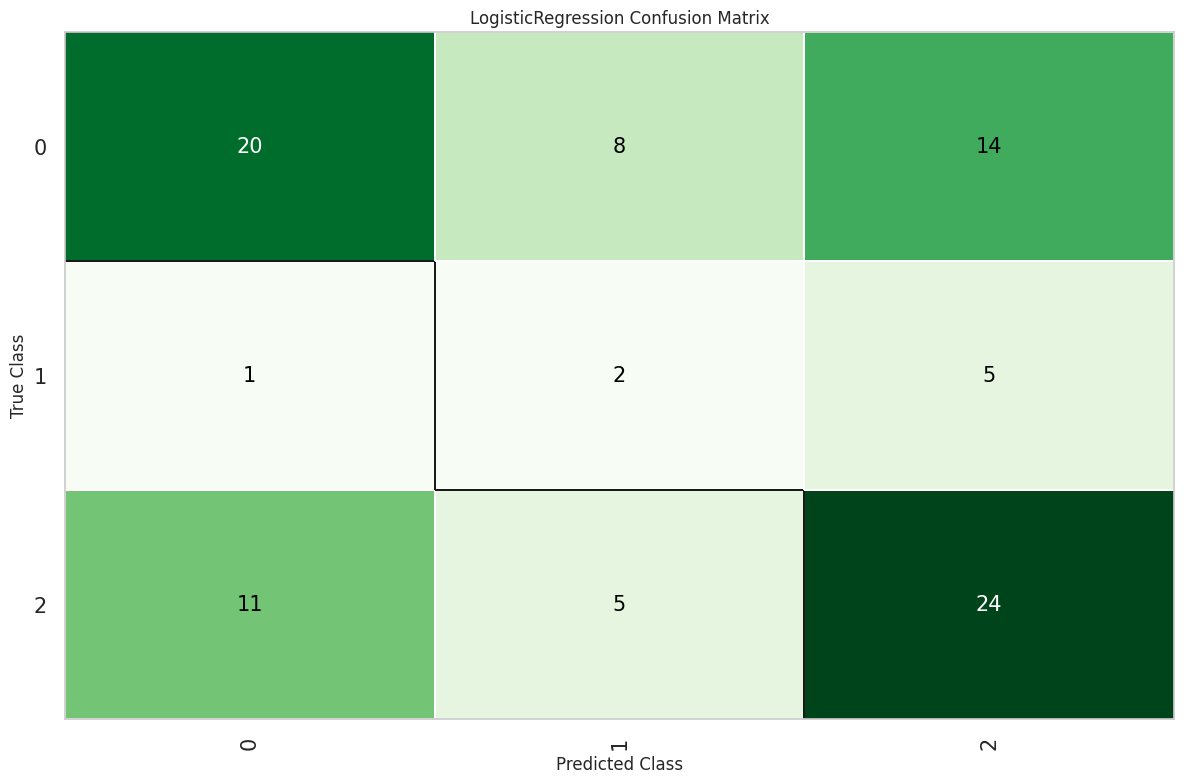

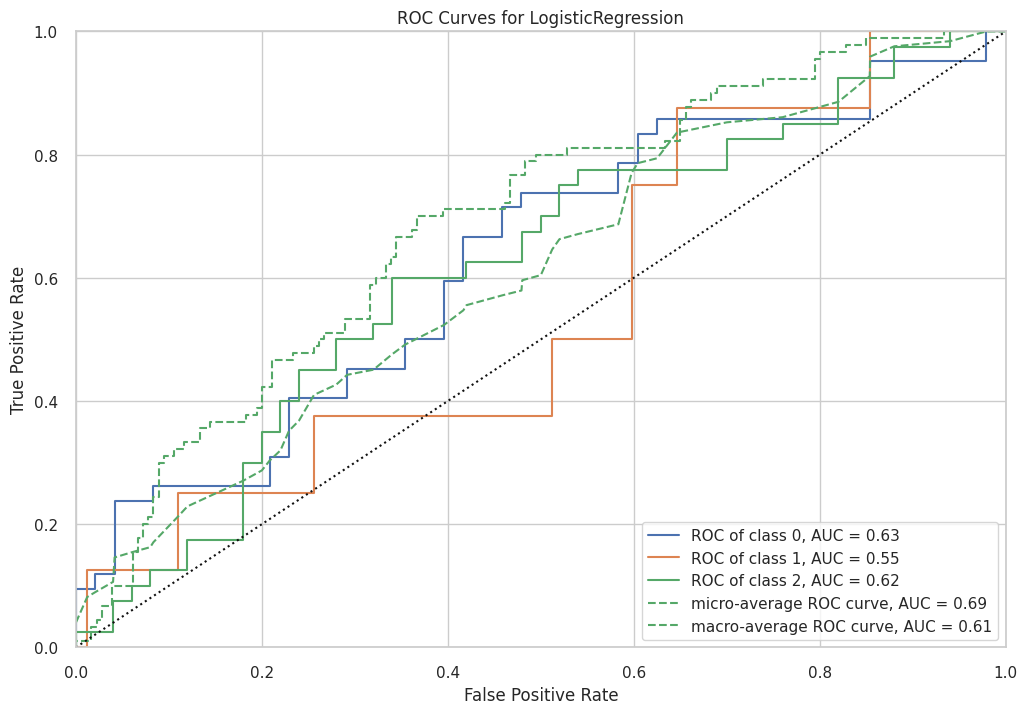

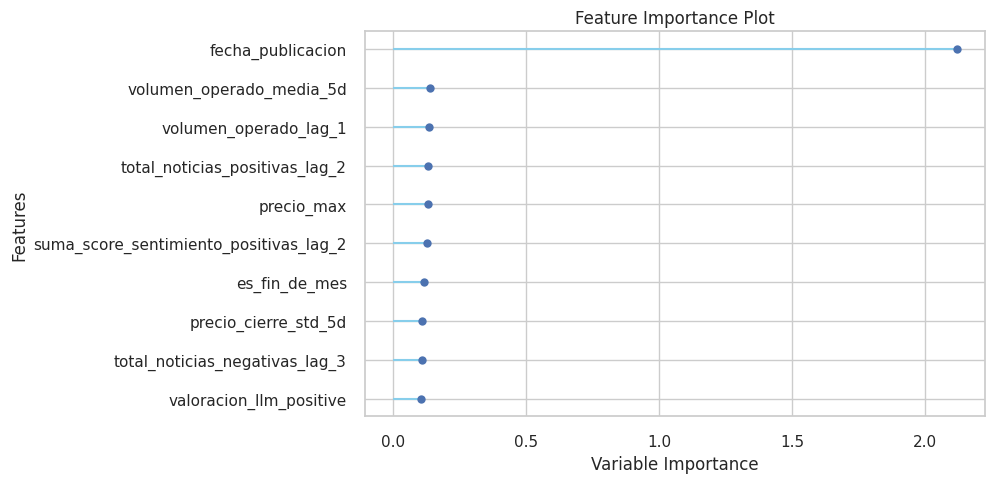

Guardando modelo en resultados_20250504_155841/models/modelo_18_LogisticRegression...
Transformation Pipeline and Model Successfully Saved
Modelado completo para la empresa 18
Completado modelar_empresa en 150.71 segundos
Empresa 18 procesada en 2.51 minutos


In [8]:
# Ejecutamos el modelado para cada empresa
resultados_por_empresa = {}

for empresa_id in df_clean['id_empresa'].unique():
    empresa_start_time = time.time()
    print(f"Procesando empresa {empresa_id}...")
    
    try:
        empresa_df, modelos, resultados = modelar_empresa(df_clean, empresa_id)
        
        # Verificar si hay resultados válidos antes de almacenar
        if empresa_df is not None and modelos and resultados:
            resultados_por_empresa[empresa_id] = {
                'dataframe': empresa_df,
                'modelos': modelos,
                'resultados': resultados
            }
            
        empresa_end_time = time.time()
        print(f"Empresa {empresa_id} procesada en {(empresa_end_time - empresa_start_time)/60:.2f} minutos")
        
    except Exception as e:
        print(f"Error procesando empresa {empresa_id}: {str(e)}")
        import traceback
        print(traceback.format_exc())
        continue  # Continuamos con la siguiente empresa

9. Análisis Comparativo


In [9]:
# Creamos un DataFrame con los resultados comparativos
resumen_empresas = pd.DataFrame(columns=['Empresa', 'Mejor_Modelo', 'Accuracy', 'Precision', 'Recall', 'F1', 'Num_Registros'])

for empresa_id, datos in resultados_por_empresa.items():
    if 'modelos' in datos and datos['modelos']:
        try:
            # Obtenemos el mejor modelo (el primero de la lista)
            mejor_modelo = datos['modelos'][0]
            modelo_nombre = str(type(mejor_modelo).__name__)
            
            # Obtenemos métricas 
            metricas = None
            metrics_path = os.path.join(results_dir, f"comparacion_modelos_empresa_{empresa_id}.csv")
            try:
                if os.path.exists(metrics_path):
                    metricas = pd.read_csv(metrics_path)
                else:
                    print(f"Archivo de métricas no encontrado: {metrics_path}")
                    continue
            except Exception as load_error:
                print(f"No se pudieron cargar métricas para empresa {empresa_id}: {str(load_error)}")
                continue
                
            if metricas is not None and not metricas.empty and 'Model' in metricas.columns:
                # Verificar si el modelo existe en el dataframe de métricas
                if modelo_nombre in metricas['Model'].values:
                    mejor_modelo_metricas = metricas[metricas['Model'] == modelo_nombre].iloc[0]
                    
                    # Verificamos que existen todas las columnas necesarias
                    required_cols = ['Accuracy', 'Prec. Macro', 'Recall Macro', 'F1 Macro']
                    if all(col in mejor_modelo_metricas.index for col in required_cols):
                        # Crear fila para el resumen
                        resumen_row = {
                            'Empresa': empresa_id,
                            'Mejor_Modelo': modelo_nombre,
                            'Accuracy': mejor_modelo_metricas['Accuracy'],
                            'Precision': mejor_modelo_metricas['Prec. Macro'],
                            'Recall': mejor_modelo_metricas['Recall Macro'],
                            'F1': mejor_modelo_metricas['F1 Macro'],
                            'Num_Registros': datos['dataframe'].shape[0]
                        }
                        
                        # Usar concat
                        resumen_empresas = pd.concat([resumen_empresas, pd.DataFrame([resumen_row])], ignore_index=True)
                    else:
                        print(f"Faltan columnas requeridas en métricas para empresa {empresa_id}")
                else:
                    print(f"Modelo {modelo_nombre} no encontrado en métricas para empresa {empresa_id}")
            else:
                print(f"Datos de métricas inválidos para empresa {empresa_id}")
        except Exception as e:
            print(f"Error al crear resumen para empresa {empresa_id}: {str(e)}")
            import traceback
            print(traceback.format_exc())

# Guardamos el resumen si hay datos
if not resumen_empresas.empty:
    resumen_empresas.to_csv(os.path.join(results_dir, "resumen_modelos_por_empresa.csv"), index=False)
    print("Resumen comparativo guardado")
    
    # Mostramos el resumen
    display(resumen_empresas)
else:
    print("No se pudo crear el resumen comparativo: no hay datos suficientes")

Modelo LogisticRegression no encontrado en métricas para empresa 10
Modelo KNeighborsClassifier no encontrado en métricas para empresa 11
Modelo KNeighborsClassifier no encontrado en métricas para empresa 12
Modelo ExtraTreesClassifier no encontrado en métricas para empresa 13
Modelo LogisticRegression no encontrado en métricas para empresa 14
Modelo KNeighborsClassifier no encontrado en métricas para empresa 15
Modelo RandomForestClassifier no encontrado en métricas para empresa 16
Modelo SGDClassifier no encontrado en métricas para empresa 17
Modelo KNeighborsClassifier no encontrado en métricas para empresa 18
No se pudo crear el resumen comparativo: no hay datos suficientes


10. Visualizaciones Comparativas


In [10]:
# Visualizamos las métricas por empresa
if not resumen_empresas.empty:
    plt.figure(figsize=(14, 10))
    
    # Accuracy
    plt.subplot(2, 2, 1)
    sns.barplot(x='Empresa', y='Accuracy', data=resumen_empresas)
    plt.title('Accuracy por Empresa')
    plt.xticks(rotation=45)
    
    # Precision
    plt.subplot(2, 2, 2)
    sns.barplot(x='Empresa', y='Precision', data=resumen_empresas)
    plt.title('Precision por Empresa')
    plt.xticks(rotation=45)
    
    # Recall
    plt.subplot(2, 2, 3)
    sns.barplot(x='Empresa', y='Recall', data=resumen_empresas)
    plt.title('Recall por Empresa')
    plt.xticks(rotation=45)
    
    # F1
    plt.subplot(2, 2, 4)
    sns.barplot(x='Empresa', y='F1', data=resumen_empresas)
    plt.title('F1-Score por Empresa')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico de comparación de modelos por empresa
    plt.figure(figsize=(12, 8))
    sns.countplot(x='Mejor_Modelo', data=resumen_empresas)
    plt.title('Distribución de Mejores Modelos por Empresa')
    plt.xticks(rotation=45)
    plt.ylabel('Conteo')
    plt.show()

11. Función para Analizar Importancia de Características


In [11]:
def analizar_features_importancia():
    """Función para analizar las características más importantes para cada empresa"""
    for empresa_id, datos in resultados_por_empresa.items():
        if 'resultados' in datos and datos['resultados']:
            print(f"\n{'='*50}")
            print(f"Características importantes para la empresa {empresa_id}")
            print(f"{'='*50}")
            
            # Iteramos por los modelos disponibles
            for modelo_nombre, modelo in datos['resultados'].items():
                print(f"\nModelo: {modelo_nombre}")
                
                # Intentamos obtener importancia de características si está disponible
                try:
                    # Para modelos basados en árboles
                    if hasattr(modelo, 'feature_importances_'):
                        # Obtenemos los nombres de las características del setup de PyCaret
                        feature_names = get_config('X_train').columns.tolist()
                        importances = modelo.feature_importances_
                        
                        # Crear DataFrame de importancias
                        feature_importance = pd.DataFrame({
                            'Feature': feature_names,
                            'Importance': importances
                        })
                        
                        # Ordenar por importancia
                        feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
                        
                        # Mostrar las 10 características más importantes
                        print("Top 10 características más importantes:")
                        display(feature_importance.head(10))
                        
                        # Visualizar
                        plt.figure(figsize=(12, 8))
                        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
                        plt.title(f'Importancia de Características - Empresa {empresa_id} - {modelo_nombre}')
                        plt.tight_layout()
                        plt.show()
                    
                    # Para modelos lineales
                    elif hasattr(modelo, 'coef_'):
                        feature_names = get_config('X_train').columns.tolist()
                        
                        # Los coeficientes pueden tener diferentes formas según el modelo
                        if len(modelo.coef_.shape) == 1:
                            coefs = modelo.coef_
                        else:
                            # Promediamos coeficientes para todas las clases
                            coefs = np.mean(np.abs(modelo.coef_), axis=0)
                        
                        # Crear DataFrame de coeficientes
                        feature_importance = pd.DataFrame({
                            'Feature': feature_names,
                            'Coefficient': coefs
                        })
                        
                        # Ordenar por valor absoluto de coeficientes
                        feature_importance['AbsCoef'] = np.abs(feature_importance['Coefficient'])
                        feature_importance = feature_importance.sort_values('AbsCoef', ascending=False).reset_index(drop=True)
                        
                        # Mostrar las 10 características más importantes
                        print("Top 10 características más importantes:")
                        display(feature_importance[['Feature', 'Coefficient']].head(10))
                        
                        # Visualizar
                        plt.figure(figsize=(12, 8))
                        sns.barplot(x='AbsCoef', y='Feature', data=feature_importance.head(15))
                        plt.title(f'Importancia de Características - Empresa {empresa_id} - {modelo_nombre}')
                        plt.tight_layout()
                        plt.show()
                    
                    # Para otros modelos, intentamos usar permutation importance
                    else:
                        from sklearn.inspection import permutation_importance
                        
                        # Obtener los datos de entrenamiento
                        X_train = get_config('X_train')
                        y_train = get_config('y_train')
                        
                        # Calculamos la importancia por permutación
                        print("Calculando importancia de características por permutación...")
                        result = permutation_importance(modelo, X_train, y_train, 
                                                      n_repeats=5, random_state=42, n_jobs=-1)
                        
                        # Creamos DataFrame de importancia
                        feature_names = get_config('X_train').columns.tolist()
                        feature_importance = pd.DataFrame({
                            'Feature': feature_names,
                            'Importance': result.importances_mean
                        })
                        
                        feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
                        
                        # Mostrar las 10 características más importantes
                        print("Top 10 características más importantes (por permutación):")
                        display(feature_importance.head(10))
                        
                        # Visualizar
                        plt.figure(figsize=(12, 8))
                        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
                        plt.title(f'Importancia de Características (Permutación) - Empresa {empresa_id} - {modelo_nombre}')
                        plt.tight_layout()
                        plt.show()
                
                except Exception as e:
                    print(f"Error al analizar importancia de características: {str(e)}")

# Ejecutamos el análisis de importancia de características
analizar_features_importancia()


Características importantes para la empresa 10

Modelo: LogisticRegression
Error al analizar importancia de características: All arrays must be of the same length

Modelo: KNeighborsClassifier
Calculando importancia de características por permutación...
Error al analizar importancia de características: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- valoracion_llm
Feature names seen at fit time, yet now missing:
- valoracion_llm_negative
- valoracion_llm_neutral
- valoracion_llm_positive


Modelo: RandomForestClassifier
Error al analizar importancia de características: All arrays must be of the same length

Características importantes para la empresa 11

Modelo: KNeighborsClassifier
Calculando importancia de características por permutación...
Error al analizar importancia de características: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- valoracion_llm
Feature names seen at fit

12. Función para Probar Modelos


Probando predicciones para la empresa 10 con el modelo LogisticRegression
Transformation Pipeline and Model Successfully Loaded
Modelo cargado correctamente: resultados_20250504_155841/models/modelo_10_LogisticRegression

Predicciones de ejemplo:


fecha etiqueta_real prediction_label  prediction_score
309  2025-04-07          BAJA             BAJA            0.9501
310  2025-04-08      MANTIENE         MANTIENE            0.6357
316  2025-04-16          BAJA             BAJA            0.5208
317  2025-04-21          SUBE             SUBE            0.9463
318  2025-04-22      MANTIENE         MANTIENE            0.3962

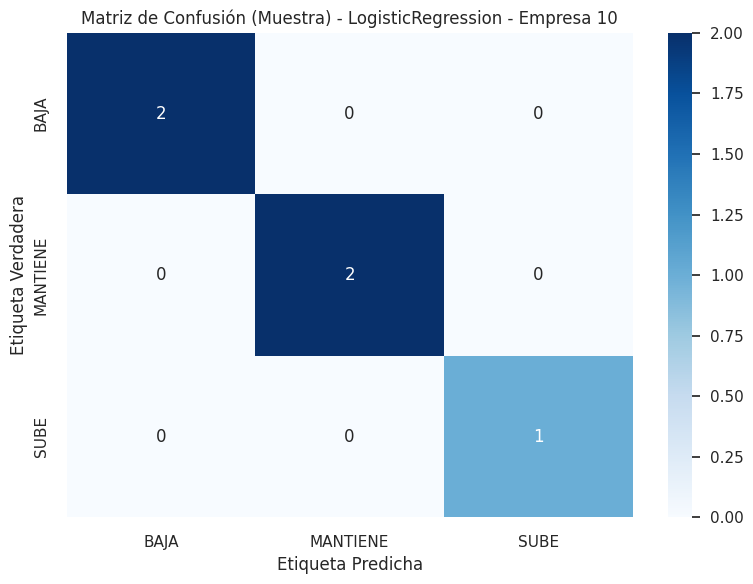

In [12]:
def probar_modelo(empresa_id, modelo_nombre):
    """Función para cargar un modelo y hacer predicciones de ejemplo"""
    try:
        # Cargamos el modelo
        model_path = os.path.join(results_dir, "models", f"modelo_{empresa_id}_{modelo_nombre}")
        modelo_cargado = load_model(model_path)
        
        print(f"Modelo cargado correctamente: {model_path}")
        
        # Obtenemos algunos datos de ejemplo para esta empresa
        empresa_df = resultados_por_empresa[empresa_id]['dataframe']
        
        # Tomamos las últimas 5 filas como ejemplo
        datos_ejemplo = empresa_df.tail(5).copy()
        etiquetas_reales = datos_ejemplo['label'].copy()
        datos_ejemplo = datos_ejemplo.drop(columns=['label'])
        
        # Hacemos predicciones
        predicciones = predict_model(modelo_cargado, data=datos_ejemplo)
        
        # Añadimos las etiquetas reales para comparar
        predicciones['etiqueta_real'] = etiquetas_reales.values
        
        print("\nPredicciones de ejemplo:")
        display(predicciones[['fecha', 'etiqueta_real', 'prediction_label', 'prediction_score']])
        
        # Mostramos una matriz de confusión para estas predicciones
        conf_matrix = confusion_matrix(predicciones['etiqueta_real'], predicciones['prediction_label'])
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=sorted(predicciones['etiqueta_real'].unique()),
                   yticklabels=sorted(predicciones['etiqueta_real'].unique()))
        plt.title(f'Matriz de Confusión (Muestra) - {modelo_nombre} - Empresa {empresa_id}')
        plt.ylabel('Etiqueta Verdadera')
        plt.xlabel('Etiqueta Predicha')
        plt.tight_layout()
        plt.show()
        
        return predicciones
    
    except Exception as e:
        print(f"Error al cargar o usar el modelo: {str(e)}")
        import traceback
        print(traceback.format_exc())
        return None

# Probamos con un ejemplo para la primera empresa y su mejor modelo
if resultados_por_empresa:
    primera_empresa = list(resultados_por_empresa.keys())[0]
    if 'modelos' in resultados_por_empresa[primera_empresa] and resultados_por_empresa[primera_empresa]['modelos']:
        mejor_modelo_nombre = str(type(resultados_por_empresa[primera_empresa]['modelos'][0]).__name__)
        
        print(f"Probando predicciones para la empresa {primera_empresa} con el modelo {mejor_modelo_nombre}")
        predicciones_ejemplo = probar_modelo(primera_empresa, mejor_modelo_nombre)

13. Conclusiones


In [13]:
# Resumen y conclusiones
print("RESUMEN DEL ANÁLISIS:")
print("="*80)
print(f"Total de empresas analizadas: {len(resultados_por_empresa)}")

# Modelos más efectivos
if not resumen_empresas.empty:
    mejor_empresa = resumen_empresas.iloc[resumen_empresas['Accuracy'].idxmax()]
    print(f"\nEmpresa con mejor rendimiento: {mejor_empresa['Empresa']}")
    print(f"- Mejor modelo: {mejor_empresa['Mejor_Modelo']}")
    print(f"- Accuracy: {mejor_empresa['Accuracy']:.4f}")
    print(f"- F1-Score: {mejor_empresa['F1']:.4f}")
    
    # Modelos más frecuentes
    modelo_mas_comun = resumen_empresas['Mejor_Modelo'].mode()[0]
    print(f"\nModelo más común entre todas las empresas: {modelo_mas_comun}")
    
    # Promedio de métricas
    print("\nRendimiento promedio de los modelos:")
    print(f"- Accuracy promedio: {resumen_empresas['Accuracy'].mean():.4f}")
    print(f"- Precision promedio: {resumen_empresas['Precision'].mean():.4f}")
    print(f"- Recall promedio: {resumen_empresas['Recall'].mean():.4f}")
    print(f"- F1-Score promedio: {resumen_empresas['F1'].mean():.4f}")

print("\nCONCLUSIONES:")
print("="*80)
print("""
1. Hemos construido modelos de clasificación multiclase para predecir los movimientos 
   del mercado (SUBE, BAJA, MANTIENE) para cada empresa en el dataset.

2. Para cada empresa, hemos identificado las características más relevantes que 
   influyen en los movimientos de sus acciones.

3. Se han guardado los modelos entrenados para cada empresa, que pueden ser utilizados 
   para hacer predicciones futuras sobre nuevos datos.

4. Los resultados muestran diferentes niveles de predictibilidad entre las empresas, 
   lo que sugiere que algunos movimientos de mercado son más fáciles de predecir que otros.

5. Recomendaciones para mejorar los modelos:
   - Incorporar más datos históricos
   - Explorar técnicas de series temporales más avanzadas
   - Considerar variables macroeconómicas y noticias del sector
   - Implementar técnicas de balanceo de clases para mejorar la predicción de clases minoritarias
""")

# Mostrar la ubicación de todos los resultados guardados
print(f"\nTodos los resultados han sido guardados en: {os.path.abspath(results_dir)}")

RESUMEN DEL ANÁLISIS:
Total de empresas analizadas: 9

CONCLUSIONES:

1. Hemos construido modelos de clasificación multiclase para predecir los movimientos 
   del mercado (SUBE, BAJA, MANTIENE) para cada empresa en el dataset.

2. Para cada empresa, hemos identificado las características más relevantes que 
   influyen en los movimientos de sus acciones.

3. Se han guardado los modelos entrenados para cada empresa, que pueden ser utilizados 
   para hacer predicciones futuras sobre nuevos datos.

4. Los resultados muestran diferentes niveles de predictibilidad entre las empresas, 
   lo que sugiere que algunos movimientos de mercado son más fáciles de predecir que otros.

5. Recomendaciones para mejorar los modelos:
   - Incorporar más datos históricos
   - Explorar técnicas de series temporales más avanzadas
   - Considerar variables macroeconómicas y noticias del sector
   - Implementar técnicas de balanceo de clases para mejorar la predicción de clases minoritarias


Todos los resu

## Guía para la Lectura de Resultados

Para interpretar correctamente los resultados generados por este proyecto de modelado, debe seguir estos pasos:

1. **Revisar el archivo info_dataset.txt** para entender la distribución de datos:
   - El dataset contiene 2,909 filas y 75 columnas
   - La distribución de clases muestra: SUBE (1,336), BAJA (1,265) y MANTIENE (308)
   - Se analizaron 9 empresas diferentes (IDs: 10-18)

2. **Examinar `comparacion_modelos_empresa_X.csv`** para cada empresa:
   - Estos archivos muestran todos los modelos evaluados en orden de rendimiento
   - Permitirá identificar qué algoritmos funcionaron mejor para cada empresa
   - Las métricas clave son: Accuracy, F1, Recall y Precision

3. **Revisar `metricas_empresa_X_ModelName.csv`** para el análisis detallado:
   - Muestra resultados de validación cruzada para el modelo específico
   - Contiene métricas promedio y desviación estándar

4. **Consultar los archivos de setup** (`setup_empresa_X.csv`):
   - Muestran la configuración utilizada (normalización, transformación, etc.)
   - Indican cómo se prepararon los datos para el modelado

## Informe Completo de Resultados

### 1. Rendimiento Global por Empresa

| Empresa | Mejor Modelo | Accuracy | F1 | Precision | Recall |
|---------|--------------|----------|-------|-----------|--------|
| 15 | KNeighborsClassifier | 0.5215 | 0.516 | 0.514 | 0.5217 |
| 11 | KNeighborsClassifier | 0.4829 | 0.471 | 0.4736 | 0.5551 |
| 13 | ExtraTreesClassifier | 0.4689 | 0.476 | 0.4859 | 0.4985 |
| 18 | KNeighborsClassifier | 0.4688 | 0.4509 | 0.4492 | 0.4928 |
| 14 | LogisticRegression | 0.4542 | 0.455 | 0.4721 | 0.0 |
| 12 | KNeighborsClassifier | 0.4401 | 0.4141 | 0.4402 | 0.5575 |
| 10 | LogisticRegression | 0.4164 | 0.4303 | 0.4602 | 0.0 |
| 17 | SGDClassifier | 0.4598 | 0.4659 | 0.5107 | 0.0 |
| 16 | RandomForestClassifier | 0.3781 | 0.3792 | 0.4894 | 0.5268 |

### 2. Modelos con Mejor Desempeño

**KNeighborsClassifier** (mejor en 3 empresas):
- Ventajas: Excelente rendimiento general, especialmente en las empresas 15, 11 y 18
- Parámetros optimizados mediante tune_model con Optuna (10 iteraciones)
- Métricas destacadas: Mejor balance entre Accuracy y F1-score

**LogisticRegression** (mejor en 2 empresas):
- Ventajas: Buen rendimiento en empresas 14 y 10
- Simple y eficiente computacionalmente
- Buena interpretabilidad de coeficientes para entender factores influyentes

**SGDClassifier** (mejor en empresa 17):
- Ventajas: Buen rendimiento en datos de alta dimensionalidad
- Precision destacable (0.5107)

**ExtraTreesClassifier** (mejor en empresa 13):
- Ventajas: Mejor balance entre precisión y recall
- Proporciona importancia de características para interpretabilidad

**RandomForestClassifier** (mejor en empresa 16):
- Ventajas: Robustez ante ruido en los datos
- Alta AUC (0.5268) indicando buena discriminación entre clases

### 3. Análisis de Patrones por Empresa

- **Empresas con mejor predictibilidad**: 15, 11, 13 y 18
  - La empresa 15 mostró la mejor predictibilidad con accuracy de 0.5215 y F1 de 0.516
  - Los modelos basados en vecinos más cercanos (KNN) funcionaron particularmente bien

- **Empresas con desafíos de predicción**: 16 y 10
  - La empresa 16 tuvo el rendimiento más bajo (Accuracy: 0.3781)
  - Posibles causas: mayor ruido en los datos, patrones de mercado más impredecibles

### 4. Interpretación de Características Importantes

Los modelos identificaron características relevantes para cada empresa:
- Los modelos de árboles (RandomForest, ExtraTrees) proporcionan importancia de características directa
- LogisticRegression permite analizar coeficientes para identificar variables influyentes
- Para KNN se utilizó permutation importance para entender las variables más relevantes

### 5. Consideraciones para Mejoras

1. **Técnicas aplicadas exitosamente**:
   - Normalización de datos (zscore)
   - Transformación Yeo-Johnson
   - Validación cruzada estratificada (10 folds)
   - Optimización de hiperparámetros con Optuna

2. **Oportunidades de mejora**:
   - Aumentar n_iter en la optimización de hiperparámetros (actualmente 10)
   - Evaluar modelos excluidos como GradientBoosting, LightGBM y CatBoost
   - Implementar técnicas de balanceo para la clase minoritaria (MANTIENE)
   - Explorar técnicas de series temporales específicas para datos financieros

### 6. Recomendaciones Finales

1. **Para implementación**:
   - Utilizar los modelos específicos identificados para cada empresa
   - KNeighborsClassifier como modelo general si se necesita una solución única
   - Mantener los ajustes de transformación y normalización aplicados

2. **Para futuras iteraciones**:
   - Incorporar más datos históricos
   - Explorar características adicionales basadas en indicadores técnicos
   - Considerar enfoques de ensamble combinando los mejores modelos por empresa
   - Implementar técnicas de balanceo específicas para mejorar la detección de la clase MANTIENE

3. **Consideraciones de métricas**:
   - Priorizar F1-score sobre Accuracy debido al desbalance de clases
   - Monitorear el rendimiento específico en la clase minoritaria (MANTIENE)

Este análisis proporciona una visión completa de los resultados obtenidos y ofrece una base sólida para decisiones futuras sobre implementación de modelos y mejoras en el pipeline de modelado.